##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 单词嵌入向量

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/text/word_embeddings" class="">     <img src="https://tensorflow.google.cn/images/tf_logo_32px.png" class="">     在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/word_embeddings.ipynb" class="">     <img src="https://tensorflow.google.cn/images/colab_logo_32px.png" class="">     在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/word_embeddings.ipynb" class="">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" class="">     在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/text/word_embeddings.ipynb" class=""><img src="https://tensorflow.google.cn/images/download_logo_32px.png" class="">下载笔记本</a></td>
</table>

本教程将介绍单词嵌入向量。包含完整的代码，可在小型数据集上从头开始训练单词嵌入向量，并使用 [Embedding Projector](http://projector.tensorflow.org)（如下图所示）可视化这些嵌入向量。

<img alt="Screenshot of the embedding projector" width="400" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1">

## 用数字表示文本

机器学习模型将向量（数字数组）作为输入。在处理文本时，我们必须先想出一种策略，将字符串转换为数字（或将文本“向量化”），然后再其馈入模型。在本部分中，我们将探究实现这一目标的三种策略。

### 独热编码

作为第一个想法，我们可以对词汇表中的每个单词进行“独热”编码。考虑这样一句话：“The cat sat on the mat”。这句话中的词汇（或唯一单词）是（cat、mat、on、sat、the）。为了表示每个单词，我们将创建一个长度等于词汇量的零向量，然后在与该单词对应的索引中放置一个 1。下图显示了这种方法。

<img alt="Diagram of one-hot encodings" width="400" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1">

为了创建一个包含句子编码的向量，我们可以将每个单词的独热向量连接起来。

要点：这种方法效率低下。一个独热编码向量十分稀疏（这意味着大多数索引为零）。假设我们的词汇表中有 10,000 个单词。为了对每个单词进行独热编码，我们将创建一个其中 99.99% 的元素都为零的向量。

### 用一个唯一的数字编码每个单词

我们可以尝试的第二种方法是使用唯一的数字来编码每个单词。继续上面的示例，我们可以将 1 分配给“cat”，将 2 分配给“mat”，依此类推。然后，我们可以将句子“The cat sat on the mat”编码为一个密集向量，例如 [5, 1, 4, 3, 5, 2]。这种方法是高效的。现在，我们有了一个密集向量（所有元素均已满），而不是稀疏向量。

但是，这种方法有两个缺点：

- 整数编码是任意的（它不会捕获单词之间的任何关系）。

- 对于要解释的模型而言，整数编码颇具挑战。例如，线性分类器针对每个特征学习一个权重。由于任何两个单词的相似性与其编码的相似性之间都没有关系，因此这种特征权重组合没有意义。

### 单词嵌入向量

单词嵌入向量为我们提供了一种使用高效、密集表示的方法，其中相似的单词具有相似的编码。重要的是，我们不必手动指定此编码。嵌入向量是浮点值的密集向量（向量的长度是您指定的参数）。它们是可以训练的参数（模型在训练过程中学习的权重，与模型学习密集层权重的方法相同），无需手动为嵌入向量指定值。8 维的单词嵌入向量（对于小型数据集）比较常见，而在处理大型数据集时最多可达 1024 维。维度更高的嵌入向量可以捕获单词之间的细粒度关系，但需要更多的数据来学习。

<img alt="Diagram of an embedding" width="400" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1">

上面是一个单词嵌入向量的示意图。每个单词都表示为浮点值的 4 维向量。还可以将嵌入向量视为“查找表”。学习完这些权重后，我们可以通过在表中查找对应的密集向量来编码每个单词。

## 设置

In [2]:
import tensorflow as tf

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## 使用嵌入向量层

Keras 让使用单词嵌入向量变得轻而易举。我们来看一下[嵌入向量](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Embedding)层。

可以将嵌入向量层理解为一个从整数索引（代表特定单词）映射到密集向量（其嵌入向量）的查找表。嵌入向量的维数（或宽度）是一个参数，您可以试验它的数值，以了解多少维度适合您的问题，这与您试验密集层中神经元数量的方式非常相似。


In [4]:
embedding_layer = layers.Embedding(1000, 5)

创建嵌入向量层时，嵌入向量的权重会随机初始化（就像其他任何层一样）。在训练过程中，通过反向传播来逐渐调整这些权重。训练后，学习到的单词嵌入向量将粗略地编码单词之间的相似性（因为它们是针对训练模型的特定问题而学习的）。

如果将整数传递给嵌入向量层，结果会将每个整数替换为嵌入向量表中的向量：

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.02629578,  0.0097797 , -0.04365711,  0.03760537,  0.0260709 ],
       [ 0.03876719,  0.01541508, -0.0483237 ,  0.03976549,  0.04153169],
       [ 0.03035608,  0.0410546 , -0.03654389, -0.01073235,  0.02143143]],
      dtype=float32)

对于文本或序列问题，嵌入向量层采用整数组成的 2D 张量，其形状为 `(samples, sequence_length)`，其中每个条目都是一个整数序列。它可以嵌入可变长度的序列。您可以在形状为 `(32, 10)`（32 个长度为 10 的序列组成的批次）或 `(64, 15)`（64 个长度为 15 的序列组成的批次）的批次上方馈入嵌入向量层。

返回的张量比输入多一个轴，嵌入向量沿新的最后一个轴对齐。向其传递 `(2, 3)` 输入批次，输出为 `(2, 3, N)`


In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

当给定一个序列批次作为输入时，嵌入向量层将返回形状为 `(samples, sequence_length, embedding_dimensionality)` 的 3D 浮点张量。为了从可变长度的序列转换为固定表示，有多种标准方法。您可以先使用 RNN、注意力或池化层，然后再将其传递给密集层。本教程使用池化，因为它最简单。接下来，学习[使用 RNN 进行文本分类](text_classification_rnn.ipynb)教程是一个不错的选择。

## 从头开始学习嵌入向量

在本教程中，您将基于 IMDB 电影评论来训练情感分类器。在此过程中，模型将从头开始学习嵌入向量。我们将使用经过预处理的数据集。

要从头开始加载文本数据集，请参阅[加载文本教程](../load_data/text.ipynb)。

In [7]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

获取编码器 (`tfds.features.text.SubwordTextEncoder`)，并快速浏览词汇表。

词汇表中的“_”代表空格。请注意词汇表如何包含完整单词（以“_”结尾）以及可用于构建更大单词的部分单词：

In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

电影评论的长度可以不同。我们将使用 `padded_batch` 方法来标准化评论的长度。

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

导入时，评论的文本是整数编码的（每个整数代表词汇表中的特定单词或单词部分）。

请注意尾随零，因为批次会填充为最长的示例。

In [10]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[5739,   46,  674, ...,    0,    0,    0],
       [ 274, 2732, 1289, ...,    0,    0,    0],
       [  19,  118,  874, ...,    0,    0,    0],
       ...,
       [ 324,   12,  118, ...,    0,    0,    0],
       [  12,   31,  165, ...,    0,    0,    0],
       [ 131,  196, 7968, ...,    0,    0,    0]])

### 创建一个简单模型

我们将使用 [Keras 序列式 API](../../guide/keras) 定义模型。在这种情况下，它是一个“连续词袋”样式的模型。

- 接下来，嵌入向量层将采用整数编码的词汇表，并查找每个单词索引的嵌入向量。在模型训练时会学习这些向量。向量会向输出数组添加维度。得到的维度为：`(batch, sequence, embedding)`。

- 接下来，通过对序列维度求平均值，GlobalAveragePooling1D 层会返回每个样本的固定长度输出向量。这让模型能够以最简单的方式处理可变长度的输入。

- 此固定长度输出向量通过一个包含 16 个隐藏单元的完全连接（密集）层进行流水线传输。

- 最后一层与单个输出节点密集连接。利用 Sigmoid 激活函数，得出此值是 0 到 1 之间的浮点数，表示评论为正面的概率（或置信度）。

小心：此模型不使用遮盖，而是使用零填充作为输入的一部分，因此填充长度可能会影响输出。要解决此问题，请参阅[遮盖和填充指南](../../guide/keras/masking_and_padding)。

In [11]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### 编译和训练模型

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10


   1/2500 [..............................] - ETA: 1s - loss: 0.6904 - accuracy: 0.5000

  13/2500 [..............................] - ETA: 10s - loss: 0.6917 - accuracy: 0.5308

  26/2500 [..............................] - ETA: 9s - loss: 0.6920 - accuracy: 0.5269 

  40/2500 [..............................] - ETA: 9s - loss: 0.6937 - accuracy: 0.5075

  53/2500 [..............................] - ETA: 9s - loss: 0.6945 - accuracy: 0.4925

  66/2500 [..............................] - ETA: 9s - loss: 0.6937 - accuracy: 0.5076

  79/2500 [..............................] - ETA: 9s - loss: 0.6938 - accuracy: 0.5051

  92/2500 [>.............................] - ETA: 9s - loss: 0.6940 - accuracy: 0.5011

 105/2500 [>.............................] - ETA: 9s - loss: 0.6940 - accuracy: 0.4952

 117/2500 [>.............................] - ETA: 9s - loss: 0.6938 - accuracy: 0.4940

 130/2500 [>.............................] - ETA: 9s - loss: 0.6936 - accuracy: 0.4908

 143/2500 [>.............................] - ETA: 9s - loss: 0.6935 - accuracy: 0.4902

 156/2500 [>.............................] - ETA: 9s - loss: 0.6935 - accuracy: 0.4968

 169/2500 [=>............................] - ETA: 9s - loss: 0.6934 - accuracy: 0.4964

 181/2500 [=>............................] - ETA: 9s - loss: 0.6932 - accuracy: 0.5017

 194/2500 [=>............................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5031

 207/2500 [=>............................] - ETA: 9s - loss: 0.6928 - accuracy: 0.5048

 220/2500 [=>............................] - ETA: 9s - loss: 0.6927 - accuracy: 0.5023

 233/2500 [=>............................] - ETA: 9s - loss: 0.6924 - accuracy: 0.5056

 245/2500 [=>............................] - ETA: 9s - loss: 0.6925 - accuracy: 0.5033

 258/2500 [==>...........................] - ETA: 9s - loss: 0.6923 - accuracy: 0.5016

 271/2500 [==>...........................] - ETA: 8s - loss: 0.6921 - accuracy: 0.5022

 284/2500 [==>...........................] - ETA: 8s - loss: 0.6920 - accuracy: 0.5028

 297/2500 [==>...........................] - ETA: 8s - loss: 0.6918 - accuracy: 0.5024

 310/2500 [==>...........................] - ETA: 8s - loss: 0.6917 - accuracy: 0.5013

 323/2500 [==>...........................] - ETA: 8s - loss: 0.6914 - accuracy: 0.5006

 336/2500 [===>..........................] - ETA: 8s - loss: 0.6912 - accuracy: 0.4985

 349/2500 [===>..........................] - ETA: 8s - loss: 0.6910 - accuracy: 0.5009

 363/2500 [===>..........................] - ETA: 8s - loss: 0.6908 - accuracy: 0.4997

 377/2500 [===>..........................] - ETA: 8s - loss: 0.6906 - accuracy: 0.5008

 390/2500 [===>..........................] - ETA: 8s - loss: 0.6903 - accuracy: 0.4997

 403/2500 [===>..........................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5007

 417/2500 [====>.........................] - ETA: 8s - loss: 0.6896 - accuracy: 0.5010

 430/2500 [====>.........................] - ETA: 8s - loss: 0.6893 - accuracy: 0.4998

 443/2500 [====>.........................] - ETA: 8s - loss: 0.6890 - accuracy: 0.5002

 456/2500 [====>.........................] - ETA: 8s - loss: 0.6888 - accuracy: 0.5000

 469/2500 [====>.........................] - ETA: 8s - loss: 0.6884 - accuracy: 0.5002

 483/2500 [====>.........................] - ETA: 8s - loss: 0.6879 - accuracy: 0.4996

 496/2500 [====>.........................] - ETA: 7s - loss: 0.6876 - accuracy: 0.4998

 509/2500 [=====>........................] - ETA: 7s - loss: 0.6873 - accuracy: 0.5000

 522/2500 [=====>........................] - ETA: 7s - loss: 0.6869 - accuracy: 0.5010

 535/2500 [=====>........................] - ETA: 7s - loss: 0.6861 - accuracy: 0.5022

 549/2500 [=====>........................] - ETA: 7s - loss: 0.6854 - accuracy: 0.5024

 563/2500 [=====>........................] - ETA: 7s - loss: 0.6850 - accuracy: 0.5012

 577/2500 [=====>........................] - ETA: 7s - loss: 0.6845 - accuracy: 0.5007

 590/2500 [======>.......................] - ETA: 7s - loss: 0.6839 - accuracy: 0.5008

 603/2500 [======>.......................] - ETA: 7s - loss: 0.6831 - accuracy: 0.4990

 616/2500 [======>.......................] - ETA: 7s - loss: 0.6823 - accuracy: 0.4971

 629/2500 [======>.......................] - ETA: 7s - loss: 0.6815 - accuracy: 0.4970

 643/2500 [======>.......................] - ETA: 7s - loss: 0.6805 - accuracy: 0.4984

 657/2500 [======>.......................] - ETA: 7s - loss: 0.6797 - accuracy: 0.4989

 671/2500 [=======>......................] - ETA: 7s - loss: 0.6783 - accuracy: 0.5007

 684/2500 [=======>......................] - ETA: 7s - loss: 0.6778 - accuracy: 0.5007

 698/2500 [=======>......................] - ETA: 7s - loss: 0.6766 - accuracy: 0.5010

 711/2500 [=======>......................] - ETA: 7s - loss: 0.6755 - accuracy: 0.5011

 725/2500 [=======>......................] - ETA: 7s - loss: 0.6742 - accuracy: 0.5021

 738/2500 [=======>......................] - ETA: 6s - loss: 0.6733 - accuracy: 0.5035

 751/2500 [========>.....................] - ETA: 6s - loss: 0.6717 - accuracy: 0.5055

 764/2500 [========>.....................] - ETA: 6s - loss: 0.6706 - accuracy: 0.5067

 777/2500 [========>.....................] - ETA: 6s - loss: 0.6693 - accuracy: 0.5076

 790/2500 [========>.....................] - ETA: 6s - loss: 0.6682 - accuracy: 0.5096

 803/2500 [========>.....................] - ETA: 6s - loss: 0.6665 - accuracy: 0.5107

 817/2500 [========>.....................] - ETA: 6s - loss: 0.6650 - accuracy: 0.5125

 830/2500 [========>.....................] - ETA: 6s - loss: 0.6636 - accuracy: 0.5131

 843/2500 [=========>....................] - ETA: 6s - loss: 0.6623 - accuracy: 0.5153

 856/2500 [=========>....................] - ETA: 6s - loss: 0.6611 - accuracy: 0.5167

 869/2500 [=========>....................] - ETA: 6s - loss: 0.6589 - accuracy: 0.5190

 882/2500 [=========>....................] - ETA: 6s - loss: 0.6574 - accuracy: 0.5213

 895/2500 [=========>....................] - ETA: 6s - loss: 0.6552 - accuracy: 0.5239

 909/2500 [=========>....................] - ETA: 6s - loss: 0.6538 - accuracy: 0.5249

 922/2500 [==========>...................] - ETA: 6s - loss: 0.6521 - accuracy: 0.5275

 936/2500 [==========>...................] - ETA: 6s - loss: 0.6502 - accuracy: 0.5303

 950/2500 [==========>...................] - ETA: 6s - loss: 0.6485 - accuracy: 0.5324

 963/2500 [==========>...................] - ETA: 6s - loss: 0.6475 - accuracy: 0.5345

 977/2500 [==========>...................] - ETA: 5s - loss: 0.6458 - accuracy: 0.5365

 991/2500 [==========>...................] - ETA: 5s - loss: 0.6432 - accuracy: 0.5392

1005/2500 [===========>..................] - ETA: 5s - loss: 0.6412 - accuracy: 0.5424

1019/2500 [===========>..................] - ETA: 5s - loss: 0.6393 - accuracy: 0.5449

1032/2500 [===========>..................] - ETA: 5s - loss: 0.6372 - accuracy: 0.5470

1045/2500 [===========>..................] - ETA: 5s - loss: 0.6361 - accuracy: 0.5482

1058/2500 [===========>..................] - ETA: 5s - loss: 0.6345 - accuracy: 0.5508

1072/2500 [===========>..................] - ETA: 5s - loss: 0.6332 - accuracy: 0.5529

1086/2500 [============>.................] - ETA: 5s - loss: 0.6319 - accuracy: 0.5544

1100/2500 [============>.................] - ETA: 5s - loss: 0.6295 - accuracy: 0.5569

1113/2500 [============>.................] - ETA: 5s - loss: 0.6278 - accuracy: 0.5598

1126/2500 [============>.................] - ETA: 5s - loss: 0.6262 - accuracy: 0.5613

1139/2500 [============>.................] - ETA: 5s - loss: 0.6248 - accuracy: 0.5640

1152/2500 [============>.................] - ETA: 5s - loss: 0.6234 - accuracy: 0.5650

1165/2500 [============>.................] - ETA: 5s - loss: 0.6214 - accuracy: 0.5673

1178/2500 [=============>................] - ETA: 5s - loss: 0.6199 - accuracy: 0.5683

1191/2500 [=============>................] - ETA: 5s - loss: 0.6179 - accuracy: 0.5711

1204/2500 [=============>................] - ETA: 5s - loss: 0.6161 - accuracy: 0.5731

1217/2500 [=============>................] - ETA: 5s - loss: 0.6147 - accuracy: 0.5748

1230/2500 [=============>................] - ETA: 4s - loss: 0.6130 - accuracy: 0.5767

1243/2500 [=============>................] - ETA: 4s - loss: 0.6117 - accuracy: 0.5788

1256/2500 [==============>...............] - ETA: 4s - loss: 0.6097 - accuracy: 0.5809

1269/2500 [==============>...............] - ETA: 4s - loss: 0.6075 - accuracy: 0.5834

1282/2500 [==============>...............] - ETA: 4s - loss: 0.6060 - accuracy: 0.5846

1295/2500 [==============>...............] - ETA: 4s - loss: 0.6044 - accuracy: 0.5866

1309/2500 [==============>...............] - ETA: 4s - loss: 0.6022 - accuracy: 0.5888

1322/2500 [==============>...............] - ETA: 4s - loss: 0.6008 - accuracy: 0.5905

1336/2500 [===============>..............] - ETA: 4s - loss: 0.5991 - accuracy: 0.5928

1349/2500 [===============>..............] - ETA: 4s - loss: 0.5978 - accuracy: 0.5946

1362/2500 [===============>..............] - ETA: 4s - loss: 0.5964 - accuracy: 0.5966

1376/2500 [===============>..............] - ETA: 4s - loss: 0.5945 - accuracy: 0.5990

1389/2500 [===============>..............] - ETA: 4s - loss: 0.5928 - accuracy: 0.6006

1403/2500 [===============>..............] - ETA: 4s - loss: 0.5915 - accuracy: 0.6022

1416/2500 [===============>..............] - ETA: 4s - loss: 0.5896 - accuracy: 0.6037

1429/2500 [================>.............] - ETA: 4s - loss: 0.5881 - accuracy: 0.6052

1442/2500 [================>.............] - ETA: 4s - loss: 0.5864 - accuracy: 0.6074

1455/2500 [================>.............] - ETA: 4s - loss: 0.5848 - accuracy: 0.6091

1469/2500 [================>.............] - ETA: 4s - loss: 0.5825 - accuracy: 0.6115

1482/2500 [================>.............] - ETA: 3s - loss: 0.5811 - accuracy: 0.6127

1496/2500 [================>.............] - ETA: 3s - loss: 0.5801 - accuracy: 0.6143

1509/2500 [=================>............] - ETA: 3s - loss: 0.5792 - accuracy: 0.6152

1523/2500 [=================>............] - ETA: 3s - loss: 0.5775 - accuracy: 0.6174

1537/2500 [=================>............] - ETA: 3s - loss: 0.5762 - accuracy: 0.6192

1551/2500 [=================>............] - ETA: 3s - loss: 0.5747 - accuracy: 0.6213

1564/2500 [=================>............] - ETA: 3s - loss: 0.5736 - accuracy: 0.6228

1578/2500 [=================>............] - ETA: 3s - loss: 0.5725 - accuracy: 0.6236

1592/2500 [==================>...........] - ETA: 3s - loss: 0.5707 - accuracy: 0.6258

1605/2500 [==================>...........] - ETA: 3s - loss: 0.5690 - accuracy: 0.6274

1619/2500 [==================>...........] - ETA: 3s - loss: 0.5673 - accuracy: 0.6287

1632/2500 [==================>...........] - ETA: 3s - loss: 0.5657 - accuracy: 0.6306

1645/2500 [==================>...........] - ETA: 3s - loss: 0.5645 - accuracy: 0.6317

1658/2500 [==================>...........] - ETA: 3s - loss: 0.5635 - accuracy: 0.6331

1671/2500 [===================>..........] - ETA: 3s - loss: 0.5621 - accuracy: 0.6351

1684/2500 [===================>..........] - ETA: 3s - loss: 0.5605 - accuracy: 0.6368

1697/2500 [===================>..........] - ETA: 3s - loss: 0.5597 - accuracy: 0.6377

1710/2500 [===================>..........] - ETA: 3s - loss: 0.5583 - accuracy: 0.6394

1722/2500 [===================>..........] - ETA: 3s - loss: 0.5578 - accuracy: 0.6399

1735/2500 [===================>..........] - ETA: 2s - loss: 0.5569 - accuracy: 0.6413

1748/2500 [===================>..........] - ETA: 2s - loss: 0.5558 - accuracy: 0.6424

1761/2500 [====================>.........] - ETA: 2s - loss: 0.5549 - accuracy: 0.6433

1775/2500 [====================>.........] - ETA: 2s - loss: 0.5535 - accuracy: 0.6449

1788/2500 [====================>.........] - ETA: 2s - loss: 0.5524 - accuracy: 0.6459

1801/2500 [====================>.........] - ETA: 2s - loss: 0.5510 - accuracy: 0.6476

1814/2500 [====================>.........] - ETA: 2s - loss: 0.5494 - accuracy: 0.6494

1828/2500 [====================>.........] - ETA: 2s - loss: 0.5489 - accuracy: 0.6500

1842/2500 [=====================>........] - ETA: 2s - loss: 0.5478 - accuracy: 0.6514

1856/2500 [=====================>........] - ETA: 2s - loss: 0.5463 - accuracy: 0.6530

1869/2500 [=====================>........] - ETA: 2s - loss: 0.5454 - accuracy: 0.6541

1882/2500 [=====================>........] - ETA: 2s - loss: 0.5444 - accuracy: 0.6553

1895/2500 [=====================>........] - ETA: 2s - loss: 0.5435 - accuracy: 0.6564

1908/2500 [=====================>........] - ETA: 2s - loss: 0.5425 - accuracy: 0.6575

1921/2500 [======================>.......] - ETA: 2s - loss: 0.5413 - accuracy: 0.6588

1934/2500 [======================>.......] - ETA: 2s - loss: 0.5401 - accuracy: 0.6599

1947/2500 [======================>.......] - ETA: 2s - loss: 0.5391 - accuracy: 0.6611

1960/2500 [======================>.......] - ETA: 2s - loss: 0.5382 - accuracy: 0.6621

1974/2500 [======================>.......] - ETA: 2s - loss: 0.5373 - accuracy: 0.6628

1988/2500 [======================>.......] - ETA: 2s - loss: 0.5363 - accuracy: 0.6638

2002/2500 [=======================>......] - ETA: 1s - loss: 0.5353 - accuracy: 0.6649

2015/2500 [=======================>......] - ETA: 1s - loss: 0.5340 - accuracy: 0.6663

2029/2500 [=======================>......] - ETA: 1s - loss: 0.5322 - accuracy: 0.6676

2042/2500 [=======================>......] - ETA: 1s - loss: 0.5314 - accuracy: 0.6688

2055/2500 [=======================>......] - ETA: 1s - loss: 0.5304 - accuracy: 0.6699

2068/2500 [=======================>......] - ETA: 1s - loss: 0.5292 - accuracy: 0.6711

2080/2500 [=======================>......] - ETA: 1s - loss: 0.5287 - accuracy: 0.6719

2094/2500 [========================>.....] - ETA: 1s - loss: 0.5276 - accuracy: 0.6729

2107/2500 [========================>.....] - ETA: 1s - loss: 0.5271 - accuracy: 0.6739

2121/2500 [========================>.....] - ETA: 1s - loss: 0.5259 - accuracy: 0.6750

2134/2500 [========================>.....] - ETA: 1s - loss: 0.5249 - accuracy: 0.6761

2148/2500 [========================>.....] - ETA: 1s - loss: 0.5241 - accuracy: 0.6770

2161/2500 [========================>.....] - ETA: 1s - loss: 0.5232 - accuracy: 0.6781

2175/2500 [=========================>....] - ETA: 1s - loss: 0.5217 - accuracy: 0.6793

2188/2500 [=========================>....] - ETA: 1s - loss: 0.5210 - accuracy: 0.6801

2201/2500 [=========================>....] - ETA: 1s - loss: 0.5197 - accuracy: 0.6811

2214/2500 [=========================>....] - ETA: 1s - loss: 0.5185 - accuracy: 0.6823

2227/2500 [=========================>....] - ETA: 1s - loss: 0.5175 - accuracy: 0.6834

2240/2500 [=========================>....] - ETA: 1s - loss: 0.5165 - accuracy: 0.6845

2254/2500 [==========================>...] - ETA: 0s - loss: 0.5154 - accuracy: 0.6856

2268/2500 [==========================>...] - ETA: 0s - loss: 0.5145 - accuracy: 0.6869

2281/2500 [==========================>...] - ETA: 0s - loss: 0.5132 - accuracy: 0.6880

2294/2500 [==========================>...] - ETA: 0s - loss: 0.5124 - accuracy: 0.6888

2307/2500 [==========================>...] - ETA: 0s - loss: 0.5115 - accuracy: 0.6898

2320/2500 [==========================>...] - ETA: 0s - loss: 0.5104 - accuracy: 0.6906

2334/2500 [===========================>..] - ETA: 0s - loss: 0.5093 - accuracy: 0.6919

2348/2500 [===========================>..] - ETA: 0s - loss: 0.5080 - accuracy: 0.6928

2361/2500 [===========================>..] - ETA: 0s - loss: 0.5075 - accuracy: 0.6932

2375/2500 [===========================>..] - ETA: 0s - loss: 0.5062 - accuracy: 0.6945

2389/2500 [===========================>..] - ETA: 0s - loss: 0.5050 - accuracy: 0.6955

2401/2500 [===========================>..] - ETA: 0s - loss: 0.5043 - accuracy: 0.6963

2415/2500 [===========================>..] - ETA: 0s - loss: 0.5039 - accuracy: 0.6968

2429/2500 [============================>.] - ETA: 0s - loss: 0.5027 - accuracy: 0.6978

2443/2500 [============================>.] - ETA: 0s - loss: 0.5021 - accuracy: 0.6984

2457/2500 [============================>.] - ETA: 0s - loss: 0.5016 - accuracy: 0.6991

2471/2500 [============================>.] - ETA: 0s - loss: 0.5003 - accuracy: 0.7003

2485/2500 [============================>.] - ETA: 0s - loss: 0.4993 - accuracy: 0.7012

2499/2500 [============================>.] - ETA: 0s - loss: 0.4984 - accuracy: 0.7022

2500/2500 [==============================] - 10s 4ms/step - loss: 0.4984 - accuracy: 0.7022 - val_loss: 0.3781 - val_accuracy: 0.8550


Epoch 2/10
   1/2500 [..............................] - ETA: 1s - loss: 0.6534 - accuracy: 0.8000

  14/2500 [..............................] - ETA: 9s - loss: 0.3818 - accuracy: 0.8214

  27/2500 [..............................] - ETA: 9s - loss: 0.3715 - accuracy: 0.8333

  40/2500 [..............................] - ETA: 9s - loss: 0.3439 - accuracy: 0.8425

  52/2500 [..............................] - ETA: 9s - loss: 0.3364 - accuracy: 0.8519

  65/2500 [..............................] - ETA: 9s - loss: 0.3317 - accuracy: 0.8554

  78/2500 [..............................] - ETA: 9s - loss: 0.3227 - accuracy: 0.8603

  91/2500 [>.............................] - ETA: 9s - loss: 0.3275 - accuracy: 0.8637

 104/2500 [>.............................] - ETA: 9s - loss: 0.3251 - accuracy: 0.8635

 117/2500 [>.............................] - ETA: 9s - loss: 0.3244 - accuracy: 0.8590

 130/2500 [>.............................] - ETA: 9s - loss: 0.3292 - accuracy: 0.8600

 143/2500 [>.............................] - ETA: 9s - loss: 0.3261 - accuracy: 0.8615

 156/2500 [>.............................] - ETA: 9s - loss: 0.3260 - accuracy: 0.8603

 169/2500 [=>............................] - ETA: 9s - loss: 0.3255 - accuracy: 0.8598

 182/2500 [=>............................] - ETA: 9s - loss: 0.3231 - accuracy: 0.8610

 195/2500 [=>............................] - ETA: 9s - loss: 0.3230 - accuracy: 0.8646

 208/2500 [=>............................] - ETA: 9s - loss: 0.3177 - accuracy: 0.8683

 221/2500 [=>............................] - ETA: 9s - loss: 0.3156 - accuracy: 0.8692

 235/2500 [=>............................] - ETA: 8s - loss: 0.3135 - accuracy: 0.8706

 248/2500 [=>............................] - ETA: 8s - loss: 0.3183 - accuracy: 0.8677

 261/2500 [==>...........................] - ETA: 8s - loss: 0.3165 - accuracy: 0.8678

 274/2500 [==>...........................] - ETA: 8s - loss: 0.3146 - accuracy: 0.8686

 287/2500 [==>...........................] - ETA: 8s - loss: 0.3101 - accuracy: 0.8725

 300/2500 [==>...........................] - ETA: 8s - loss: 0.3103 - accuracy: 0.8723

 313/2500 [==>...........................] - ETA: 8s - loss: 0.3118 - accuracy: 0.8722

 326/2500 [==>...........................] - ETA: 8s - loss: 0.3148 - accuracy: 0.8693

 339/2500 [===>..........................] - ETA: 8s - loss: 0.3158 - accuracy: 0.8690

 352/2500 [===>..........................] - ETA: 8s - loss: 0.3165 - accuracy: 0.8682

 366/2500 [===>..........................] - ETA: 8s - loss: 0.3164 - accuracy: 0.8683

 379/2500 [===>..........................] - ETA: 8s - loss: 0.3159 - accuracy: 0.8681

 392/2500 [===>..........................] - ETA: 8s - loss: 0.3171 - accuracy: 0.8691

 405/2500 [===>..........................] - ETA: 8s - loss: 0.3177 - accuracy: 0.8684

 418/2500 [====>.........................] - ETA: 8s - loss: 0.3205 - accuracy: 0.8687

 431/2500 [====>.........................] - ETA: 8s - loss: 0.3195 - accuracy: 0.8682

 445/2500 [====>.........................] - ETA: 8s - loss: 0.3200 - accuracy: 0.8676

 458/2500 [====>.........................] - ETA: 8s - loss: 0.3188 - accuracy: 0.8686

 471/2500 [====>.........................] - ETA: 7s - loss: 0.3183 - accuracy: 0.8692

 484/2500 [====>.........................] - ETA: 7s - loss: 0.3185 - accuracy: 0.8688

 497/2500 [====>.........................] - ETA: 7s - loss: 0.3181 - accuracy: 0.8688

 511/2500 [=====>........................] - ETA: 7s - loss: 0.3170 - accuracy: 0.8683

 524/2500 [=====>........................] - ETA: 7s - loss: 0.3161 - accuracy: 0.8687

 537/2500 [=====>........................] - ETA: 7s - loss: 0.3140 - accuracy: 0.8693

 550/2500 [=====>........................] - ETA: 7s - loss: 0.3125 - accuracy: 0.8705

 563/2500 [=====>........................] - ETA: 7s - loss: 0.3131 - accuracy: 0.8709

 576/2500 [=====>........................] - ETA: 7s - loss: 0.3119 - accuracy: 0.8712

 589/2500 [======>.......................] - ETA: 7s - loss: 0.3119 - accuracy: 0.8718

 602/2500 [======>.......................] - ETA: 7s - loss: 0.3112 - accuracy: 0.8716

 615/2500 [======>.......................] - ETA: 7s - loss: 0.3105 - accuracy: 0.8717

 628/2500 [======>.......................] - ETA: 7s - loss: 0.3091 - accuracy: 0.8728

 641/2500 [======>.......................] - ETA: 7s - loss: 0.3097 - accuracy: 0.8724

 654/2500 [======>.......................] - ETA: 7s - loss: 0.3094 - accuracy: 0.8729

 667/2500 [=======>......................] - ETA: 7s - loss: 0.3093 - accuracy: 0.8733

 680/2500 [=======>......................] - ETA: 7s - loss: 0.3082 - accuracy: 0.8731

 693/2500 [=======>......................] - ETA: 7s - loss: 0.3070 - accuracy: 0.8729

 707/2500 [=======>......................] - ETA: 7s - loss: 0.3085 - accuracy: 0.8727

 720/2500 [=======>......................] - ETA: 7s - loss: 0.3076 - accuracy: 0.8729

 733/2500 [=======>......................] - ETA: 6s - loss: 0.3075 - accuracy: 0.8720

 746/2500 [=======>......................] - ETA: 6s - loss: 0.3078 - accuracy: 0.8717

 759/2500 [========>.....................] - ETA: 6s - loss: 0.3081 - accuracy: 0.8717

 772/2500 [========>.....................] - ETA: 6s - loss: 0.3081 - accuracy: 0.8720

 786/2500 [========>.....................] - ETA: 6s - loss: 0.3082 - accuracy: 0.8723

 799/2500 [========>.....................] - ETA: 6s - loss: 0.3083 - accuracy: 0.8725

 813/2500 [========>.....................] - ETA: 6s - loss: 0.3090 - accuracy: 0.8722

 826/2500 [========>.....................] - ETA: 6s - loss: 0.3092 - accuracy: 0.8720

 840/2500 [=========>....................] - ETA: 6s - loss: 0.3075 - accuracy: 0.8731

 853/2500 [=========>....................] - ETA: 6s - loss: 0.3069 - accuracy: 0.8735

 866/2500 [=========>....................] - ETA: 6s - loss: 0.3060 - accuracy: 0.8739

 880/2500 [=========>....................] - ETA: 6s - loss: 0.3057 - accuracy: 0.8737

 893/2500 [=========>....................] - ETA: 6s - loss: 0.3052 - accuracy: 0.8742

 906/2500 [=========>....................] - ETA: 6s - loss: 0.3050 - accuracy: 0.8740

 920/2500 [==========>...................] - ETA: 6s - loss: 0.3038 - accuracy: 0.8742

 934/2500 [==========>...................] - ETA: 6s - loss: 0.3024 - accuracy: 0.8751

 948/2500 [==========>...................] - ETA: 6s - loss: 0.3015 - accuracy: 0.8747

 961/2500 [==========>...................] - ETA: 6s - loss: 0.3013 - accuracy: 0.8752

 974/2500 [==========>...................] - ETA: 5s - loss: 0.3014 - accuracy: 0.8757

 987/2500 [==========>...................] - ETA: 5s - loss: 0.3008 - accuracy: 0.8761

1000/2500 [===========>..................] - ETA: 5s - loss: 0.2999 - accuracy: 0.8760

1013/2500 [===========>..................] - ETA: 5s - loss: 0.2995 - accuracy: 0.8764

1026/2500 [===========>..................] - ETA: 5s - loss: 0.2990 - accuracy: 0.8765

1039/2500 [===========>..................] - ETA: 5s - loss: 0.2986 - accuracy: 0.8764

1053/2500 [===========>..................] - ETA: 5s - loss: 0.2976 - accuracy: 0.8770

1067/2500 [===========>..................] - ETA: 5s - loss: 0.2968 - accuracy: 0.8773

1081/2500 [===========>..................] - ETA: 5s - loss: 0.2965 - accuracy: 0.8771

1095/2500 [============>.................] - ETA: 5s - loss: 0.2963 - accuracy: 0.8774

1108/2500 [============>.................] - ETA: 5s - loss: 0.2955 - accuracy: 0.8778

1121/2500 [============>.................] - ETA: 5s - loss: 0.2959 - accuracy: 0.8770

1135/2500 [============>.................] - ETA: 5s - loss: 0.2973 - accuracy: 0.8766

1148/2500 [============>.................] - ETA: 5s - loss: 0.2963 - accuracy: 0.8774

1161/2500 [============>.................] - ETA: 5s - loss: 0.2956 - accuracy: 0.8780

1174/2500 [=============>................] - ETA: 5s - loss: 0.2962 - accuracy: 0.8773

1187/2500 [=============>................] - ETA: 5s - loss: 0.2952 - accuracy: 0.8779

1200/2500 [=============>................] - ETA: 5s - loss: 0.2949 - accuracy: 0.8782

1214/2500 [=============>................] - ETA: 5s - loss: 0.2946 - accuracy: 0.8780

1228/2500 [=============>................] - ETA: 4s - loss: 0.2942 - accuracy: 0.8780

1241/2500 [=============>................] - ETA: 4s - loss: 0.2934 - accuracy: 0.8784

1254/2500 [==============>...............] - ETA: 4s - loss: 0.2936 - accuracy: 0.8781

1267/2500 [==============>...............] - ETA: 4s - loss: 0.2935 - accuracy: 0.8785

1280/2500 [==============>...............] - ETA: 4s - loss: 0.2933 - accuracy: 0.8786

1294/2500 [==============>...............] - ETA: 4s - loss: 0.2930 - accuracy: 0.8786

1307/2500 [==============>...............] - ETA: 4s - loss: 0.2929 - accuracy: 0.8784

1320/2500 [==============>...............] - ETA: 4s - loss: 0.2926 - accuracy: 0.8786

1333/2500 [==============>...............] - ETA: 4s - loss: 0.2920 - accuracy: 0.8791

1347/2500 [===============>..............] - ETA: 4s - loss: 0.2918 - accuracy: 0.8791

1361/2500 [===============>..............] - ETA: 4s - loss: 0.2920 - accuracy: 0.8785

1374/2500 [===============>..............] - ETA: 4s - loss: 0.2921 - accuracy: 0.8782

1387/2500 [===============>..............] - ETA: 4s - loss: 0.2916 - accuracy: 0.8784

1400/2500 [===============>..............] - ETA: 4s - loss: 0.2912 - accuracy: 0.8788

1413/2500 [===============>..............] - ETA: 4s - loss: 0.2914 - accuracy: 0.8791

1427/2500 [================>.............] - ETA: 4s - loss: 0.2913 - accuracy: 0.8790

1441/2500 [================>.............] - ETA: 4s - loss: 0.2919 - accuracy: 0.8789

1455/2500 [================>.............] - ETA: 4s - loss: 0.2911 - accuracy: 0.8795

1469/2500 [================>.............] - ETA: 4s - loss: 0.2905 - accuracy: 0.8796

1482/2500 [================>.............] - ETA: 3s - loss: 0.2901 - accuracy: 0.8797

1495/2500 [================>.............] - ETA: 3s - loss: 0.2899 - accuracy: 0.8801

1508/2500 [=================>............] - ETA: 3s - loss: 0.2897 - accuracy: 0.8801

1522/2500 [=================>............] - ETA: 3s - loss: 0.2888 - accuracy: 0.8806

1535/2500 [=================>............] - ETA: 3s - loss: 0.2887 - accuracy: 0.8806

1549/2500 [=================>............] - ETA: 3s - loss: 0.2884 - accuracy: 0.8806

1562/2500 [=================>............] - ETA: 3s - loss: 0.2881 - accuracy: 0.8812

1576/2500 [=================>............] - ETA: 3s - loss: 0.2878 - accuracy: 0.8812

1590/2500 [==================>...........] - ETA: 3s - loss: 0.2879 - accuracy: 0.8813

1603/2500 [==================>...........] - ETA: 3s - loss: 0.2880 - accuracy: 0.8813

1617/2500 [==================>...........] - ETA: 3s - loss: 0.2876 - accuracy: 0.8815

1630/2500 [==================>...........] - ETA: 3s - loss: 0.2869 - accuracy: 0.8818

1643/2500 [==================>...........] - ETA: 3s - loss: 0.2867 - accuracy: 0.8817

1657/2500 [==================>...........] - ETA: 3s - loss: 0.2865 - accuracy: 0.8819

1670/2500 [===================>..........] - ETA: 3s - loss: 0.2863 - accuracy: 0.8821

1684/2500 [===================>..........] - ETA: 3s - loss: 0.2868 - accuracy: 0.8822

1697/2500 [===================>..........] - ETA: 3s - loss: 0.2871 - accuracy: 0.8819

1710/2500 [===================>..........] - ETA: 3s - loss: 0.2873 - accuracy: 0.8817

1724/2500 [===================>..........] - ETA: 3s - loss: 0.2868 - accuracy: 0.8821

1737/2500 [===================>..........] - ETA: 2s - loss: 0.2864 - accuracy: 0.8824

1750/2500 [====================>.........] - ETA: 2s - loss: 0.2861 - accuracy: 0.8824

1763/2500 [====================>.........] - ETA: 2s - loss: 0.2860 - accuracy: 0.8825

1776/2500 [====================>.........] - ETA: 2s - loss: 0.2864 - accuracy: 0.8825

1790/2500 [====================>.........] - ETA: 2s - loss: 0.2865 - accuracy: 0.8824

1803/2500 [====================>.........] - ETA: 2s - loss: 0.2861 - accuracy: 0.8828

1816/2500 [====================>.........] - ETA: 2s - loss: 0.2864 - accuracy: 0.8827

1829/2500 [====================>.........] - ETA: 2s - loss: 0.2861 - accuracy: 0.8830

1842/2500 [=====================>........] - ETA: 2s - loss: 0.2861 - accuracy: 0.8830

1855/2500 [=====================>........] - ETA: 2s - loss: 0.2863 - accuracy: 0.8829

1869/2500 [=====================>........] - ETA: 2s - loss: 0.2862 - accuracy: 0.8829

1882/2500 [=====================>........] - ETA: 2s - loss: 0.2867 - accuracy: 0.8827

1895/2500 [=====================>........] - ETA: 2s - loss: 0.2866 - accuracy: 0.8826

1909/2500 [=====================>........] - ETA: 2s - loss: 0.2860 - accuracy: 0.8829

1922/2500 [======================>.......] - ETA: 2s - loss: 0.2861 - accuracy: 0.8828

1936/2500 [======================>.......] - ETA: 2s - loss: 0.2860 - accuracy: 0.8829

1949/2500 [======================>.......] - ETA: 2s - loss: 0.2862 - accuracy: 0.8827

1963/2500 [======================>.......] - ETA: 2s - loss: 0.2860 - accuracy: 0.8828

1977/2500 [======================>.......] - ETA: 2s - loss: 0.2861 - accuracy: 0.8829

1991/2500 [======================>.......] - ETA: 1s - loss: 0.2854 - accuracy: 0.8831

2004/2500 [=======================>......] - ETA: 1s - loss: 0.2851 - accuracy: 0.8830

2018/2500 [=======================>......] - ETA: 1s - loss: 0.2851 - accuracy: 0.8832

2032/2500 [=======================>......] - ETA: 1s - loss: 0.2848 - accuracy: 0.8834

2046/2500 [=======================>......] - ETA: 1s - loss: 0.2848 - accuracy: 0.8833

2060/2500 [=======================>......] - ETA: 1s - loss: 0.2845 - accuracy: 0.8836

2074/2500 [=======================>......] - ETA: 1s - loss: 0.2846 - accuracy: 0.8837

2087/2500 [========================>.....] - ETA: 1s - loss: 0.2842 - accuracy: 0.8838

2100/2500 [========================>.....] - ETA: 1s - loss: 0.2842 - accuracy: 0.8839

2112/2500 [========================>.....] - ETA: 1s - loss: 0.2837 - accuracy: 0.8842

2125/2500 [========================>.....] - ETA: 1s - loss: 0.2832 - accuracy: 0.8843

2138/2500 [========================>.....] - ETA: 1s - loss: 0.2834 - accuracy: 0.8841

2151/2500 [========================>.....] - ETA: 1s - loss: 0.2834 - accuracy: 0.8840

2163/2500 [========================>.....] - ETA: 1s - loss: 0.2835 - accuracy: 0.8840

2176/2500 [=========================>....] - ETA: 1s - loss: 0.2832 - accuracy: 0.8842

2189/2500 [=========================>....] - ETA: 1s - loss: 0.2832 - accuracy: 0.8842

2202/2500 [=========================>....] - ETA: 1s - loss: 0.2830 - accuracy: 0.8842

2214/2500 [=========================>....] - ETA: 1s - loss: 0.2829 - accuracy: 0.8843

2227/2500 [=========================>....] - ETA: 1s - loss: 0.2826 - accuracy: 0.8844

2241/2500 [=========================>....] - ETA: 1s - loss: 0.2821 - accuracy: 0.8846

2254/2500 [==========================>...] - ETA: 0s - loss: 0.2824 - accuracy: 0.8845

2267/2500 [==========================>...] - ETA: 0s - loss: 0.2821 - accuracy: 0.8846

2280/2500 [==========================>...] - ETA: 0s - loss: 0.2821 - accuracy: 0.8845

2294/2500 [==========================>...] - ETA: 0s - loss: 0.2816 - accuracy: 0.8847

2307/2500 [==========================>...] - ETA: 0s - loss: 0.2814 - accuracy: 0.8848

2320/2500 [==========================>...] - ETA: 0s - loss: 0.2814 - accuracy: 0.8847

2334/2500 [===========================>..] - ETA: 0s - loss: 0.2810 - accuracy: 0.8849

2348/2500 [===========================>..] - ETA: 0s - loss: 0.2812 - accuracy: 0.8848

2361/2500 [===========================>..] - ETA: 0s - loss: 0.2816 - accuracy: 0.8845

2374/2500 [===========================>..] - ETA: 0s - loss: 0.2813 - accuracy: 0.8848

2388/2500 [===========================>..] - ETA: 0s - loss: 0.2807 - accuracy: 0.8851

2401/2500 [===========================>..] - ETA: 0s - loss: 0.2807 - accuracy: 0.8851

2415/2500 [===========================>..] - ETA: 0s - loss: 0.2805 - accuracy: 0.8851

2429/2500 [============================>.] - ETA: 0s - loss: 0.2805 - accuracy: 0.8853

2443/2500 [============================>.] - ETA: 0s - loss: 0.2809 - accuracy: 0.8852

2457/2500 [============================>.] - ETA: 0s - loss: 0.2807 - accuracy: 0.8856

2471/2500 [============================>.] - ETA: 0s - loss: 0.2806 - accuracy: 0.8856

2484/2500 [============================>.] - ETA: 0s - loss: 0.2805 - accuracy: 0.8856

2498/2500 [============================>.] - ETA: 0s - loss: 0.2806 - accuracy: 0.8854

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2807 - accuracy: 0.8854 - val_loss: 0.3049 - val_accuracy: 0.8600


Epoch 3/10


   1/2500 [..............................] - ETA: 1s - loss: 0.2002 - accuracy: 0.9000

  14/2500 [..............................] - ETA: 9s - loss: 0.3086 - accuracy: 0.8643

  27/2500 [..............................] - ETA: 9s - loss: 0.2684 - accuracy: 0.8741

  40/2500 [..............................] - ETA: 9s - loss: 0.2648 - accuracy: 0.8775

  53/2500 [..............................] - ETA: 9s - loss: 0.2518 - accuracy: 0.8849

  67/2500 [..............................] - ETA: 9s - loss: 0.2480 - accuracy: 0.8881

  81/2500 [..............................] - ETA: 9s - loss: 0.2726 - accuracy: 0.8877

  95/2500 [>.............................] - ETA: 9s - loss: 0.2632 - accuracy: 0.8947

 109/2500 [>.............................] - ETA: 9s - loss: 0.2704 - accuracy: 0.8862

 122/2500 [>.............................] - ETA: 9s - loss: 0.2717 - accuracy: 0.8844

 136/2500 [>.............................] - ETA: 9s - loss: 0.2666 - accuracy: 0.8890

 149/2500 [>.............................] - ETA: 9s - loss: 0.2659 - accuracy: 0.8852

 162/2500 [>.............................] - ETA: 8s - loss: 0.2608 - accuracy: 0.8883

 175/2500 [=>............................] - ETA: 8s - loss: 0.2570 - accuracy: 0.8909

 189/2500 [=>............................] - ETA: 8s - loss: 0.2526 - accuracy: 0.8926

 203/2500 [=>............................] - ETA: 8s - loss: 0.2517 - accuracy: 0.8951

 217/2500 [=>............................] - ETA: 8s - loss: 0.2520 - accuracy: 0.8926

 231/2500 [=>............................] - ETA: 8s - loss: 0.2571 - accuracy: 0.8926

 244/2500 [=>............................] - ETA: 8s - loss: 0.2576 - accuracy: 0.8918

 258/2500 [==>...........................] - ETA: 8s - loss: 0.2556 - accuracy: 0.8938

 271/2500 [==>...........................] - ETA: 8s - loss: 0.2561 - accuracy: 0.8937

 285/2500 [==>...........................] - ETA: 8s - loss: 0.2574 - accuracy: 0.8944

 298/2500 [==>...........................] - ETA: 8s - loss: 0.2553 - accuracy: 0.8966

 311/2500 [==>...........................] - ETA: 8s - loss: 0.2577 - accuracy: 0.8958

 324/2500 [==>...........................] - ETA: 8s - loss: 0.2551 - accuracy: 0.8972

 337/2500 [===>..........................] - ETA: 8s - loss: 0.2570 - accuracy: 0.8967

 350/2500 [===>..........................] - ETA: 8s - loss: 0.2545 - accuracy: 0.8980

 363/2500 [===>..........................] - ETA: 8s - loss: 0.2547 - accuracy: 0.8989

 376/2500 [===>..........................] - ETA: 8s - loss: 0.2555 - accuracy: 0.8981

 389/2500 [===>..........................] - ETA: 8s - loss: 0.2552 - accuracy: 0.8979

 402/2500 [===>..........................] - ETA: 8s - loss: 0.2552 - accuracy: 0.8980

 415/2500 [===>..........................] - ETA: 8s - loss: 0.2544 - accuracy: 0.8986

 428/2500 [====>.........................] - ETA: 8s - loss: 0.2531 - accuracy: 0.8995

 441/2500 [====>.........................] - ETA: 7s - loss: 0.2516 - accuracy: 0.9000

 455/2500 [====>.........................] - ETA: 7s - loss: 0.2505 - accuracy: 0.9011

 469/2500 [====>.........................] - ETA: 7s - loss: 0.2508 - accuracy: 0.9006

 482/2500 [====>.........................] - ETA: 7s - loss: 0.2530 - accuracy: 0.9008

 496/2500 [====>.........................] - ETA: 7s - loss: 0.2545 - accuracy: 0.9008

 509/2500 [=====>........................] - ETA: 7s - loss: 0.2561 - accuracy: 0.9008

 523/2500 [=====>........................] - ETA: 7s - loss: 0.2576 - accuracy: 0.8989

 536/2500 [=====>........................] - ETA: 7s - loss: 0.2568 - accuracy: 0.8996

 550/2500 [=====>........................] - ETA: 7s - loss: 0.2564 - accuracy: 0.8993

 563/2500 [=====>........................] - ETA: 7s - loss: 0.2565 - accuracy: 0.8991

 577/2500 [=====>........................] - ETA: 7s - loss: 0.2550 - accuracy: 0.9000

 591/2500 [======>.......................] - ETA: 7s - loss: 0.2538 - accuracy: 0.9003

 605/2500 [======>.......................] - ETA: 7s - loss: 0.2520 - accuracy: 0.9015

 618/2500 [======>.......................] - ETA: 7s - loss: 0.2508 - accuracy: 0.9018

 632/2500 [======>.......................] - ETA: 7s - loss: 0.2495 - accuracy: 0.9019

 645/2500 [======>.......................] - ETA: 7s - loss: 0.2499 - accuracy: 0.9016

 658/2500 [======>.......................] - ETA: 7s - loss: 0.2502 - accuracy: 0.9006

 672/2500 [=======>......................] - ETA: 7s - loss: 0.2485 - accuracy: 0.9015

 685/2500 [=======>......................] - ETA: 6s - loss: 0.2501 - accuracy: 0.9001

 698/2500 [=======>......................] - ETA: 6s - loss: 0.2499 - accuracy: 0.8996

 712/2500 [=======>......................] - ETA: 6s - loss: 0.2493 - accuracy: 0.9000

 726/2500 [=======>......................] - ETA: 6s - loss: 0.2477 - accuracy: 0.9006

 740/2500 [=======>......................] - ETA: 6s - loss: 0.2460 - accuracy: 0.9020

 754/2500 [========>.....................] - ETA: 6s - loss: 0.2454 - accuracy: 0.9023

 767/2500 [========>.....................] - ETA: 6s - loss: 0.2455 - accuracy: 0.9017

 781/2500 [========>.....................] - ETA: 6s - loss: 0.2453 - accuracy: 0.9015

 794/2500 [========>.....................] - ETA: 6s - loss: 0.2441 - accuracy: 0.9021

 807/2500 [========>.....................] - ETA: 6s - loss: 0.2439 - accuracy: 0.9024

 820/2500 [========>.....................] - ETA: 6s - loss: 0.2442 - accuracy: 0.9027

 833/2500 [========>.....................] - ETA: 6s - loss: 0.2438 - accuracy: 0.9030

 846/2500 [=========>....................] - ETA: 6s - loss: 0.2439 - accuracy: 0.9028

 860/2500 [=========>....................] - ETA: 6s - loss: 0.2432 - accuracy: 0.9036

 874/2500 [=========>....................] - ETA: 6s - loss: 0.2432 - accuracy: 0.9031

 887/2500 [=========>....................] - ETA: 6s - loss: 0.2436 - accuracy: 0.9034

 900/2500 [=========>....................] - ETA: 6s - loss: 0.2433 - accuracy: 0.9032

 913/2500 [=========>....................] - ETA: 6s - loss: 0.2439 - accuracy: 0.9024

 927/2500 [==========>...................] - ETA: 6s - loss: 0.2431 - accuracy: 0.9028

 940/2500 [==========>...................] - ETA: 6s - loss: 0.2427 - accuracy: 0.9031

 953/2500 [==========>...................] - ETA: 5s - loss: 0.2420 - accuracy: 0.9035

 966/2500 [==========>...................] - ETA: 5s - loss: 0.2419 - accuracy: 0.9035

 979/2500 [==========>...................] - ETA: 5s - loss: 0.2415 - accuracy: 0.9038

 993/2500 [==========>...................] - ETA: 5s - loss: 0.2413 - accuracy: 0.9038

1007/2500 [===========>..................] - ETA: 5s - loss: 0.2402 - accuracy: 0.9045

1021/2500 [===========>..................] - ETA: 5s - loss: 0.2392 - accuracy: 0.9051

1034/2500 [===========>..................] - ETA: 5s - loss: 0.2386 - accuracy: 0.9053

1048/2500 [===========>..................] - ETA: 5s - loss: 0.2389 - accuracy: 0.9054

1061/2500 [===========>..................] - ETA: 5s - loss: 0.2379 - accuracy: 0.9061

1075/2500 [===========>..................] - ETA: 5s - loss: 0.2377 - accuracy: 0.9061

1088/2500 [============>.................] - ETA: 5s - loss: 0.2374 - accuracy: 0.9063

1102/2500 [============>.................] - ETA: 5s - loss: 0.2380 - accuracy: 0.9060

1115/2500 [============>.................] - ETA: 5s - loss: 0.2376 - accuracy: 0.9061

1128/2500 [============>.................] - ETA: 5s - loss: 0.2373 - accuracy: 0.9062

1141/2500 [============>.................] - ETA: 5s - loss: 0.2371 - accuracy: 0.9067

1155/2500 [============>.................] - ETA: 5s - loss: 0.2366 - accuracy: 0.9068

1168/2500 [=============>................] - ETA: 5s - loss: 0.2364 - accuracy: 0.9070

1181/2500 [=============>................] - ETA: 5s - loss: 0.2362 - accuracy: 0.9073

1194/2500 [=============>................] - ETA: 5s - loss: 0.2365 - accuracy: 0.9070

1207/2500 [=============>................] - ETA: 4s - loss: 0.2377 - accuracy: 0.9065

1220/2500 [=============>................] - ETA: 4s - loss: 0.2380 - accuracy: 0.9061

1233/2500 [=============>................] - ETA: 4s - loss: 0.2386 - accuracy: 0.9058

1247/2500 [=============>................] - ETA: 4s - loss: 0.2380 - accuracy: 0.9060

1261/2500 [==============>...............] - ETA: 4s - loss: 0.2376 - accuracy: 0.9062

1275/2500 [==============>...............] - ETA: 4s - loss: 0.2373 - accuracy: 0.9064

1288/2500 [==============>...............] - ETA: 4s - loss: 0.2378 - accuracy: 0.9062

1301/2500 [==============>...............] - ETA: 4s - loss: 0.2374 - accuracy: 0.9064

1315/2500 [==============>...............] - ETA: 4s - loss: 0.2373 - accuracy: 0.9059

1328/2500 [==============>...............] - ETA: 4s - loss: 0.2379 - accuracy: 0.9058

1340/2500 [===============>..............] - ETA: 4s - loss: 0.2377 - accuracy: 0.9060

1354/2500 [===============>..............] - ETA: 4s - loss: 0.2369 - accuracy: 0.9064

1367/2500 [===============>..............] - ETA: 4s - loss: 0.2367 - accuracy: 0.9066

1381/2500 [===============>..............] - ETA: 4s - loss: 0.2361 - accuracy: 0.9070

1395/2500 [===============>..............] - ETA: 4s - loss: 0.2352 - accuracy: 0.9072

1408/2500 [===============>..............] - ETA: 4s - loss: 0.2353 - accuracy: 0.9070

1421/2500 [================>.............] - ETA: 4s - loss: 0.2346 - accuracy: 0.9075

1434/2500 [================>.............] - ETA: 4s - loss: 0.2345 - accuracy: 0.9073

1447/2500 [================>.............] - ETA: 4s - loss: 0.2338 - accuracy: 0.9078

1460/2500 [================>.............] - ETA: 4s - loss: 0.2333 - accuracy: 0.9080

1473/2500 [================>.............] - ETA: 3s - loss: 0.2333 - accuracy: 0.9081

1486/2500 [================>.............] - ETA: 3s - loss: 0.2339 - accuracy: 0.9079

1499/2500 [================>.............] - ETA: 3s - loss: 0.2333 - accuracy: 0.9082

1512/2500 [=================>............] - ETA: 3s - loss: 0.2334 - accuracy: 0.9080

1525/2500 [=================>............] - ETA: 3s - loss: 0.2334 - accuracy: 0.9079

1539/2500 [=================>............] - ETA: 3s - loss: 0.2331 - accuracy: 0.9077

1552/2500 [=================>............] - ETA: 3s - loss: 0.2335 - accuracy: 0.9075

1566/2500 [=================>............] - ETA: 3s - loss: 0.2335 - accuracy: 0.9075

1579/2500 [=================>............] - ETA: 3s - loss: 0.2335 - accuracy: 0.9075

1592/2500 [==================>...........] - ETA: 3s - loss: 0.2334 - accuracy: 0.9074

1605/2500 [==================>...........] - ETA: 3s - loss: 0.2332 - accuracy: 0.9073

1618/2500 [==================>...........] - ETA: 3s - loss: 0.2328 - accuracy: 0.9074

1632/2500 [==================>...........] - ETA: 3s - loss: 0.2331 - accuracy: 0.9075

1645/2500 [==================>...........] - ETA: 3s - loss: 0.2325 - accuracy: 0.9079

1658/2500 [==================>...........] - ETA: 3s - loss: 0.2327 - accuracy: 0.9080

1671/2500 [===================>..........] - ETA: 3s - loss: 0.2327 - accuracy: 0.9079

1685/2500 [===================>..........] - ETA: 3s - loss: 0.2333 - accuracy: 0.9080

1698/2500 [===================>..........] - ETA: 3s - loss: 0.2326 - accuracy: 0.9082

1711/2500 [===================>..........] - ETA: 3s - loss: 0.2328 - accuracy: 0.9082

1724/2500 [===================>..........] - ETA: 2s - loss: 0.2325 - accuracy: 0.9082

1737/2500 [===================>..........] - ETA: 2s - loss: 0.2330 - accuracy: 0.9080

1750/2500 [====================>.........] - ETA: 2s - loss: 0.2333 - accuracy: 0.9076

1764/2500 [====================>.........] - ETA: 2s - loss: 0.2336 - accuracy: 0.9075

1777/2500 [====================>.........] - ETA: 2s - loss: 0.2342 - accuracy: 0.9071

1790/2500 [====================>.........] - ETA: 2s - loss: 0.2340 - accuracy: 0.9075

1804/2500 [====================>.........] - ETA: 2s - loss: 0.2339 - accuracy: 0.9076

1818/2500 [====================>.........] - ETA: 2s - loss: 0.2340 - accuracy: 0.9075

1832/2500 [====================>.........] - ETA: 2s - loss: 0.2341 - accuracy: 0.9075

1845/2500 [=====================>........] - ETA: 2s - loss: 0.2339 - accuracy: 0.9077

1858/2500 [=====================>........] - ETA: 2s - loss: 0.2336 - accuracy: 0.9078

1871/2500 [=====================>........] - ETA: 2s - loss: 0.2334 - accuracy: 0.9079

1885/2500 [=====================>........] - ETA: 2s - loss: 0.2333 - accuracy: 0.9082

1899/2500 [=====================>........] - ETA: 2s - loss: 0.2330 - accuracy: 0.9082

1912/2500 [=====================>........] - ETA: 2s - loss: 0.2330 - accuracy: 0.9082

1925/2500 [======================>.......] - ETA: 2s - loss: 0.2329 - accuracy: 0.9079

1939/2500 [======================>.......] - ETA: 2s - loss: 0.2326 - accuracy: 0.9081

1952/2500 [======================>.......] - ETA: 2s - loss: 0.2326 - accuracy: 0.9081

1965/2500 [======================>.......] - ETA: 2s - loss: 0.2323 - accuracy: 0.9081

1978/2500 [======================>.......] - ETA: 2s - loss: 0.2317 - accuracy: 0.9084

1991/2500 [======================>.......] - ETA: 1s - loss: 0.2314 - accuracy: 0.9086

2004/2500 [=======================>......] - ETA: 1s - loss: 0.2316 - accuracy: 0.9086

2017/2500 [=======================>......] - ETA: 1s - loss: 0.2319 - accuracy: 0.9084

2031/2500 [=======================>......] - ETA: 1s - loss: 0.2316 - accuracy: 0.9087

2044/2500 [=======================>......] - ETA: 1s - loss: 0.2311 - accuracy: 0.9087

2057/2500 [=======================>......] - ETA: 1s - loss: 0.2312 - accuracy: 0.9086

2070/2500 [=======================>......] - ETA: 1s - loss: 0.2315 - accuracy: 0.9085

2083/2500 [=======================>......] - ETA: 1s - loss: 0.2313 - accuracy: 0.9086

2096/2500 [========================>.....] - ETA: 1s - loss: 0.2314 - accuracy: 0.9086

2109/2500 [========================>.....] - ETA: 1s - loss: 0.2311 - accuracy: 0.9089

2123/2500 [========================>.....] - ETA: 1s - loss: 0.2314 - accuracy: 0.9087

2137/2500 [========================>.....] - ETA: 1s - loss: 0.2314 - accuracy: 0.9086

2150/2500 [========================>.....] - ETA: 1s - loss: 0.2314 - accuracy: 0.9084

2164/2500 [========================>.....] - ETA: 1s - loss: 0.2314 - accuracy: 0.9084

2177/2500 [=========================>....] - ETA: 1s - loss: 0.2317 - accuracy: 0.9084

2190/2500 [=========================>....] - ETA: 1s - loss: 0.2312 - accuracy: 0.9086

2203/2500 [=========================>....] - ETA: 1s - loss: 0.2315 - accuracy: 0.9085

2217/2500 [=========================>....] - ETA: 1s - loss: 0.2317 - accuracy: 0.9086

2231/2500 [=========================>....] - ETA: 1s - loss: 0.2313 - accuracy: 0.9087

2244/2500 [=========================>....] - ETA: 0s - loss: 0.2315 - accuracy: 0.9086

2258/2500 [==========================>...] - ETA: 0s - loss: 0.2318 - accuracy: 0.9085

2272/2500 [==========================>...] - ETA: 0s - loss: 0.2317 - accuracy: 0.9087

2286/2500 [==========================>...] - ETA: 0s - loss: 0.2316 - accuracy: 0.9087

2299/2500 [==========================>...] - ETA: 0s - loss: 0.2312 - accuracy: 0.9088

2312/2500 [==========================>...] - ETA: 0s - loss: 0.2309 - accuracy: 0.9089

2325/2500 [==========================>...] - ETA: 0s - loss: 0.2315 - accuracy: 0.9088

2339/2500 [===========================>..] - ETA: 0s - loss: 0.2316 - accuracy: 0.9088

2352/2500 [===========================>..] - ETA: 0s - loss: 0.2310 - accuracy: 0.9091

2365/2500 [===========================>..] - ETA: 0s - loss: 0.2310 - accuracy: 0.9089

2379/2500 [===========================>..] - ETA: 0s - loss: 0.2306 - accuracy: 0.9091

2390/2500 [===========================>..] - ETA: 0s - loss: 0.2303 - accuracy: 0.9093

2401/2500 [===========================>..] - ETA: 0s - loss: 0.2305 - accuracy: 0.9092

2415/2500 [===========================>..] - ETA: 0s - loss: 0.2304 - accuracy: 0.9093

2429/2500 [============================>.] - ETA: 0s - loss: 0.2301 - accuracy: 0.9094

2443/2500 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9097

2457/2500 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9097

2471/2500 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9096

2485/2500 [============================>.] - ETA: 0s - loss: 0.2291 - accuracy: 0.9099

2499/2500 [============================>.] - ETA: 0s - loss: 0.2289 - accuracy: 0.9099

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2288 - accuracy: 0.9100 - val_loss: 0.3979 - val_accuracy: 0.8550


Epoch 4/10


   1/2500 [..............................] - ETA: 0s - loss: 0.4057 - accuracy: 0.8000

  15/2500 [..............................] - ETA: 8s - loss: 0.2310 - accuracy: 0.8867

  28/2500 [..............................] - ETA: 9s - loss: 0.2459 - accuracy: 0.9000

  42/2500 [..............................] - ETA: 9s - loss: 0.2258 - accuracy: 0.9071

  56/2500 [..............................] - ETA: 9s - loss: 0.2132 - accuracy: 0.9125

  69/2500 [..............................] - ETA: 9s - loss: 0.2280 - accuracy: 0.9043

  83/2500 [..............................] - ETA: 9s - loss: 0.2205 - accuracy: 0.9120

  96/2500 [>.............................] - ETA: 9s - loss: 0.2156 - accuracy: 0.9125

 110/2500 [>.............................] - ETA: 9s - loss: 0.2141 - accuracy: 0.9200

 124/2500 [>.............................] - ETA: 9s - loss: 0.2166 - accuracy: 0.9177

 137/2500 [>.............................] - ETA: 9s - loss: 0.2167 - accuracy: 0.9146

 151/2500 [>.............................] - ETA: 8s - loss: 0.2178 - accuracy: 0.9146

 164/2500 [>.............................] - ETA: 8s - loss: 0.2139 - accuracy: 0.9146

 177/2500 [=>............................] - ETA: 8s - loss: 0.2190 - accuracy: 0.9119

 190/2500 [=>............................] - ETA: 8s - loss: 0.2177 - accuracy: 0.9126

 204/2500 [=>............................] - ETA: 8s - loss: 0.2116 - accuracy: 0.9157

 217/2500 [=>............................] - ETA: 8s - loss: 0.2115 - accuracy: 0.9147

 230/2500 [=>............................] - ETA: 8s - loss: 0.2123 - accuracy: 0.9157

 243/2500 [=>............................] - ETA: 8s - loss: 0.2108 - accuracy: 0.9152

 256/2500 [==>...........................] - ETA: 8s - loss: 0.2103 - accuracy: 0.9164

 270/2500 [==>...........................] - ETA: 8s - loss: 0.2079 - accuracy: 0.9163

 284/2500 [==>...........................] - ETA: 8s - loss: 0.2086 - accuracy: 0.9169

 298/2500 [==>...........................] - ETA: 8s - loss: 0.2059 - accuracy: 0.9181

 311/2500 [==>...........................] - ETA: 8s - loss: 0.2098 - accuracy: 0.9174

 325/2500 [==>...........................] - ETA: 8s - loss: 0.2135 - accuracy: 0.9151

 338/2500 [===>..........................] - ETA: 8s - loss: 0.2124 - accuracy: 0.9166

 351/2500 [===>..........................] - ETA: 8s - loss: 0.2128 - accuracy: 0.9162

 364/2500 [===>..........................] - ETA: 8s - loss: 0.2130 - accuracy: 0.9162

 377/2500 [===>..........................] - ETA: 8s - loss: 0.2145 - accuracy: 0.9149

 390/2500 [===>..........................] - ETA: 8s - loss: 0.2126 - accuracy: 0.9164

 404/2500 [===>..........................] - ETA: 8s - loss: 0.2121 - accuracy: 0.9168

 417/2500 [====>.........................] - ETA: 8s - loss: 0.2160 - accuracy: 0.9149

 431/2500 [====>.........................] - ETA: 7s - loss: 0.2145 - accuracy: 0.9158

 445/2500 [====>.........................] - ETA: 7s - loss: 0.2122 - accuracy: 0.9169

 458/2500 [====>.........................] - ETA: 7s - loss: 0.2132 - accuracy: 0.9162

 471/2500 [====>.........................] - ETA: 7s - loss: 0.2133 - accuracy: 0.9157

 485/2500 [====>.........................] - ETA: 7s - loss: 0.2099 - accuracy: 0.9179

 498/2500 [====>.........................] - ETA: 7s - loss: 0.2086 - accuracy: 0.9187

 511/2500 [=====>........................] - ETA: 7s - loss: 0.2095 - accuracy: 0.9188

 524/2500 [=====>........................] - ETA: 7s - loss: 0.2118 - accuracy: 0.9193

 537/2500 [=====>........................] - ETA: 7s - loss: 0.2115 - accuracy: 0.9197

 550/2500 [=====>........................] - ETA: 7s - loss: 0.2124 - accuracy: 0.9198

 564/2500 [=====>........................] - ETA: 7s - loss: 0.2137 - accuracy: 0.9193

 577/2500 [=====>........................] - ETA: 7s - loss: 0.2129 - accuracy: 0.9199

 590/2500 [======>.......................] - ETA: 7s - loss: 0.2126 - accuracy: 0.9195

 604/2500 [======>.......................] - ETA: 7s - loss: 0.2122 - accuracy: 0.9194

 617/2500 [======>.......................] - ETA: 7s - loss: 0.2127 - accuracy: 0.9194

 630/2500 [======>.......................] - ETA: 7s - loss: 0.2119 - accuracy: 0.9197

 643/2500 [======>.......................] - ETA: 7s - loss: 0.2133 - accuracy: 0.9198

 656/2500 [======>.......................] - ETA: 7s - loss: 0.2123 - accuracy: 0.9201

 669/2500 [=======>......................] - ETA: 7s - loss: 0.2114 - accuracy: 0.9200

 683/2500 [=======>......................] - ETA: 7s - loss: 0.2110 - accuracy: 0.9204

 697/2500 [=======>......................] - ETA: 6s - loss: 0.2100 - accuracy: 0.9205

 711/2500 [=======>......................] - ETA: 6s - loss: 0.2098 - accuracy: 0.9210

 724/2500 [=======>......................] - ETA: 6s - loss: 0.2088 - accuracy: 0.9204

 737/2500 [=======>......................] - ETA: 6s - loss: 0.2092 - accuracy: 0.9205

 751/2500 [========>.....................] - ETA: 6s - loss: 0.2099 - accuracy: 0.9202

 765/2500 [========>.....................] - ETA: 6s - loss: 0.2099 - accuracy: 0.9204

 779/2500 [========>.....................] - ETA: 6s - loss: 0.2097 - accuracy: 0.9203

 793/2500 [========>.....................] - ETA: 6s - loss: 0.2099 - accuracy: 0.9204

 806/2500 [========>.....................] - ETA: 6s - loss: 0.2095 - accuracy: 0.9206

 819/2500 [========>.....................] - ETA: 6s - loss: 0.2107 - accuracy: 0.9205

 833/2500 [========>.....................] - ETA: 6s - loss: 0.2100 - accuracy: 0.9208

 846/2500 [=========>....................] - ETA: 6s - loss: 0.2104 - accuracy: 0.9207

 859/2500 [=========>....................] - ETA: 6s - loss: 0.2109 - accuracy: 0.9203

 872/2500 [=========>....................] - ETA: 6s - loss: 0.2102 - accuracy: 0.9203

 886/2500 [=========>....................] - ETA: 6s - loss: 0.2093 - accuracy: 0.9205

 900/2500 [=========>....................] - ETA: 6s - loss: 0.2083 - accuracy: 0.9206

 914/2500 [=========>....................] - ETA: 6s - loss: 0.2071 - accuracy: 0.9209

 928/2500 [==========>...................] - ETA: 6s - loss: 0.2062 - accuracy: 0.9211

 941/2500 [==========>...................] - ETA: 6s - loss: 0.2060 - accuracy: 0.9210

 954/2500 [==========>...................] - ETA: 5s - loss: 0.2047 - accuracy: 0.9216

 968/2500 [==========>...................] - ETA: 5s - loss: 0.2040 - accuracy: 0.9217

 982/2500 [==========>...................] - ETA: 5s - loss: 0.2043 - accuracy: 0.9218

 996/2500 [==========>...................] - ETA: 5s - loss: 0.2045 - accuracy: 0.9215

1009/2500 [===========>..................] - ETA: 5s - loss: 0.2049 - accuracy: 0.9213

1023/2500 [===========>..................] - ETA: 5s - loss: 0.2049 - accuracy: 0.9219

1037/2500 [===========>..................] - ETA: 5s - loss: 0.2041 - accuracy: 0.9221

1050/2500 [===========>..................] - ETA: 5s - loss: 0.2032 - accuracy: 0.9226

1064/2500 [===========>..................] - ETA: 5s - loss: 0.2026 - accuracy: 0.9230

1077/2500 [===========>..................] - ETA: 5s - loss: 0.2034 - accuracy: 0.9226

1091/2500 [============>.................] - ETA: 5s - loss: 0.2028 - accuracy: 0.9227

1104/2500 [============>.................] - ETA: 5s - loss: 0.2039 - accuracy: 0.9222

1117/2500 [============>.................] - ETA: 5s - loss: 0.2038 - accuracy: 0.9226

1130/2500 [============>.................] - ETA: 5s - loss: 0.2035 - accuracy: 0.9227

1143/2500 [============>.................] - ETA: 5s - loss: 0.2029 - accuracy: 0.9229

1157/2500 [============>.................] - ETA: 5s - loss: 0.2025 - accuracy: 0.9228

1170/2500 [=============>................] - ETA: 5s - loss: 0.2024 - accuracy: 0.9226

1184/2500 [=============>................] - ETA: 5s - loss: 0.2025 - accuracy: 0.9231

1197/2500 [=============>................] - ETA: 5s - loss: 0.2023 - accuracy: 0.9231

1210/2500 [=============>................] - ETA: 4s - loss: 0.2027 - accuracy: 0.9230

1224/2500 [=============>................] - ETA: 4s - loss: 0.2027 - accuracy: 0.9230

1238/2500 [=============>................] - ETA: 4s - loss: 0.2033 - accuracy: 0.9227

1251/2500 [==============>...............] - ETA: 4s - loss: 0.2026 - accuracy: 0.9231

1264/2500 [==============>...............] - ETA: 4s - loss: 0.2024 - accuracy: 0.9232

1277/2500 [==============>...............] - ETA: 4s - loss: 0.2023 - accuracy: 0.9232

1290/2500 [==============>...............] - ETA: 4s - loss: 0.2017 - accuracy: 0.9232

1303/2500 [==============>...............] - ETA: 4s - loss: 0.2012 - accuracy: 0.9236

1316/2500 [==============>...............] - ETA: 4s - loss: 0.2010 - accuracy: 0.9236

1329/2500 [==============>...............] - ETA: 4s - loss: 0.2009 - accuracy: 0.9235

1342/2500 [===============>..............] - ETA: 4s - loss: 0.2014 - accuracy: 0.9233

1354/2500 [===============>..............] - ETA: 4s - loss: 0.2013 - accuracy: 0.9232

1368/2500 [===============>..............] - ETA: 4s - loss: 0.2010 - accuracy: 0.9235

1381/2500 [===============>..............] - ETA: 4s - loss: 0.2005 - accuracy: 0.9239

1394/2500 [===============>..............] - ETA: 4s - loss: 0.1998 - accuracy: 0.9242

1407/2500 [===============>..............] - ETA: 4s - loss: 0.1997 - accuracy: 0.9240

1420/2500 [================>.............] - ETA: 4s - loss: 0.2000 - accuracy: 0.9237

1433/2500 [================>.............] - ETA: 4s - loss: 0.2001 - accuracy: 0.9239

1446/2500 [================>.............] - ETA: 4s - loss: 0.1996 - accuracy: 0.9241

1459/2500 [================>.............] - ETA: 4s - loss: 0.1997 - accuracy: 0.9241

1472/2500 [================>.............] - ETA: 3s - loss: 0.1992 - accuracy: 0.9243

1486/2500 [================>.............] - ETA: 3s - loss: 0.1984 - accuracy: 0.9244

1499/2500 [================>.............] - ETA: 3s - loss: 0.1985 - accuracy: 0.9245

1513/2500 [=================>............] - ETA: 3s - loss: 0.1989 - accuracy: 0.9243

1526/2500 [=================>............] - ETA: 3s - loss: 0.1994 - accuracy: 0.9242

1540/2500 [=================>............] - ETA: 3s - loss: 0.1994 - accuracy: 0.9243

1554/2500 [=================>............] - ETA: 3s - loss: 0.1990 - accuracy: 0.9245

1567/2500 [=================>............] - ETA: 3s - loss: 0.1987 - accuracy: 0.9245

1581/2500 [=================>............] - ETA: 3s - loss: 0.1984 - accuracy: 0.9248

1594/2500 [==================>...........] - ETA: 3s - loss: 0.1983 - accuracy: 0.9250

1607/2500 [==================>...........] - ETA: 3s - loss: 0.1985 - accuracy: 0.9250

1620/2500 [==================>...........] - ETA: 3s - loss: 0.1985 - accuracy: 0.9251

1633/2500 [==================>...........] - ETA: 3s - loss: 0.1983 - accuracy: 0.9252

1646/2500 [==================>...........] - ETA: 3s - loss: 0.1979 - accuracy: 0.9253

1659/2500 [==================>...........] - ETA: 3s - loss: 0.1976 - accuracy: 0.9254

1672/2500 [===================>..........] - ETA: 3s - loss: 0.1983 - accuracy: 0.9252

1685/2500 [===================>..........] - ETA: 3s - loss: 0.1981 - accuracy: 0.9252

1698/2500 [===================>..........] - ETA: 3s - loss: 0.1991 - accuracy: 0.9248

1711/2500 [===================>..........] - ETA: 3s - loss: 0.1988 - accuracy: 0.9250

1724/2500 [===================>..........] - ETA: 3s - loss: 0.1987 - accuracy: 0.9248

1738/2500 [===================>..........] - ETA: 2s - loss: 0.1980 - accuracy: 0.9251

1751/2500 [====================>.........] - ETA: 2s - loss: 0.1975 - accuracy: 0.9251

1764/2500 [====================>.........] - ETA: 2s - loss: 0.1974 - accuracy: 0.9252

1777/2500 [====================>.........] - ETA: 2s - loss: 0.1971 - accuracy: 0.9253

1790/2500 [====================>.........] - ETA: 2s - loss: 0.1974 - accuracy: 0.9253

1803/2500 [====================>.........] - ETA: 2s - loss: 0.1981 - accuracy: 0.9250

1816/2500 [====================>.........] - ETA: 2s - loss: 0.1982 - accuracy: 0.9250

1830/2500 [====================>.........] - ETA: 2s - loss: 0.1984 - accuracy: 0.9246

1844/2500 [=====================>........] - ETA: 2s - loss: 0.1990 - accuracy: 0.9245

1858/2500 [=====================>........] - ETA: 2s - loss: 0.1984 - accuracy: 0.9247

1871/2500 [=====================>........] - ETA: 2s - loss: 0.1985 - accuracy: 0.9247

1884/2500 [=====================>........] - ETA: 2s - loss: 0.1978 - accuracy: 0.9250

1897/2500 [=====================>........] - ETA: 2s - loss: 0.1978 - accuracy: 0.9250

1910/2500 [=====================>........] - ETA: 2s - loss: 0.1983 - accuracy: 0.9247

1923/2500 [======================>.......] - ETA: 2s - loss: 0.1987 - accuracy: 0.9246

1936/2500 [======================>.......] - ETA: 2s - loss: 0.1985 - accuracy: 0.9245

1950/2500 [======================>.......] - ETA: 2s - loss: 0.1980 - accuracy: 0.9247

1964/2500 [======================>.......] - ETA: 2s - loss: 0.1979 - accuracy: 0.9247

1978/2500 [======================>.......] - ETA: 2s - loss: 0.1981 - accuracy: 0.9246

1991/2500 [======================>.......] - ETA: 1s - loss: 0.1983 - accuracy: 0.9245

2004/2500 [=======================>......] - ETA: 1s - loss: 0.1988 - accuracy: 0.9245

2017/2500 [=======================>......] - ETA: 1s - loss: 0.1989 - accuracy: 0.9245

2030/2500 [=======================>......] - ETA: 1s - loss: 0.1989 - accuracy: 0.9245

2043/2500 [=======================>......] - ETA: 1s - loss: 0.1991 - accuracy: 0.9244

2056/2500 [=======================>......] - ETA: 1s - loss: 0.1990 - accuracy: 0.9247

2069/2500 [=======================>......] - ETA: 1s - loss: 0.1986 - accuracy: 0.9247

2082/2500 [=======================>......] - ETA: 1s - loss: 0.1986 - accuracy: 0.9248

2095/2500 [========================>.....] - ETA: 1s - loss: 0.1989 - accuracy: 0.9246

2109/2500 [========================>.....] - ETA: 1s - loss: 0.1988 - accuracy: 0.9247

2123/2500 [========================>.....] - ETA: 1s - loss: 0.1985 - accuracy: 0.9247

2136/2500 [========================>.....] - ETA: 1s - loss: 0.1988 - accuracy: 0.9246

2149/2500 [========================>.....] - ETA: 1s - loss: 0.1990 - accuracy: 0.9243

2162/2500 [========================>.....] - ETA: 1s - loss: 0.1990 - accuracy: 0.9243

2175/2500 [=========================>....] - ETA: 1s - loss: 0.1988 - accuracy: 0.9242

2188/2500 [=========================>....] - ETA: 1s - loss: 0.1993 - accuracy: 0.9237

2202/2500 [=========================>....] - ETA: 1s - loss: 0.1992 - accuracy: 0.9239

2215/2500 [=========================>....] - ETA: 1s - loss: 0.1997 - accuracy: 0.9234

2228/2500 [=========================>....] - ETA: 1s - loss: 0.1994 - accuracy: 0.9235

2241/2500 [=========================>....] - ETA: 1s - loss: 0.1993 - accuracy: 0.9237

2254/2500 [==========================>...] - ETA: 0s - loss: 0.1992 - accuracy: 0.9235

2268/2500 [==========================>...] - ETA: 0s - loss: 0.1994 - accuracy: 0.9235

2281/2500 [==========================>...] - ETA: 0s - loss: 0.1991 - accuracy: 0.9236

2295/2500 [==========================>...] - ETA: 0s - loss: 0.1993 - accuracy: 0.9236

2308/2500 [==========================>...] - ETA: 0s - loss: 0.1990 - accuracy: 0.9237

2321/2500 [==========================>...] - ETA: 0s - loss: 0.1987 - accuracy: 0.9238

2334/2500 [===========================>..] - ETA: 0s - loss: 0.1984 - accuracy: 0.9240

2347/2500 [===========================>..] - ETA: 0s - loss: 0.1981 - accuracy: 0.9241

2360/2500 [===========================>..] - ETA: 0s - loss: 0.1981 - accuracy: 0.9240

2374/2500 [===========================>..] - ETA: 0s - loss: 0.1980 - accuracy: 0.9242

2387/2500 [===========================>..] - ETA: 0s - loss: 0.1978 - accuracy: 0.9243

2400/2500 [===========================>..] - ETA: 0s - loss: 0.1975 - accuracy: 0.9243

2412/2500 [===========================>..] - ETA: 0s - loss: 0.1979 - accuracy: 0.9241

2426/2500 [============================>.] - ETA: 0s - loss: 0.1980 - accuracy: 0.9239

2440/2500 [============================>.] - ETA: 0s - loss: 0.1981 - accuracy: 0.9241

2454/2500 [============================>.] - ETA: 0s - loss: 0.1976 - accuracy: 0.9243

2468/2500 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9244

2482/2500 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9245

2496/2500 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9244

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1971 - accuracy: 0.9245 - val_loss: 0.4573 - val_accuracy: 0.8500


Epoch 5/10


   1/2500 [..............................] - ETA: 1s - loss: 0.1862 - accuracy: 0.9000

  14/2500 [..............................] - ETA: 9s - loss: 0.1542 - accuracy: 0.9429

  27/2500 [..............................] - ETA: 9s - loss: 0.2058 - accuracy: 0.9222

  40/2500 [..............................] - ETA: 9s - loss: 0.1914 - accuracy: 0.9200

  53/2500 [..............................] - ETA: 9s - loss: 0.1886 - accuracy: 0.9245

  66/2500 [..............................] - ETA: 9s - loss: 0.1829 - accuracy: 0.9242

  79/2500 [..............................] - ETA: 9s - loss: 0.1842 - accuracy: 0.9266

  93/2500 [>.............................] - ETA: 9s - loss: 0.1878 - accuracy: 0.9258

 107/2500 [>.............................] - ETA: 9s - loss: 0.1888 - accuracy: 0.9262

 120/2500 [>.............................] - ETA: 9s - loss: 0.1879 - accuracy: 0.9250

 133/2500 [>.............................] - ETA: 9s - loss: 0.1821 - accuracy: 0.9278

 146/2500 [>.............................] - ETA: 9s - loss: 0.1765 - accuracy: 0.9322

 160/2500 [>.............................] - ETA: 9s - loss: 0.1779 - accuracy: 0.9300

 173/2500 [=>............................] - ETA: 9s - loss: 0.1798 - accuracy: 0.9295

 187/2500 [=>............................] - ETA: 8s - loss: 0.1782 - accuracy: 0.9299

 200/2500 [=>............................] - ETA: 8s - loss: 0.1773 - accuracy: 0.9300

 213/2500 [=>............................] - ETA: 8s - loss: 0.1823 - accuracy: 0.9277

 227/2500 [=>............................] - ETA: 8s - loss: 0.1791 - accuracy: 0.9295

 240/2500 [=>............................] - ETA: 8s - loss: 0.1777 - accuracy: 0.9321

 252/2500 [==>...........................] - ETA: 8s - loss: 0.1751 - accuracy: 0.9333

 265/2500 [==>...........................] - ETA: 8s - loss: 0.1781 - accuracy: 0.9309

 279/2500 [==>...........................] - ETA: 8s - loss: 0.1744 - accuracy: 0.9333

 292/2500 [==>...........................] - ETA: 8s - loss: 0.1727 - accuracy: 0.9342

 305/2500 [==>...........................] - ETA: 8s - loss: 0.1742 - accuracy: 0.9348

 319/2500 [==>...........................] - ETA: 8s - loss: 0.1738 - accuracy: 0.9335

 332/2500 [==>...........................] - ETA: 8s - loss: 0.1780 - accuracy: 0.9322

 345/2500 [===>..........................] - ETA: 8s - loss: 0.1777 - accuracy: 0.9330

 358/2500 [===>..........................] - ETA: 8s - loss: 0.1792 - accuracy: 0.9318

 371/2500 [===>..........................] - ETA: 8s - loss: 0.1800 - accuracy: 0.9321

 385/2500 [===>..........................] - ETA: 8s - loss: 0.1797 - accuracy: 0.9319

 398/2500 [===>..........................] - ETA: 8s - loss: 0.1791 - accuracy: 0.9327

 411/2500 [===>..........................] - ETA: 8s - loss: 0.1801 - accuracy: 0.9321

 424/2500 [====>.........................] - ETA: 8s - loss: 0.1808 - accuracy: 0.9318

 437/2500 [====>.........................] - ETA: 8s - loss: 0.1808 - accuracy: 0.9318

 450/2500 [====>.........................] - ETA: 8s - loss: 0.1823 - accuracy: 0.9318

 463/2500 [====>.........................] - ETA: 7s - loss: 0.1816 - accuracy: 0.9322

 476/2500 [====>.........................] - ETA: 7s - loss: 0.1807 - accuracy: 0.9321

 489/2500 [====>.........................] - ETA: 7s - loss: 0.1853 - accuracy: 0.9313

 502/2500 [=====>........................] - ETA: 7s - loss: 0.1829 - accuracy: 0.9321

 515/2500 [=====>........................] - ETA: 7s - loss: 0.1824 - accuracy: 0.9322

 528/2500 [=====>........................] - ETA: 7s - loss: 0.1813 - accuracy: 0.9330

 541/2500 [=====>........................] - ETA: 7s - loss: 0.1812 - accuracy: 0.9325

 554/2500 [=====>........................] - ETA: 7s - loss: 0.1814 - accuracy: 0.9325

 568/2500 [=====>........................] - ETA: 7s - loss: 0.1819 - accuracy: 0.9313

 581/2500 [=====>........................] - ETA: 7s - loss: 0.1807 - accuracy: 0.9322

 595/2500 [======>.......................] - ETA: 7s - loss: 0.1817 - accuracy: 0.9318

 609/2500 [======>.......................] - ETA: 7s - loss: 0.1826 - accuracy: 0.9320

 622/2500 [======>.......................] - ETA: 7s - loss: 0.1829 - accuracy: 0.9320

 635/2500 [======>.......................] - ETA: 7s - loss: 0.1822 - accuracy: 0.9321

 649/2500 [======>.......................] - ETA: 7s - loss: 0.1846 - accuracy: 0.9322

 663/2500 [======>.......................] - ETA: 7s - loss: 0.1850 - accuracy: 0.9320

 676/2500 [=======>......................] - ETA: 7s - loss: 0.1848 - accuracy: 0.9309

 690/2500 [=======>......................] - ETA: 7s - loss: 0.1835 - accuracy: 0.9317

 703/2500 [=======>......................] - ETA: 6s - loss: 0.1824 - accuracy: 0.9326

 717/2500 [=======>......................] - ETA: 6s - loss: 0.1826 - accuracy: 0.9326

 730/2500 [=======>......................] - ETA: 6s - loss: 0.1823 - accuracy: 0.9329

 743/2500 [=======>......................] - ETA: 6s - loss: 0.1817 - accuracy: 0.9330

 757/2500 [========>.....................] - ETA: 6s - loss: 0.1800 - accuracy: 0.9336

 770/2500 [========>.....................] - ETA: 6s - loss: 0.1791 - accuracy: 0.9338

 783/2500 [========>.....................] - ETA: 6s - loss: 0.1791 - accuracy: 0.9340

 796/2500 [========>.....................] - ETA: 6s - loss: 0.1806 - accuracy: 0.9330

 809/2500 [========>.....................] - ETA: 6s - loss: 0.1811 - accuracy: 0.9330

 822/2500 [========>.....................] - ETA: 6s - loss: 0.1809 - accuracy: 0.9333

 835/2500 [=========>....................] - ETA: 6s - loss: 0.1805 - accuracy: 0.9331

 848/2500 [=========>....................] - ETA: 6s - loss: 0.1808 - accuracy: 0.9327

 861/2500 [=========>....................] - ETA: 6s - loss: 0.1802 - accuracy: 0.9326

 874/2500 [=========>....................] - ETA: 6s - loss: 0.1800 - accuracy: 0.9325

 887/2500 [=========>....................] - ETA: 6s - loss: 0.1798 - accuracy: 0.9325

 900/2500 [=========>....................] - ETA: 6s - loss: 0.1798 - accuracy: 0.9324

 914/2500 [=========>....................] - ETA: 6s - loss: 0.1796 - accuracy: 0.9328

 927/2500 [==========>...................] - ETA: 6s - loss: 0.1791 - accuracy: 0.9328

 940/2500 [==========>...................] - ETA: 6s - loss: 0.1796 - accuracy: 0.9327

 953/2500 [==========>...................] - ETA: 6s - loss: 0.1792 - accuracy: 0.9326

 966/2500 [==========>...................] - ETA: 5s - loss: 0.1793 - accuracy: 0.9329

 979/2500 [==========>...................] - ETA: 5s - loss: 0.1788 - accuracy: 0.9332

 992/2500 [==========>...................] - ETA: 5s - loss: 0.1780 - accuracy: 0.9337

1005/2500 [===========>..................] - ETA: 5s - loss: 0.1785 - accuracy: 0.9332

1018/2500 [===========>..................] - ETA: 5s - loss: 0.1795 - accuracy: 0.9332

1032/2500 [===========>..................] - ETA: 5s - loss: 0.1783 - accuracy: 0.9340

1045/2500 [===========>..................] - ETA: 5s - loss: 0.1775 - accuracy: 0.9345

1059/2500 [===========>..................] - ETA: 5s - loss: 0.1777 - accuracy: 0.9340

1072/2500 [===========>..................] - ETA: 5s - loss: 0.1777 - accuracy: 0.9340

1086/2500 [============>.................] - ETA: 5s - loss: 0.1776 - accuracy: 0.9337

1099/2500 [============>.................] - ETA: 5s - loss: 0.1776 - accuracy: 0.9339

1113/2500 [============>.................] - ETA: 5s - loss: 0.1783 - accuracy: 0.9335

1127/2500 [============>.................] - ETA: 5s - loss: 0.1784 - accuracy: 0.9335

1141/2500 [============>.................] - ETA: 5s - loss: 0.1788 - accuracy: 0.9336

1154/2500 [============>.................] - ETA: 5s - loss: 0.1792 - accuracy: 0.9334

1167/2500 [=============>................] - ETA: 5s - loss: 0.1787 - accuracy: 0.9338

1181/2500 [=============>................] - ETA: 5s - loss: 0.1782 - accuracy: 0.9341

1195/2500 [=============>................] - ETA: 5s - loss: 0.1783 - accuracy: 0.9339

1209/2500 [=============>................] - ETA: 5s - loss: 0.1783 - accuracy: 0.9339

1222/2500 [=============>................] - ETA: 4s - loss: 0.1782 - accuracy: 0.9337

1235/2500 [=============>................] - ETA: 4s - loss: 0.1785 - accuracy: 0.9336

1249/2500 [=============>................] - ETA: 4s - loss: 0.1790 - accuracy: 0.9332

1262/2500 [==============>...............] - ETA: 4s - loss: 0.1790 - accuracy: 0.9331

1276/2500 [==============>...............] - ETA: 4s - loss: 0.1787 - accuracy: 0.9332

1289/2500 [==============>...............] - ETA: 4s - loss: 0.1785 - accuracy: 0.9330

1303/2500 [==============>...............] - ETA: 4s - loss: 0.1781 - accuracy: 0.9334

1316/2500 [==============>...............] - ETA: 4s - loss: 0.1778 - accuracy: 0.9336

1330/2500 [==============>...............] - ETA: 4s - loss: 0.1775 - accuracy: 0.9336

1344/2500 [===============>..............] - ETA: 4s - loss: 0.1772 - accuracy: 0.9335

1357/2500 [===============>..............] - ETA: 4s - loss: 0.1778 - accuracy: 0.9332

1370/2500 [===============>..............] - ETA: 4s - loss: 0.1783 - accuracy: 0.9329

1383/2500 [===============>..............] - ETA: 4s - loss: 0.1779 - accuracy: 0.9330

1396/2500 [===============>..............] - ETA: 4s - loss: 0.1775 - accuracy: 0.9330

1409/2500 [===============>..............] - ETA: 4s - loss: 0.1774 - accuracy: 0.9327

1422/2500 [================>.............] - ETA: 4s - loss: 0.1773 - accuracy: 0.9326

1435/2500 [================>.............] - ETA: 4s - loss: 0.1773 - accuracy: 0.9325

1449/2500 [================>.............] - ETA: 4s - loss: 0.1771 - accuracy: 0.9325

1463/2500 [================>.............] - ETA: 4s - loss: 0.1771 - accuracy: 0.9327

1477/2500 [================>.............] - ETA: 3s - loss: 0.1769 - accuracy: 0.9326

1490/2500 [================>.............] - ETA: 3s - loss: 0.1774 - accuracy: 0.9324

1503/2500 [=================>............] - ETA: 3s - loss: 0.1777 - accuracy: 0.9324

1516/2500 [=================>............] - ETA: 3s - loss: 0.1774 - accuracy: 0.9327

1530/2500 [=================>............] - ETA: 3s - loss: 0.1777 - accuracy: 0.9328

1544/2500 [=================>............] - ETA: 3s - loss: 0.1779 - accuracy: 0.9327

1557/2500 [=================>............] - ETA: 3s - loss: 0.1773 - accuracy: 0.9331

1571/2500 [=================>............] - ETA: 3s - loss: 0.1768 - accuracy: 0.9335

1585/2500 [==================>...........] - ETA: 3s - loss: 0.1766 - accuracy: 0.9334

1598/2500 [==================>...........] - ETA: 3s - loss: 0.1765 - accuracy: 0.9335

1612/2500 [==================>...........] - ETA: 3s - loss: 0.1762 - accuracy: 0.9337

1625/2500 [==================>...........] - ETA: 3s - loss: 0.1762 - accuracy: 0.9335

1639/2500 [==================>...........] - ETA: 3s - loss: 0.1757 - accuracy: 0.9337

1653/2500 [==================>...........] - ETA: 3s - loss: 0.1757 - accuracy: 0.9335

1666/2500 [==================>...........] - ETA: 3s - loss: 0.1756 - accuracy: 0.9336

1680/2500 [===================>..........] - ETA: 3s - loss: 0.1761 - accuracy: 0.9334

1694/2500 [===================>..........] - ETA: 3s - loss: 0.1761 - accuracy: 0.9335

1708/2500 [===================>..........] - ETA: 3s - loss: 0.1756 - accuracy: 0.9336

1722/2500 [===================>..........] - ETA: 3s - loss: 0.1755 - accuracy: 0.9337

1735/2500 [===================>..........] - ETA: 2s - loss: 0.1748 - accuracy: 0.9339

1748/2500 [===================>..........] - ETA: 2s - loss: 0.1751 - accuracy: 0.9339

1761/2500 [====================>.........] - ETA: 2s - loss: 0.1750 - accuracy: 0.9338

1774/2500 [====================>.........] - ETA: 2s - loss: 0.1752 - accuracy: 0.9338

1788/2500 [====================>.........] - ETA: 2s - loss: 0.1753 - accuracy: 0.9337

1801/2500 [====================>.........] - ETA: 2s - loss: 0.1753 - accuracy: 0.9335

1814/2500 [====================>.........] - ETA: 2s - loss: 0.1756 - accuracy: 0.9335

1827/2500 [====================>.........] - ETA: 2s - loss: 0.1757 - accuracy: 0.9331

1840/2500 [=====================>........] - ETA: 2s - loss: 0.1757 - accuracy: 0.9332

1853/2500 [=====================>........] - ETA: 2s - loss: 0.1757 - accuracy: 0.9331

1867/2500 [=====================>........] - ETA: 2s - loss: 0.1752 - accuracy: 0.9333

1880/2500 [=====================>........] - ETA: 2s - loss: 0.1751 - accuracy: 0.9334

1893/2500 [=====================>........] - ETA: 2s - loss: 0.1750 - accuracy: 0.9334

1906/2500 [=====================>........] - ETA: 2s - loss: 0.1753 - accuracy: 0.9334

1920/2500 [======================>.......] - ETA: 2s - loss: 0.1758 - accuracy: 0.9335

1933/2500 [======================>.......] - ETA: 2s - loss: 0.1760 - accuracy: 0.9336

1947/2500 [======================>.......] - ETA: 2s - loss: 0.1760 - accuracy: 0.9337

1961/2500 [======================>.......] - ETA: 2s - loss: 0.1759 - accuracy: 0.9337

1975/2500 [======================>.......] - ETA: 2s - loss: 0.1757 - accuracy: 0.9339

1988/2500 [======================>.......] - ETA: 1s - loss: 0.1757 - accuracy: 0.9341

2001/2500 [=======================>......] - ETA: 1s - loss: 0.1757 - accuracy: 0.9339

2015/2500 [=======================>......] - ETA: 1s - loss: 0.1752 - accuracy: 0.9341

2029/2500 [=======================>......] - ETA: 1s - loss: 0.1758 - accuracy: 0.9340

2043/2500 [=======================>......] - ETA: 1s - loss: 0.1755 - accuracy: 0.9341

2057/2500 [=======================>......] - ETA: 1s - loss: 0.1757 - accuracy: 0.9341

2070/2500 [=======================>......] - ETA: 1s - loss: 0.1754 - accuracy: 0.9342

2083/2500 [=======================>......] - ETA: 1s - loss: 0.1757 - accuracy: 0.9341

2096/2500 [========================>.....] - ETA: 1s - loss: 0.1762 - accuracy: 0.9339

2110/2500 [========================>.....] - ETA: 1s - loss: 0.1759 - accuracy: 0.9340

2124/2500 [========================>.....] - ETA: 1s - loss: 0.1764 - accuracy: 0.9337

2137/2500 [========================>.....] - ETA: 1s - loss: 0.1765 - accuracy: 0.9336

2151/2500 [========================>.....] - ETA: 1s - loss: 0.1764 - accuracy: 0.9338

2164/2500 [========================>.....] - ETA: 1s - loss: 0.1760 - accuracy: 0.9341

2177/2500 [=========================>....] - ETA: 1s - loss: 0.1762 - accuracy: 0.9340

2191/2500 [=========================>....] - ETA: 1s - loss: 0.1761 - accuracy: 0.9340

2204/2500 [=========================>....] - ETA: 1s - loss: 0.1759 - accuracy: 0.9341

2217/2500 [=========================>....] - ETA: 1s - loss: 0.1756 - accuracy: 0.9341

2231/2500 [=========================>....] - ETA: 1s - loss: 0.1756 - accuracy: 0.9341

2244/2500 [=========================>....] - ETA: 0s - loss: 0.1754 - accuracy: 0.9340

2257/2500 [==========================>...] - ETA: 0s - loss: 0.1754 - accuracy: 0.9340

2270/2500 [==========================>...] - ETA: 0s - loss: 0.1755 - accuracy: 0.9341

2284/2500 [==========================>...] - ETA: 0s - loss: 0.1752 - accuracy: 0.9340

2298/2500 [==========================>...] - ETA: 0s - loss: 0.1754 - accuracy: 0.9340

2311/2500 [==========================>...] - ETA: 0s - loss: 0.1755 - accuracy: 0.9341

2325/2500 [==========================>...] - ETA: 0s - loss: 0.1756 - accuracy: 0.9339

2339/2500 [===========================>..] - ETA: 0s - loss: 0.1756 - accuracy: 0.9339

2353/2500 [===========================>..] - ETA: 0s - loss: 0.1759 - accuracy: 0.9338

2367/2500 [===========================>..] - ETA: 0s - loss: 0.1756 - accuracy: 0.9339

2381/2500 [===========================>..] - ETA: 0s - loss: 0.1752 - accuracy: 0.9340

2395/2500 [===========================>..] - ETA: 0s - loss: 0.1753 - accuracy: 0.9341

2407/2500 [===========================>..] - ETA: 0s - loss: 0.1751 - accuracy: 0.9341

2421/2500 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9341

2435/2500 [============================>.] - ETA: 0s - loss: 0.1746 - accuracy: 0.9342

2449/2500 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.9342

2463/2500 [============================>.] - ETA: 0s - loss: 0.1745 - accuracy: 0.9342

2477/2500 [============================>.] - ETA: 0s - loss: 0.1744 - accuracy: 0.9343

2491/2500 [============================>.] - ETA: 0s - loss: 0.1748 - accuracy: 0.9341

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1747 - accuracy: 0.9340 - val_loss: 0.3457 - val_accuracy: 0.8550


Epoch 6/10


   1/2500 [..............................] - ETA: 1s - loss: 0.5103 - accuracy: 0.8000

  14/2500 [..............................] - ETA: 9s - loss: 0.1583 - accuracy: 0.9286

  28/2500 [..............................] - ETA: 9s - loss: 0.1691 - accuracy: 0.9357

  42/2500 [..............................] - ETA: 9s - loss: 0.1764 - accuracy: 0.9286

  56/2500 [..............................] - ETA: 9s - loss: 0.1764 - accuracy: 0.9286

  69/2500 [..............................] - ETA: 9s - loss: 0.1685 - accuracy: 0.9261

  83/2500 [..............................] - ETA: 9s - loss: 0.1796 - accuracy: 0.9253

  96/2500 [>.............................] - ETA: 9s - loss: 0.1812 - accuracy: 0.9240

 110/2500 [>.............................] - ETA: 9s - loss: 0.1756 - accuracy: 0.9291

 124/2500 [>.............................] - ETA: 9s - loss: 0.1704 - accuracy: 0.9282

 138/2500 [>.............................] - ETA: 9s - loss: 0.1731 - accuracy: 0.9290

 151/2500 [>.............................] - ETA: 8s - loss: 0.1713 - accuracy: 0.9298

 164/2500 [>.............................] - ETA: 8s - loss: 0.1720 - accuracy: 0.9280

 178/2500 [=>............................] - ETA: 8s - loss: 0.1717 - accuracy: 0.9303

 191/2500 [=>............................] - ETA: 8s - loss: 0.1669 - accuracy: 0.9319

 205/2500 [=>............................] - ETA: 8s - loss: 0.1654 - accuracy: 0.9332

 219/2500 [=>............................] - ETA: 8s - loss: 0.1643 - accuracy: 0.9338

 233/2500 [=>............................] - ETA: 8s - loss: 0.1618 - accuracy: 0.9343

 246/2500 [=>............................] - ETA: 8s - loss: 0.1593 - accuracy: 0.9354

 259/2500 [==>...........................] - ETA: 8s - loss: 0.1598 - accuracy: 0.9363

 273/2500 [==>...........................] - ETA: 8s - loss: 0.1589 - accuracy: 0.9370

 287/2500 [==>...........................] - ETA: 8s - loss: 0.1574 - accuracy: 0.9383

 300/2500 [==>...........................] - ETA: 8s - loss: 0.1596 - accuracy: 0.9383

 314/2500 [==>...........................] - ETA: 8s - loss: 0.1599 - accuracy: 0.9385

 327/2500 [==>...........................] - ETA: 8s - loss: 0.1633 - accuracy: 0.9376

 341/2500 [===>..........................] - ETA: 8s - loss: 0.1634 - accuracy: 0.9378

 354/2500 [===>..........................] - ETA: 8s - loss: 0.1639 - accuracy: 0.9373

 367/2500 [===>..........................] - ETA: 8s - loss: 0.1677 - accuracy: 0.9365

 381/2500 [===>..........................] - ETA: 8s - loss: 0.1660 - accuracy: 0.9373

 394/2500 [===>..........................] - ETA: 8s - loss: 0.1676 - accuracy: 0.9373

 408/2500 [===>..........................] - ETA: 8s - loss: 0.1661 - accuracy: 0.9380

 421/2500 [====>.........................] - ETA: 8s - loss: 0.1667 - accuracy: 0.9382

 435/2500 [====>.........................] - ETA: 7s - loss: 0.1665 - accuracy: 0.9384

 448/2500 [====>.........................] - ETA: 7s - loss: 0.1656 - accuracy: 0.9391

 462/2500 [====>.........................] - ETA: 7s - loss: 0.1661 - accuracy: 0.9385

 475/2500 [====>.........................] - ETA: 7s - loss: 0.1649 - accuracy: 0.9387

 488/2500 [====>.........................] - ETA: 7s - loss: 0.1643 - accuracy: 0.9389

 501/2500 [=====>........................] - ETA: 7s - loss: 0.1669 - accuracy: 0.9385

 515/2500 [=====>........................] - ETA: 7s - loss: 0.1677 - accuracy: 0.9381

 528/2500 [=====>........................] - ETA: 7s - loss: 0.1673 - accuracy: 0.9388

 542/2500 [=====>........................] - ETA: 7s - loss: 0.1665 - accuracy: 0.9387

 556/2500 [=====>........................] - ETA: 7s - loss: 0.1664 - accuracy: 0.9381

 570/2500 [=====>........................] - ETA: 7s - loss: 0.1673 - accuracy: 0.9379

 583/2500 [=====>........................] - ETA: 7s - loss: 0.1666 - accuracy: 0.9381

 597/2500 [======>.......................] - ETA: 7s - loss: 0.1680 - accuracy: 0.9369

 611/2500 [======>.......................] - ETA: 7s - loss: 0.1678 - accuracy: 0.9367

 624/2500 [======>.......................] - ETA: 7s - loss: 0.1674 - accuracy: 0.9362

 638/2500 [======>.......................] - ETA: 7s - loss: 0.1677 - accuracy: 0.9364

 651/2500 [======>.......................] - ETA: 7s - loss: 0.1666 - accuracy: 0.9370

 664/2500 [======>.......................] - ETA: 7s - loss: 0.1677 - accuracy: 0.9364

 677/2500 [=======>......................] - ETA: 7s - loss: 0.1667 - accuracy: 0.9368

 690/2500 [=======>......................] - ETA: 6s - loss: 0.1666 - accuracy: 0.9365

 704/2500 [=======>......................] - ETA: 6s - loss: 0.1668 - accuracy: 0.9368

 718/2500 [=======>......................] - ETA: 6s - loss: 0.1683 - accuracy: 0.9365

 732/2500 [=======>......................] - ETA: 6s - loss: 0.1684 - accuracy: 0.9363

 746/2500 [=======>......................] - ETA: 6s - loss: 0.1677 - accuracy: 0.9366

 759/2500 [========>.....................] - ETA: 6s - loss: 0.1687 - accuracy: 0.9361

 772/2500 [========>.....................] - ETA: 6s - loss: 0.1688 - accuracy: 0.9360

 785/2500 [========>.....................] - ETA: 6s - loss: 0.1687 - accuracy: 0.9357

 798/2500 [========>.....................] - ETA: 6s - loss: 0.1680 - accuracy: 0.9361

 811/2500 [========>.....................] - ETA: 6s - loss: 0.1681 - accuracy: 0.9359

 825/2500 [========>.....................] - ETA: 6s - loss: 0.1671 - accuracy: 0.9366

 838/2500 [=========>....................] - ETA: 6s - loss: 0.1671 - accuracy: 0.9368

 851/2500 [=========>....................] - ETA: 6s - loss: 0.1674 - accuracy: 0.9367

 865/2500 [=========>....................] - ETA: 6s - loss: 0.1672 - accuracy: 0.9370

 878/2500 [=========>....................] - ETA: 6s - loss: 0.1680 - accuracy: 0.9369

 891/2500 [=========>....................] - ETA: 6s - loss: 0.1680 - accuracy: 0.9371

 905/2500 [=========>....................] - ETA: 6s - loss: 0.1674 - accuracy: 0.9376

 918/2500 [==========>...................] - ETA: 6s - loss: 0.1670 - accuracy: 0.9378

 932/2500 [==========>...................] - ETA: 6s - loss: 0.1664 - accuracy: 0.9381

 945/2500 [==========>...................] - ETA: 5s - loss: 0.1668 - accuracy: 0.9380

 959/2500 [==========>...................] - ETA: 5s - loss: 0.1660 - accuracy: 0.9384

 972/2500 [==========>...................] - ETA: 5s - loss: 0.1658 - accuracy: 0.9383

 985/2500 [==========>...................] - ETA: 5s - loss: 0.1650 - accuracy: 0.9387

 999/2500 [==========>...................] - ETA: 5s - loss: 0.1647 - accuracy: 0.9387

1012/2500 [===========>..................] - ETA: 5s - loss: 0.1639 - accuracy: 0.9389

1026/2500 [===========>..................] - ETA: 5s - loss: 0.1635 - accuracy: 0.9388

1039/2500 [===========>..................] - ETA: 5s - loss: 0.1633 - accuracy: 0.9389

1053/2500 [===========>..................] - ETA: 5s - loss: 0.1631 - accuracy: 0.9391

1066/2500 [===========>..................] - ETA: 5s - loss: 0.1636 - accuracy: 0.9388

1079/2500 [===========>..................] - ETA: 5s - loss: 0.1627 - accuracy: 0.9391

1093/2500 [============>.................] - ETA: 5s - loss: 0.1625 - accuracy: 0.9392

1107/2500 [============>.................] - ETA: 5s - loss: 0.1619 - accuracy: 0.9392

1121/2500 [============>.................] - ETA: 5s - loss: 0.1616 - accuracy: 0.9395

1134/2500 [============>.................] - ETA: 5s - loss: 0.1611 - accuracy: 0.9399

1147/2500 [============>.................] - ETA: 5s - loss: 0.1604 - accuracy: 0.9402

1161/2500 [============>.................] - ETA: 5s - loss: 0.1599 - accuracy: 0.9405

1174/2500 [=============>................] - ETA: 5s - loss: 0.1607 - accuracy: 0.9403

1187/2500 [=============>................] - ETA: 5s - loss: 0.1602 - accuracy: 0.9404

1201/2500 [=============>................] - ETA: 5s - loss: 0.1609 - accuracy: 0.9404

1214/2500 [=============>................] - ETA: 4s - loss: 0.1606 - accuracy: 0.9407

1227/2500 [=============>................] - ETA: 4s - loss: 0.1611 - accuracy: 0.9405

1241/2500 [=============>................] - ETA: 4s - loss: 0.1612 - accuracy: 0.9405

1254/2500 [==============>...............] - ETA: 4s - loss: 0.1618 - accuracy: 0.9399

1268/2500 [==============>...............] - ETA: 4s - loss: 0.1624 - accuracy: 0.9396

1282/2500 [==============>...............] - ETA: 4s - loss: 0.1625 - accuracy: 0.9393

1295/2500 [==============>...............] - ETA: 4s - loss: 0.1627 - accuracy: 0.9388

1308/2500 [==============>...............] - ETA: 4s - loss: 0.1632 - accuracy: 0.9388

1322/2500 [==============>...............] - ETA: 4s - loss: 0.1628 - accuracy: 0.9390

1336/2500 [===============>..............] - ETA: 4s - loss: 0.1627 - accuracy: 0.9391

1350/2500 [===============>..............] - ETA: 4s - loss: 0.1623 - accuracy: 0.9391

1364/2500 [===============>..............] - ETA: 4s - loss: 0.1620 - accuracy: 0.9394

1378/2500 [===============>..............] - ETA: 4s - loss: 0.1618 - accuracy: 0.9396

1391/2500 [===============>..............] - ETA: 4s - loss: 0.1614 - accuracy: 0.9396

1405/2500 [===============>..............] - ETA: 4s - loss: 0.1611 - accuracy: 0.9396

1419/2500 [================>.............] - ETA: 4s - loss: 0.1607 - accuracy: 0.9397

1432/2500 [================>.............] - ETA: 4s - loss: 0.1603 - accuracy: 0.9401

1446/2500 [================>.............] - ETA: 4s - loss: 0.1597 - accuracy: 0.9403

1459/2500 [================>.............] - ETA: 4s - loss: 0.1596 - accuracy: 0.9402

1472/2500 [================>.............] - ETA: 3s - loss: 0.1600 - accuracy: 0.9400

1485/2500 [================>.............] - ETA: 3s - loss: 0.1598 - accuracy: 0.9402

1499/2500 [================>.............] - ETA: 3s - loss: 0.1601 - accuracy: 0.9402

1513/2500 [=================>............] - ETA: 3s - loss: 0.1602 - accuracy: 0.9400

1526/2500 [=================>............] - ETA: 3s - loss: 0.1605 - accuracy: 0.9400

1540/2500 [=================>............] - ETA: 3s - loss: 0.1600 - accuracy: 0.9401

1553/2500 [=================>............] - ETA: 3s - loss: 0.1599 - accuracy: 0.9401

1567/2500 [=================>............] - ETA: 3s - loss: 0.1597 - accuracy: 0.9401

1580/2500 [=================>............] - ETA: 3s - loss: 0.1594 - accuracy: 0.9404

1594/2500 [==================>...........] - ETA: 3s - loss: 0.1588 - accuracy: 0.9406

1607/2500 [==================>...........] - ETA: 3s - loss: 0.1582 - accuracy: 0.9409

1621/2500 [==================>...........] - ETA: 3s - loss: 0.1580 - accuracy: 0.9407

1634/2500 [==================>...........] - ETA: 3s - loss: 0.1582 - accuracy: 0.9406

1648/2500 [==================>...........] - ETA: 3s - loss: 0.1587 - accuracy: 0.9406

1661/2500 [==================>...........] - ETA: 3s - loss: 0.1592 - accuracy: 0.9406

1675/2500 [===================>..........] - ETA: 3s - loss: 0.1593 - accuracy: 0.9408

1688/2500 [===================>..........] - ETA: 3s - loss: 0.1590 - accuracy: 0.9409

1702/2500 [===================>..........] - ETA: 3s - loss: 0.1585 - accuracy: 0.9412

1715/2500 [===================>..........] - ETA: 3s - loss: 0.1582 - accuracy: 0.9413

1729/2500 [===================>..........] - ETA: 2s - loss: 0.1585 - accuracy: 0.9412

1743/2500 [===================>..........] - ETA: 2s - loss: 0.1584 - accuracy: 0.9413

1756/2500 [====================>.........] - ETA: 2s - loss: 0.1580 - accuracy: 0.9416

1770/2500 [====================>.........] - ETA: 2s - loss: 0.1585 - accuracy: 0.9414

1784/2500 [====================>.........] - ETA: 2s - loss: 0.1586 - accuracy: 0.9412

1797/2500 [====================>.........] - ETA: 2s - loss: 0.1584 - accuracy: 0.9412

1810/2500 [====================>.........] - ETA: 2s - loss: 0.1585 - accuracy: 0.9413

1823/2500 [====================>.........] - ETA: 2s - loss: 0.1583 - accuracy: 0.9414

1837/2500 [=====================>........] - ETA: 2s - loss: 0.1587 - accuracy: 0.9411

1850/2500 [=====================>........] - ETA: 2s - loss: 0.1586 - accuracy: 0.9412

1864/2500 [=====================>........] - ETA: 2s - loss: 0.1585 - accuracy: 0.9410

1877/2500 [=====================>........] - ETA: 2s - loss: 0.1583 - accuracy: 0.9411

1890/2500 [=====================>........] - ETA: 2s - loss: 0.1580 - accuracy: 0.9412

1904/2500 [=====================>........] - ETA: 2s - loss: 0.1575 - accuracy: 0.9416

1917/2500 [======================>.......] - ETA: 2s - loss: 0.1574 - accuracy: 0.9417

1931/2500 [======================>.......] - ETA: 2s - loss: 0.1570 - accuracy: 0.9417

1944/2500 [======================>.......] - ETA: 2s - loss: 0.1569 - accuracy: 0.9418

1957/2500 [======================>.......] - ETA: 2s - loss: 0.1575 - accuracy: 0.9418

1970/2500 [======================>.......] - ETA: 2s - loss: 0.1577 - accuracy: 0.9418

1983/2500 [======================>.......] - ETA: 1s - loss: 0.1580 - accuracy: 0.9418

1996/2500 [======================>.......] - ETA: 1s - loss: 0.1584 - accuracy: 0.9415

2009/2500 [=======================>......] - ETA: 1s - loss: 0.1580 - accuracy: 0.9417

2023/2500 [=======================>......] - ETA: 1s - loss: 0.1579 - accuracy: 0.9418

2036/2500 [=======================>......] - ETA: 1s - loss: 0.1583 - accuracy: 0.9417

2049/2500 [=======================>......] - ETA: 1s - loss: 0.1581 - accuracy: 0.9418

2062/2500 [=======================>......] - ETA: 1s - loss: 0.1579 - accuracy: 0.9420

2075/2500 [=======================>......] - ETA: 1s - loss: 0.1580 - accuracy: 0.9420

2089/2500 [========================>.....] - ETA: 1s - loss: 0.1581 - accuracy: 0.9419

2102/2500 [========================>.....] - ETA: 1s - loss: 0.1582 - accuracy: 0.9418

2116/2500 [========================>.....] - ETA: 1s - loss: 0.1578 - accuracy: 0.9419

2129/2500 [========================>.....] - ETA: 1s - loss: 0.1581 - accuracy: 0.9418

2142/2500 [========================>.....] - ETA: 1s - loss: 0.1579 - accuracy: 0.9420

2156/2500 [========================>.....] - ETA: 1s - loss: 0.1583 - accuracy: 0.9419

2169/2500 [=========================>....] - ETA: 1s - loss: 0.1587 - accuracy: 0.9419

2182/2500 [=========================>....] - ETA: 1s - loss: 0.1589 - accuracy: 0.9416

2195/2500 [=========================>....] - ETA: 1s - loss: 0.1592 - accuracy: 0.9417

2209/2500 [=========================>....] - ETA: 1s - loss: 0.1588 - accuracy: 0.9418

2223/2500 [=========================>....] - ETA: 1s - loss: 0.1588 - accuracy: 0.9417

2236/2500 [=========================>....] - ETA: 1s - loss: 0.1585 - accuracy: 0.9419

2250/2500 [==========================>...] - ETA: 0s - loss: 0.1588 - accuracy: 0.9417

2264/2500 [==========================>...] - ETA: 0s - loss: 0.1587 - accuracy: 0.9417

2277/2500 [==========================>...] - ETA: 0s - loss: 0.1583 - accuracy: 0.9420

2291/2500 [==========================>...] - ETA: 0s - loss: 0.1584 - accuracy: 0.9418

2304/2500 [==========================>...] - ETA: 0s - loss: 0.1587 - accuracy: 0.9417

2318/2500 [==========================>...] - ETA: 0s - loss: 0.1588 - accuracy: 0.9417

2331/2500 [==========================>...] - ETA: 0s - loss: 0.1587 - accuracy: 0.9417

2344/2500 [===========================>..] - ETA: 0s - loss: 0.1585 - accuracy: 0.9418

2357/2500 [===========================>..] - ETA: 0s - loss: 0.1584 - accuracy: 0.9418

2371/2500 [===========================>..] - ETA: 0s - loss: 0.1582 - accuracy: 0.9418

2385/2500 [===========================>..] - ETA: 0s - loss: 0.1582 - accuracy: 0.9417

2399/2500 [===========================>..] - ETA: 0s - loss: 0.1578 - accuracy: 0.9419

2410/2500 [===========================>..] - ETA: 0s - loss: 0.1576 - accuracy: 0.9420

2424/2500 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9421

2438/2500 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9422

2452/2500 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9421

2465/2500 [============================>.] - ETA: 0s - loss: 0.1575 - accuracy: 0.9420

2479/2500 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9422

2493/2500 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9422

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1571 - accuracy: 0.9423 - val_loss: 0.4098 - val_accuracy: 0.8550


Epoch 7/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0494 - accuracy: 1.0000

  15/2500 [..............................] - ETA: 8s - loss: 0.1696 - accuracy: 0.9533

  28/2500 [..............................] - ETA: 9s - loss: 0.1766 - accuracy: 0.9393

  41/2500 [..............................] - ETA: 9s - loss: 0.1727 - accuracy: 0.9366

  54/2500 [..............................] - ETA: 9s - loss: 0.1643 - accuracy: 0.9370

  67/2500 [..............................] - ETA: 9s - loss: 0.1608 - accuracy: 0.9388

  81/2500 [..............................] - ETA: 9s - loss: 0.1599 - accuracy: 0.9407

  94/2500 [>.............................] - ETA: 9s - loss: 0.1527 - accuracy: 0.9468

 107/2500 [>.............................] - ETA: 9s - loss: 0.1446 - accuracy: 0.9514

 121/2500 [>.............................] - ETA: 9s - loss: 0.1434 - accuracy: 0.9504

 135/2500 [>.............................] - ETA: 9s - loss: 0.1445 - accuracy: 0.9504

 149/2500 [>.............................] - ETA: 9s - loss: 0.1422 - accuracy: 0.9503

 162/2500 [>.............................] - ETA: 8s - loss: 0.1387 - accuracy: 0.9506

 175/2500 [=>............................] - ETA: 8s - loss: 0.1411 - accuracy: 0.9491

 189/2500 [=>............................] - ETA: 8s - loss: 0.1411 - accuracy: 0.9487

 202/2500 [=>............................] - ETA: 8s - loss: 0.1419 - accuracy: 0.9475

 216/2500 [=>............................] - ETA: 8s - loss: 0.1389 - accuracy: 0.9500

 229/2500 [=>............................] - ETA: 8s - loss: 0.1445 - accuracy: 0.9472

 243/2500 [=>............................] - ETA: 8s - loss: 0.1457 - accuracy: 0.9486

 257/2500 [==>...........................] - ETA: 8s - loss: 0.1473 - accuracy: 0.9479

 270/2500 [==>...........................] - ETA: 8s - loss: 0.1497 - accuracy: 0.9470

 284/2500 [==>...........................] - ETA: 8s - loss: 0.1482 - accuracy: 0.9475

 298/2500 [==>...........................] - ETA: 8s - loss: 0.1504 - accuracy: 0.9473

 312/2500 [==>...........................] - ETA: 8s - loss: 0.1467 - accuracy: 0.9481

 325/2500 [==>...........................] - ETA: 8s - loss: 0.1465 - accuracy: 0.9477

 339/2500 [===>..........................] - ETA: 8s - loss: 0.1447 - accuracy: 0.9484

 352/2500 [===>..........................] - ETA: 8s - loss: 0.1453 - accuracy: 0.9480

 365/2500 [===>..........................] - ETA: 8s - loss: 0.1474 - accuracy: 0.9460

 379/2500 [===>..........................] - ETA: 8s - loss: 0.1478 - accuracy: 0.9462

 393/2500 [===>..........................] - ETA: 8s - loss: 0.1478 - accuracy: 0.9455

 406/2500 [===>..........................] - ETA: 8s - loss: 0.1478 - accuracy: 0.9458

 418/2500 [====>.........................] - ETA: 8s - loss: 0.1465 - accuracy: 0.9462

 431/2500 [====>.........................] - ETA: 7s - loss: 0.1468 - accuracy: 0.9455

 444/2500 [====>.........................] - ETA: 7s - loss: 0.1465 - accuracy: 0.9457

 457/2500 [====>.........................] - ETA: 7s - loss: 0.1461 - accuracy: 0.9460

 471/2500 [====>.........................] - ETA: 7s - loss: 0.1463 - accuracy: 0.9452

 484/2500 [====>.........................] - ETA: 7s - loss: 0.1463 - accuracy: 0.9452

 498/2500 [====>.........................] - ETA: 7s - loss: 0.1465 - accuracy: 0.9450

 512/2500 [=====>........................] - ETA: 7s - loss: 0.1445 - accuracy: 0.9459

 526/2500 [=====>........................] - ETA: 7s - loss: 0.1459 - accuracy: 0.9456

 540/2500 [=====>........................] - ETA: 7s - loss: 0.1481 - accuracy: 0.9454

 554/2500 [=====>........................] - ETA: 7s - loss: 0.1468 - accuracy: 0.9457

 567/2500 [=====>........................] - ETA: 7s - loss: 0.1471 - accuracy: 0.9453

 581/2500 [=====>........................] - ETA: 7s - loss: 0.1484 - accuracy: 0.9449

 595/2500 [======>.......................] - ETA: 7s - loss: 0.1474 - accuracy: 0.9454

 609/2500 [======>.......................] - ETA: 7s - loss: 0.1455 - accuracy: 0.9465

 622/2500 [======>.......................] - ETA: 7s - loss: 0.1450 - accuracy: 0.9471

 635/2500 [======>.......................] - ETA: 7s - loss: 0.1458 - accuracy: 0.9463

 648/2500 [======>.......................] - ETA: 7s - loss: 0.1457 - accuracy: 0.9468

 661/2500 [======>.......................] - ETA: 7s - loss: 0.1458 - accuracy: 0.9463

 674/2500 [=======>......................] - ETA: 7s - loss: 0.1452 - accuracy: 0.9466

 687/2500 [=======>......................] - ETA: 7s - loss: 0.1451 - accuracy: 0.9464

 700/2500 [=======>......................] - ETA: 6s - loss: 0.1458 - accuracy: 0.9463

 713/2500 [=======>......................] - ETA: 6s - loss: 0.1468 - accuracy: 0.9459

 726/2500 [=======>......................] - ETA: 6s - loss: 0.1492 - accuracy: 0.9455

 740/2500 [=======>......................] - ETA: 6s - loss: 0.1482 - accuracy: 0.9458

 754/2500 [========>.....................] - ETA: 6s - loss: 0.1491 - accuracy: 0.9455

 767/2500 [========>.....................] - ETA: 6s - loss: 0.1485 - accuracy: 0.9458

 781/2500 [========>.....................] - ETA: 6s - loss: 0.1486 - accuracy: 0.9458

 795/2500 [========>.....................] - ETA: 6s - loss: 0.1483 - accuracy: 0.9460

 809/2500 [========>.....................] - ETA: 6s - loss: 0.1483 - accuracy: 0.9457

 822/2500 [========>.....................] - ETA: 6s - loss: 0.1475 - accuracy: 0.9461

 836/2500 [=========>....................] - ETA: 6s - loss: 0.1472 - accuracy: 0.9465

 849/2500 [=========>....................] - ETA: 6s - loss: 0.1466 - accuracy: 0.9463

 862/2500 [=========>....................] - ETA: 6s - loss: 0.1472 - accuracy: 0.9464

 875/2500 [=========>....................] - ETA: 6s - loss: 0.1466 - accuracy: 0.9464

 889/2500 [=========>....................] - ETA: 6s - loss: 0.1463 - accuracy: 0.9466

 902/2500 [=========>....................] - ETA: 6s - loss: 0.1457 - accuracy: 0.9469

 916/2500 [=========>....................] - ETA: 6s - loss: 0.1456 - accuracy: 0.9469

 929/2500 [==========>...................] - ETA: 6s - loss: 0.1458 - accuracy: 0.9465

 943/2500 [==========>...................] - ETA: 6s - loss: 0.1449 - accuracy: 0.9466

 956/2500 [==========>...................] - ETA: 5s - loss: 0.1445 - accuracy: 0.9468

 969/2500 [==========>...................] - ETA: 5s - loss: 0.1450 - accuracy: 0.9466

 983/2500 [==========>...................] - ETA: 5s - loss: 0.1443 - accuracy: 0.9469

 996/2500 [==========>...................] - ETA: 5s - loss: 0.1442 - accuracy: 0.9471

1009/2500 [===========>..................] - ETA: 5s - loss: 0.1438 - accuracy: 0.9473

1022/2500 [===========>..................] - ETA: 5s - loss: 0.1434 - accuracy: 0.9475

1036/2500 [===========>..................] - ETA: 5s - loss: 0.1446 - accuracy: 0.9473

1049/2500 [===========>..................] - ETA: 5s - loss: 0.1451 - accuracy: 0.9474

1063/2500 [===========>..................] - ETA: 5s - loss: 0.1452 - accuracy: 0.9473

1077/2500 [===========>..................] - ETA: 5s - loss: 0.1447 - accuracy: 0.9474

1090/2500 [============>.................] - ETA: 5s - loss: 0.1443 - accuracy: 0.9476

1103/2500 [============>.................] - ETA: 5s - loss: 0.1439 - accuracy: 0.9476

1116/2500 [============>.................] - ETA: 5s - loss: 0.1441 - accuracy: 0.9472

1129/2500 [============>.................] - ETA: 5s - loss: 0.1439 - accuracy: 0.9473

1142/2500 [============>.................] - ETA: 5s - loss: 0.1450 - accuracy: 0.9469

1155/2500 [============>.................] - ETA: 5s - loss: 0.1453 - accuracy: 0.9469

1168/2500 [=============>................] - ETA: 5s - loss: 0.1453 - accuracy: 0.9470

1181/2500 [=============>................] - ETA: 5s - loss: 0.1454 - accuracy: 0.9468

1194/2500 [=============>................] - ETA: 5s - loss: 0.1461 - accuracy: 0.9466

1207/2500 [=============>................] - ETA: 4s - loss: 0.1462 - accuracy: 0.9467

1220/2500 [=============>................] - ETA: 4s - loss: 0.1460 - accuracy: 0.9467

1234/2500 [=============>................] - ETA: 4s - loss: 0.1466 - accuracy: 0.9464

1248/2500 [=============>................] - ETA: 4s - loss: 0.1463 - accuracy: 0.9466

1262/2500 [==============>...............] - ETA: 4s - loss: 0.1465 - accuracy: 0.9464

1276/2500 [==============>...............] - ETA: 4s - loss: 0.1462 - accuracy: 0.9467

1290/2500 [==============>...............] - ETA: 4s - loss: 0.1462 - accuracy: 0.9466

1303/2500 [==============>...............] - ETA: 4s - loss: 0.1459 - accuracy: 0.9465

1317/2500 [==============>...............] - ETA: 4s - loss: 0.1462 - accuracy: 0.9462

1331/2500 [==============>...............] - ETA: 4s - loss: 0.1461 - accuracy: 0.9461

1344/2500 [===============>..............] - ETA: 4s - loss: 0.1457 - accuracy: 0.9464

1357/2500 [===============>..............] - ETA: 4s - loss: 0.1453 - accuracy: 0.9464

1370/2500 [===============>..............] - ETA: 4s - loss: 0.1454 - accuracy: 0.9464

1383/2500 [===============>..............] - ETA: 4s - loss: 0.1454 - accuracy: 0.9466

1396/2500 [===============>..............] - ETA: 4s - loss: 0.1459 - accuracy: 0.9466

1409/2500 [===============>..............] - ETA: 4s - loss: 0.1458 - accuracy: 0.9466

1422/2500 [================>.............] - ETA: 4s - loss: 0.1455 - accuracy: 0.9466

1435/2500 [================>.............] - ETA: 4s - loss: 0.1457 - accuracy: 0.9466

1448/2500 [================>.............] - ETA: 4s - loss: 0.1453 - accuracy: 0.9467

1461/2500 [================>.............] - ETA: 4s - loss: 0.1447 - accuracy: 0.9470

1474/2500 [================>.............] - ETA: 3s - loss: 0.1447 - accuracy: 0.9470

1488/2500 [================>.............] - ETA: 3s - loss: 0.1443 - accuracy: 0.9470

1501/2500 [=================>............] - ETA: 3s - loss: 0.1439 - accuracy: 0.9472

1515/2500 [=================>............] - ETA: 3s - loss: 0.1439 - accuracy: 0.9473

1529/2500 [=================>............] - ETA: 3s - loss: 0.1438 - accuracy: 0.9474

1542/2500 [=================>............] - ETA: 3s - loss: 0.1440 - accuracy: 0.9473

1555/2500 [=================>............] - ETA: 3s - loss: 0.1447 - accuracy: 0.9474

1568/2500 [=================>............] - ETA: 3s - loss: 0.1445 - accuracy: 0.9476

1582/2500 [=================>............] - ETA: 3s - loss: 0.1447 - accuracy: 0.9473

1595/2500 [==================>...........] - ETA: 3s - loss: 0.1445 - accuracy: 0.9475

1609/2500 [==================>...........] - ETA: 3s - loss: 0.1444 - accuracy: 0.9474

1622/2500 [==================>...........] - ETA: 3s - loss: 0.1439 - accuracy: 0.9478

1635/2500 [==================>...........] - ETA: 3s - loss: 0.1442 - accuracy: 0.9475

1648/2500 [==================>...........] - ETA: 3s - loss: 0.1443 - accuracy: 0.9475

1661/2500 [==================>...........] - ETA: 3s - loss: 0.1443 - accuracy: 0.9476

1674/2500 [===================>..........] - ETA: 3s - loss: 0.1439 - accuracy: 0.9478

1688/2500 [===================>..........] - ETA: 3s - loss: 0.1438 - accuracy: 0.9479

1702/2500 [===================>..........] - ETA: 3s - loss: 0.1437 - accuracy: 0.9479

1715/2500 [===================>..........] - ETA: 3s - loss: 0.1435 - accuracy: 0.9480

1728/2500 [===================>..........] - ETA: 2s - loss: 0.1434 - accuracy: 0.9480

1741/2500 [===================>..........] - ETA: 2s - loss: 0.1433 - accuracy: 0.9480

1755/2500 [====================>.........] - ETA: 2s - loss: 0.1434 - accuracy: 0.9478

1768/2500 [====================>.........] - ETA: 2s - loss: 0.1431 - accuracy: 0.9480

1782/2500 [====================>.........] - ETA: 2s - loss: 0.1427 - accuracy: 0.9481

1795/2500 [====================>.........] - ETA: 2s - loss: 0.1427 - accuracy: 0.9482

1808/2500 [====================>.........] - ETA: 2s - loss: 0.1430 - accuracy: 0.9483

1822/2500 [====================>.........] - ETA: 2s - loss: 0.1427 - accuracy: 0.9485

1835/2500 [=====================>........] - ETA: 2s - loss: 0.1429 - accuracy: 0.9482

1848/2500 [=====================>........] - ETA: 2s - loss: 0.1433 - accuracy: 0.9483

1862/2500 [=====================>........] - ETA: 2s - loss: 0.1432 - accuracy: 0.9482

1875/2500 [=====================>........] - ETA: 2s - loss: 0.1435 - accuracy: 0.9481

1888/2500 [=====================>........] - ETA: 2s - loss: 0.1433 - accuracy: 0.9480

1901/2500 [=====================>........] - ETA: 2s - loss: 0.1435 - accuracy: 0.9481

1914/2500 [=====================>........] - ETA: 2s - loss: 0.1433 - accuracy: 0.9481

1927/2500 [======================>.......] - ETA: 2s - loss: 0.1434 - accuracy: 0.9481

1941/2500 [======================>.......] - ETA: 2s - loss: 0.1434 - accuracy: 0.9481

1955/2500 [======================>.......] - ETA: 2s - loss: 0.1434 - accuracy: 0.9480

1969/2500 [======================>.......] - ETA: 2s - loss: 0.1430 - accuracy: 0.9482

1982/2500 [======================>.......] - ETA: 2s - loss: 0.1428 - accuracy: 0.9483

1995/2500 [======================>.......] - ETA: 1s - loss: 0.1426 - accuracy: 0.9484

2008/2500 [=======================>......] - ETA: 1s - loss: 0.1423 - accuracy: 0.9485

2021/2500 [=======================>......] - ETA: 1s - loss: 0.1421 - accuracy: 0.9486

2035/2500 [=======================>......] - ETA: 1s - loss: 0.1422 - accuracy: 0.9487

2049/2500 [=======================>......] - ETA: 1s - loss: 0.1422 - accuracy: 0.9487

2062/2500 [=======================>......] - ETA: 1s - loss: 0.1422 - accuracy: 0.9488

2075/2500 [=======================>......] - ETA: 1s - loss: 0.1421 - accuracy: 0.9488

2089/2500 [========================>.....] - ETA: 1s - loss: 0.1426 - accuracy: 0.9489

2103/2500 [========================>.....] - ETA: 1s - loss: 0.1428 - accuracy: 0.9488

2116/2500 [========================>.....] - ETA: 1s - loss: 0.1429 - accuracy: 0.9487

2129/2500 [========================>.....] - ETA: 1s - loss: 0.1430 - accuracy: 0.9486

2142/2500 [========================>.....] - ETA: 1s - loss: 0.1429 - accuracy: 0.9486

2155/2500 [========================>.....] - ETA: 1s - loss: 0.1428 - accuracy: 0.9485

2169/2500 [=========================>....] - ETA: 1s - loss: 0.1427 - accuracy: 0.9486

2182/2500 [=========================>....] - ETA: 1s - loss: 0.1426 - accuracy: 0.9487

2196/2500 [=========================>....] - ETA: 1s - loss: 0.1428 - accuracy: 0.9485

2209/2500 [=========================>....] - ETA: 1s - loss: 0.1428 - accuracy: 0.9486

2223/2500 [=========================>....] - ETA: 1s - loss: 0.1429 - accuracy: 0.9486

2236/2500 [=========================>....] - ETA: 1s - loss: 0.1428 - accuracy: 0.9486

2250/2500 [==========================>...] - ETA: 0s - loss: 0.1431 - accuracy: 0.9485

2263/2500 [==========================>...] - ETA: 0s - loss: 0.1435 - accuracy: 0.9483

2276/2500 [==========================>...] - ETA: 0s - loss: 0.1433 - accuracy: 0.9483

2289/2500 [==========================>...] - ETA: 0s - loss: 0.1432 - accuracy: 0.9481

2303/2500 [==========================>...] - ETA: 0s - loss: 0.1431 - accuracy: 0.9482

2316/2500 [==========================>...] - ETA: 0s - loss: 0.1428 - accuracy: 0.9484

2329/2500 [==========================>...] - ETA: 0s - loss: 0.1427 - accuracy: 0.9485

2343/2500 [===========================>..] - ETA: 0s - loss: 0.1425 - accuracy: 0.9485

2356/2500 [===========================>..] - ETA: 0s - loss: 0.1428 - accuracy: 0.9484

2369/2500 [===========================>..] - ETA: 0s - loss: 0.1430 - accuracy: 0.9485

2383/2500 [===========================>..] - ETA: 0s - loss: 0.1428 - accuracy: 0.9486

2396/2500 [===========================>..] - ETA: 0s - loss: 0.1426 - accuracy: 0.9487

2410/2500 [===========================>..] - ETA: 0s - loss: 0.1424 - accuracy: 0.9487

2424/2500 [============================>.] - ETA: 0s - loss: 0.1421 - accuracy: 0.9488

2438/2500 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9489

2452/2500 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9489

2466/2500 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9488

2480/2500 [============================>.] - ETA: 0s - loss: 0.1418 - accuracy: 0.9487

2494/2500 [============================>.] - ETA: 0s - loss: 0.1416 - accuracy: 0.9489

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1414 - accuracy: 0.9489 - val_loss: 0.4089 - val_accuracy: 0.8550


Epoch 8/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0336 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.0612 - accuracy: 0.9786

  28/2500 [..............................] - ETA: 9s - loss: 0.1161 - accuracy: 0.9571

  42/2500 [..............................] - ETA: 9s - loss: 0.1168 - accuracy: 0.9524

  56/2500 [..............................] - ETA: 9s - loss: 0.1236 - accuracy: 0.9500

  70/2500 [..............................] - ETA: 9s - loss: 0.1221 - accuracy: 0.9500

  83/2500 [..............................] - ETA: 9s - loss: 0.1194 - accuracy: 0.9518

  96/2500 [>.............................] - ETA: 9s - loss: 0.1254 - accuracy: 0.9521

 109/2500 [>.............................] - ETA: 9s - loss: 0.1240 - accuracy: 0.9532

 123/2500 [>.............................] - ETA: 9s - loss: 0.1210 - accuracy: 0.9537

 137/2500 [>.............................] - ETA: 9s - loss: 0.1186 - accuracy: 0.9562

 150/2500 [>.............................] - ETA: 8s - loss: 0.1239 - accuracy: 0.9553

 164/2500 [>.............................] - ETA: 8s - loss: 0.1258 - accuracy: 0.9530

 178/2500 [=>............................] - ETA: 8s - loss: 0.1258 - accuracy: 0.9528

 192/2500 [=>............................] - ETA: 8s - loss: 0.1253 - accuracy: 0.9526

 206/2500 [=>............................] - ETA: 8s - loss: 0.1273 - accuracy: 0.9524

 219/2500 [=>............................] - ETA: 8s - loss: 0.1232 - accuracy: 0.9534

 232/2500 [=>............................] - ETA: 8s - loss: 0.1225 - accuracy: 0.9539

 246/2500 [=>............................] - ETA: 8s - loss: 0.1283 - accuracy: 0.9508

 259/2500 [==>...........................] - ETA: 8s - loss: 0.1320 - accuracy: 0.9494

 273/2500 [==>...........................] - ETA: 8s - loss: 0.1316 - accuracy: 0.9484

 287/2500 [==>...........................] - ETA: 8s - loss: 0.1304 - accuracy: 0.9491

 301/2500 [==>...........................] - ETA: 8s - loss: 0.1286 - accuracy: 0.9502

 315/2500 [==>...........................] - ETA: 8s - loss: 0.1284 - accuracy: 0.9502

 329/2500 [==>...........................] - ETA: 8s - loss: 0.1294 - accuracy: 0.9498

 342/2500 [===>..........................] - ETA: 8s - loss: 0.1331 - accuracy: 0.9491

 356/2500 [===>..........................] - ETA: 8s - loss: 0.1337 - accuracy: 0.9494

 369/2500 [===>..........................] - ETA: 8s - loss: 0.1380 - accuracy: 0.9485

 382/2500 [===>..........................] - ETA: 8s - loss: 0.1379 - accuracy: 0.9487

 395/2500 [===>..........................] - ETA: 8s - loss: 0.1362 - accuracy: 0.9486

 408/2500 [===>..........................] - ETA: 8s - loss: 0.1364 - accuracy: 0.9493

 421/2500 [====>.........................] - ETA: 7s - loss: 0.1363 - accuracy: 0.9489

 434/2500 [====>.........................] - ETA: 7s - loss: 0.1355 - accuracy: 0.9493

 448/2500 [====>.........................] - ETA: 7s - loss: 0.1376 - accuracy: 0.9487

 461/2500 [====>.........................] - ETA: 7s - loss: 0.1366 - accuracy: 0.9492

 475/2500 [====>.........................] - ETA: 7s - loss: 0.1384 - accuracy: 0.9486

 488/2500 [====>.........................] - ETA: 7s - loss: 0.1369 - accuracy: 0.9494

 502/2500 [=====>........................] - ETA: 7s - loss: 0.1361 - accuracy: 0.9498

 516/2500 [=====>........................] - ETA: 7s - loss: 0.1347 - accuracy: 0.9504

 530/2500 [=====>........................] - ETA: 7s - loss: 0.1336 - accuracy: 0.9502

 544/2500 [=====>........................] - ETA: 7s - loss: 0.1333 - accuracy: 0.9500

 558/2500 [=====>........................] - ETA: 7s - loss: 0.1316 - accuracy: 0.9505

 572/2500 [=====>........................] - ETA: 7s - loss: 0.1299 - accuracy: 0.9512

 586/2500 [======>.......................] - ETA: 7s - loss: 0.1303 - accuracy: 0.9514

 599/2500 [======>.......................] - ETA: 7s - loss: 0.1313 - accuracy: 0.9509

 611/2500 [======>.......................] - ETA: 7s - loss: 0.1313 - accuracy: 0.9509

 624/2500 [======>.......................] - ETA: 7s - loss: 0.1327 - accuracy: 0.9510

 638/2500 [======>.......................] - ETA: 7s - loss: 0.1329 - accuracy: 0.9509

 652/2500 [======>.......................] - ETA: 7s - loss: 0.1338 - accuracy: 0.9508

 666/2500 [======>.......................] - ETA: 7s - loss: 0.1346 - accuracy: 0.9509

 680/2500 [=======>......................] - ETA: 6s - loss: 0.1340 - accuracy: 0.9515

 694/2500 [=======>......................] - ETA: 6s - loss: 0.1347 - accuracy: 0.9506

 707/2500 [=======>......................] - ETA: 6s - loss: 0.1352 - accuracy: 0.9504

 721/2500 [=======>......................] - ETA: 6s - loss: 0.1357 - accuracy: 0.9502

 735/2500 [=======>......................] - ETA: 6s - loss: 0.1353 - accuracy: 0.9502

 749/2500 [=======>......................] - ETA: 6s - loss: 0.1347 - accuracy: 0.9502

 762/2500 [========>.....................] - ETA: 6s - loss: 0.1346 - accuracy: 0.9503

 775/2500 [========>.....................] - ETA: 6s - loss: 0.1353 - accuracy: 0.9498

 788/2500 [========>.....................] - ETA: 6s - loss: 0.1359 - accuracy: 0.9491

 801/2500 [========>.....................] - ETA: 6s - loss: 0.1365 - accuracy: 0.9488

 814/2500 [========>.....................] - ETA: 6s - loss: 0.1372 - accuracy: 0.9484

 828/2500 [========>.....................] - ETA: 6s - loss: 0.1360 - accuracy: 0.9488

 842/2500 [=========>....................] - ETA: 6s - loss: 0.1365 - accuracy: 0.9487

 856/2500 [=========>....................] - ETA: 6s - loss: 0.1371 - accuracy: 0.9487

 870/2500 [=========>....................] - ETA: 6s - loss: 0.1366 - accuracy: 0.9487

 883/2500 [=========>....................] - ETA: 6s - loss: 0.1364 - accuracy: 0.9487

 897/2500 [=========>....................] - ETA: 6s - loss: 0.1362 - accuracy: 0.9489

 911/2500 [=========>....................] - ETA: 6s - loss: 0.1353 - accuracy: 0.9492

 925/2500 [==========>...................] - ETA: 6s - loss: 0.1343 - accuracy: 0.9497

 938/2500 [==========>...................] - ETA: 5s - loss: 0.1341 - accuracy: 0.9497

 951/2500 [==========>...................] - ETA: 5s - loss: 0.1340 - accuracy: 0.9497

 965/2500 [==========>...................] - ETA: 5s - loss: 0.1349 - accuracy: 0.9497

 978/2500 [==========>...................] - ETA: 5s - loss: 0.1354 - accuracy: 0.9493

 991/2500 [==========>...................] - ETA: 5s - loss: 0.1352 - accuracy: 0.9494

1005/2500 [===========>..................] - ETA: 5s - loss: 0.1351 - accuracy: 0.9495

1019/2500 [===========>..................] - ETA: 5s - loss: 0.1346 - accuracy: 0.9495

1032/2500 [===========>..................] - ETA: 5s - loss: 0.1335 - accuracy: 0.9500

1045/2500 [===========>..................] - ETA: 5s - loss: 0.1341 - accuracy: 0.9496

1058/2500 [===========>..................] - ETA: 5s - loss: 0.1340 - accuracy: 0.9497

1071/2500 [===========>..................] - ETA: 5s - loss: 0.1340 - accuracy: 0.9494

1085/2500 [============>.................] - ETA: 5s - loss: 0.1341 - accuracy: 0.9496

1098/2500 [============>.................] - ETA: 5s - loss: 0.1345 - accuracy: 0.9493

1112/2500 [============>.................] - ETA: 5s - loss: 0.1343 - accuracy: 0.9494

1126/2500 [============>.................] - ETA: 5s - loss: 0.1335 - accuracy: 0.9496

1139/2500 [============>.................] - ETA: 5s - loss: 0.1337 - accuracy: 0.9493

1153/2500 [============>.................] - ETA: 5s - loss: 0.1345 - accuracy: 0.9492

1166/2500 [============>.................] - ETA: 5s - loss: 0.1341 - accuracy: 0.9495

1180/2500 [=============>................] - ETA: 5s - loss: 0.1351 - accuracy: 0.9492

1193/2500 [=============>................] - ETA: 5s - loss: 0.1354 - accuracy: 0.9493

1207/2500 [=============>................] - ETA: 4s - loss: 0.1350 - accuracy: 0.9496

1221/2500 [=============>................] - ETA: 4s - loss: 0.1345 - accuracy: 0.9499

1235/2500 [=============>................] - ETA: 4s - loss: 0.1338 - accuracy: 0.9502

1248/2500 [=============>................] - ETA: 4s - loss: 0.1343 - accuracy: 0.9496

1261/2500 [==============>...............] - ETA: 4s - loss: 0.1345 - accuracy: 0.9494

1274/2500 [==============>...............] - ETA: 4s - loss: 0.1349 - accuracy: 0.9491

1288/2500 [==============>...............] - ETA: 4s - loss: 0.1346 - accuracy: 0.9493

1302/2500 [==============>...............] - ETA: 4s - loss: 0.1342 - accuracy: 0.9493

1316/2500 [==============>...............] - ETA: 4s - loss: 0.1341 - accuracy: 0.9494

1329/2500 [==============>...............] - ETA: 4s - loss: 0.1339 - accuracy: 0.9496

1342/2500 [===============>..............] - ETA: 4s - loss: 0.1336 - accuracy: 0.9493

1356/2500 [===============>..............] - ETA: 4s - loss: 0.1336 - accuracy: 0.9494

1370/2500 [===============>..............] - ETA: 4s - loss: 0.1338 - accuracy: 0.9493

1383/2500 [===============>..............] - ETA: 4s - loss: 0.1337 - accuracy: 0.9494

1397/2500 [===============>..............] - ETA: 4s - loss: 0.1340 - accuracy: 0.9495

1410/2500 [===============>..............] - ETA: 4s - loss: 0.1338 - accuracy: 0.9496

1423/2500 [================>.............] - ETA: 4s - loss: 0.1335 - accuracy: 0.9498

1436/2500 [================>.............] - ETA: 4s - loss: 0.1329 - accuracy: 0.9499

1449/2500 [================>.............] - ETA: 4s - loss: 0.1328 - accuracy: 0.9499

1463/2500 [================>.............] - ETA: 3s - loss: 0.1326 - accuracy: 0.9500

1477/2500 [================>.............] - ETA: 3s - loss: 0.1323 - accuracy: 0.9499

1490/2500 [================>.............] - ETA: 3s - loss: 0.1324 - accuracy: 0.9501

1504/2500 [=================>............] - ETA: 3s - loss: 0.1326 - accuracy: 0.9501

1517/2500 [=================>............] - ETA: 3s - loss: 0.1320 - accuracy: 0.9504

1530/2500 [=================>............] - ETA: 3s - loss: 0.1325 - accuracy: 0.9502

1543/2500 [=================>............] - ETA: 3s - loss: 0.1322 - accuracy: 0.9502

1556/2500 [=================>............] - ETA: 3s - loss: 0.1320 - accuracy: 0.9505

1569/2500 [=================>............] - ETA: 3s - loss: 0.1319 - accuracy: 0.9507

1582/2500 [=================>............] - ETA: 3s - loss: 0.1321 - accuracy: 0.9507

1595/2500 [==================>...........] - ETA: 3s - loss: 0.1323 - accuracy: 0.9507

1609/2500 [==================>...........] - ETA: 3s - loss: 0.1323 - accuracy: 0.9509

1623/2500 [==================>...........] - ETA: 3s - loss: 0.1321 - accuracy: 0.9510

1636/2500 [==================>...........] - ETA: 3s - loss: 0.1319 - accuracy: 0.9512

1649/2500 [==================>...........] - ETA: 3s - loss: 0.1317 - accuracy: 0.9513

1663/2500 [==================>...........] - ETA: 3s - loss: 0.1321 - accuracy: 0.9514

1677/2500 [===================>..........] - ETA: 3s - loss: 0.1322 - accuracy: 0.9513

1690/2500 [===================>..........] - ETA: 3s - loss: 0.1323 - accuracy: 0.9512

1703/2500 [===================>..........] - ETA: 3s - loss: 0.1323 - accuracy: 0.9513

1716/2500 [===================>..........] - ETA: 3s - loss: 0.1319 - accuracy: 0.9515

1730/2500 [===================>..........] - ETA: 2s - loss: 0.1318 - accuracy: 0.9514

1743/2500 [===================>..........] - ETA: 2s - loss: 0.1315 - accuracy: 0.9515

1756/2500 [====================>.........] - ETA: 2s - loss: 0.1313 - accuracy: 0.9517

1770/2500 [====================>.........] - ETA: 2s - loss: 0.1309 - accuracy: 0.9516

1784/2500 [====================>.........] - ETA: 2s - loss: 0.1308 - accuracy: 0.9517

1797/2500 [====================>.........] - ETA: 2s - loss: 0.1313 - accuracy: 0.9514

1810/2500 [====================>.........] - ETA: 2s - loss: 0.1319 - accuracy: 0.9513

1823/2500 [====================>.........] - ETA: 2s - loss: 0.1327 - accuracy: 0.9508

1836/2500 [=====================>........] - ETA: 2s - loss: 0.1324 - accuracy: 0.9509

1849/2500 [=====================>........] - ETA: 2s - loss: 0.1324 - accuracy: 0.9509

1863/2500 [=====================>........] - ETA: 2s - loss: 0.1321 - accuracy: 0.9510

1877/2500 [=====================>........] - ETA: 2s - loss: 0.1317 - accuracy: 0.9510

1891/2500 [=====================>........] - ETA: 2s - loss: 0.1316 - accuracy: 0.9511

1904/2500 [=====================>........] - ETA: 2s - loss: 0.1313 - accuracy: 0.9511

1917/2500 [======================>.......] - ETA: 2s - loss: 0.1312 - accuracy: 0.9511

1930/2500 [======================>.......] - ETA: 2s - loss: 0.1313 - accuracy: 0.9511

1943/2500 [======================>.......] - ETA: 2s - loss: 0.1317 - accuracy: 0.9509

1957/2500 [======================>.......] - ETA: 2s - loss: 0.1318 - accuracy: 0.9509

1970/2500 [======================>.......] - ETA: 2s - loss: 0.1318 - accuracy: 0.9510

1983/2500 [======================>.......] - ETA: 1s - loss: 0.1317 - accuracy: 0.9511

1996/2500 [======================>.......] - ETA: 1s - loss: 0.1317 - accuracy: 0.9511

2009/2500 [=======================>......] - ETA: 1s - loss: 0.1321 - accuracy: 0.9513

2023/2500 [=======================>......] - ETA: 1s - loss: 0.1325 - accuracy: 0.9513

2036/2500 [=======================>......] - ETA: 1s - loss: 0.1323 - accuracy: 0.9515

2050/2500 [=======================>......] - ETA: 1s - loss: 0.1325 - accuracy: 0.9515

2064/2500 [=======================>......] - ETA: 1s - loss: 0.1321 - accuracy: 0.9517

2077/2500 [=======================>......] - ETA: 1s - loss: 0.1318 - accuracy: 0.9519

2091/2500 [========================>.....] - ETA: 1s - loss: 0.1320 - accuracy: 0.9516

2105/2500 [========================>.....] - ETA: 1s - loss: 0.1320 - accuracy: 0.9516

2119/2500 [========================>.....] - ETA: 1s - loss: 0.1318 - accuracy: 0.9516

2133/2500 [========================>.....] - ETA: 1s - loss: 0.1319 - accuracy: 0.9516

2147/2500 [========================>.....] - ETA: 1s - loss: 0.1325 - accuracy: 0.9515

2161/2500 [========================>.....] - ETA: 1s - loss: 0.1326 - accuracy: 0.9516

2174/2500 [=========================>....] - ETA: 1s - loss: 0.1326 - accuracy: 0.9515

2188/2500 [=========================>....] - ETA: 1s - loss: 0.1325 - accuracy: 0.9516

2201/2500 [=========================>....] - ETA: 1s - loss: 0.1325 - accuracy: 0.9514

2215/2500 [=========================>....] - ETA: 1s - loss: 0.1323 - accuracy: 0.9515

2228/2500 [=========================>....] - ETA: 1s - loss: 0.1322 - accuracy: 0.9514

2241/2500 [=========================>....] - ETA: 0s - loss: 0.1328 - accuracy: 0.9513

2254/2500 [==========================>...] - ETA: 0s - loss: 0.1323 - accuracy: 0.9514

2268/2500 [==========================>...] - ETA: 0s - loss: 0.1325 - accuracy: 0.9513

2282/2500 [==========================>...] - ETA: 0s - loss: 0.1325 - accuracy: 0.9513

2295/2500 [==========================>...] - ETA: 0s - loss: 0.1326 - accuracy: 0.9515

2309/2500 [==========================>...] - ETA: 0s - loss: 0.1326 - accuracy: 0.9515

2323/2500 [==========================>...] - ETA: 0s - loss: 0.1329 - accuracy: 0.9514

2337/2500 [===========================>..] - ETA: 0s - loss: 0.1332 - accuracy: 0.9511

2350/2500 [===========================>..] - ETA: 0s - loss: 0.1328 - accuracy: 0.9514

2364/2500 [===========================>..] - ETA: 0s - loss: 0.1330 - accuracy: 0.9511

2378/2500 [===========================>..] - ETA: 0s - loss: 0.1330 - accuracy: 0.9511

2392/2500 [===========================>..] - ETA: 0s - loss: 0.1325 - accuracy: 0.9513

2402/2500 [===========================>..] - ETA: 0s - loss: 0.1324 - accuracy: 0.9514

2416/2500 [===========================>..] - ETA: 0s - loss: 0.1325 - accuracy: 0.9513

2430/2500 [============================>.] - ETA: 0s - loss: 0.1322 - accuracy: 0.9516

2444/2500 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9516

2458/2500 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9517

2472/2500 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9517

2486/2500 [============================>.] - ETA: 0s - loss: 0.1320 - accuracy: 0.9517

2500/2500 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9517

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1319 - accuracy: 0.9517 - val_loss: 0.5068 - val_accuracy: 0.7900


Epoch 9/10


   1/2500 [..............................] - ETA: 0s - loss: 0.1825 - accuracy: 0.9000

  14/2500 [..............................] - ETA: 9s - loss: 0.1233 - accuracy: 0.9429

  27/2500 [..............................] - ETA: 9s - loss: 0.1491 - accuracy: 0.9407

  40/2500 [..............................] - ETA: 9s - loss: 0.1646 - accuracy: 0.9375

  53/2500 [..............................] - ETA: 9s - loss: 0.1498 - accuracy: 0.9340

  67/2500 [..............................] - ETA: 9s - loss: 0.1345 - accuracy: 0.9418

  80/2500 [..............................] - ETA: 9s - loss: 0.1340 - accuracy: 0.9450

  92/2500 [>.............................] - ETA: 9s - loss: 0.1303 - accuracy: 0.9478

 106/2500 [>.............................] - ETA: 9s - loss: 0.1330 - accuracy: 0.9462

 119/2500 [>.............................] - ETA: 9s - loss: 0.1325 - accuracy: 0.9471

 133/2500 [>.............................] - ETA: 9s - loss: 0.1283 - accuracy: 0.9481

 147/2500 [>.............................] - ETA: 9s - loss: 0.1292 - accuracy: 0.9490

 160/2500 [>.............................] - ETA: 9s - loss: 0.1246 - accuracy: 0.9506

 173/2500 [=>............................] - ETA: 9s - loss: 0.1266 - accuracy: 0.9509

 186/2500 [=>............................] - ETA: 8s - loss: 0.1222 - accuracy: 0.9538

 199/2500 [=>............................] - ETA: 8s - loss: 0.1200 - accuracy: 0.9558

 212/2500 [=>............................] - ETA: 8s - loss: 0.1214 - accuracy: 0.9552

 225/2500 [=>............................] - ETA: 8s - loss: 0.1203 - accuracy: 0.9556

 238/2500 [=>............................] - ETA: 8s - loss: 0.1194 - accuracy: 0.9555

 252/2500 [==>...........................] - ETA: 8s - loss: 0.1194 - accuracy: 0.9563

 265/2500 [==>...........................] - ETA: 8s - loss: 0.1175 - accuracy: 0.9562

 278/2500 [==>...........................] - ETA: 8s - loss: 0.1162 - accuracy: 0.9568

 292/2500 [==>...........................] - ETA: 8s - loss: 0.1179 - accuracy: 0.9555

 305/2500 [==>...........................] - ETA: 8s - loss: 0.1184 - accuracy: 0.9557

 319/2500 [==>...........................] - ETA: 8s - loss: 0.1225 - accuracy: 0.9542

 332/2500 [==>...........................] - ETA: 8s - loss: 0.1222 - accuracy: 0.9545

 345/2500 [===>..........................] - ETA: 8s - loss: 0.1222 - accuracy: 0.9557

 359/2500 [===>..........................] - ETA: 8s - loss: 0.1216 - accuracy: 0.9546

 373/2500 [===>..........................] - ETA: 8s - loss: 0.1206 - accuracy: 0.9547

 387/2500 [===>..........................] - ETA: 8s - loss: 0.1187 - accuracy: 0.9561

 401/2500 [===>..........................] - ETA: 8s - loss: 0.1176 - accuracy: 0.9564

 414/2500 [===>..........................] - ETA: 8s - loss: 0.1163 - accuracy: 0.9565

 427/2500 [====>.........................] - ETA: 8s - loss: 0.1211 - accuracy: 0.9557

 441/2500 [====>.........................] - ETA: 7s - loss: 0.1218 - accuracy: 0.9562

 455/2500 [====>.........................] - ETA: 7s - loss: 0.1215 - accuracy: 0.9565

 469/2500 [====>.........................] - ETA: 7s - loss: 0.1237 - accuracy: 0.9554

 483/2500 [====>.........................] - ETA: 7s - loss: 0.1228 - accuracy: 0.9555

 496/2500 [====>.........................] - ETA: 7s - loss: 0.1231 - accuracy: 0.9546

 510/2500 [=====>........................] - ETA: 7s - loss: 0.1233 - accuracy: 0.9541

 524/2500 [=====>........................] - ETA: 7s - loss: 0.1222 - accuracy: 0.9546

 537/2500 [=====>........................] - ETA: 7s - loss: 0.1250 - accuracy: 0.9542

 550/2500 [=====>........................] - ETA: 7s - loss: 0.1235 - accuracy: 0.9547

 564/2500 [=====>........................] - ETA: 7s - loss: 0.1228 - accuracy: 0.9553

 578/2500 [=====>........................] - ETA: 7s - loss: 0.1212 - accuracy: 0.9559

 592/2500 [======>.......................] - ETA: 7s - loss: 0.1211 - accuracy: 0.9559

 606/2500 [======>.......................] - ETA: 7s - loss: 0.1223 - accuracy: 0.9563

 619/2500 [======>.......................] - ETA: 7s - loss: 0.1222 - accuracy: 0.9562

 633/2500 [======>.......................] - ETA: 7s - loss: 0.1218 - accuracy: 0.9567

 646/2500 [======>.......................] - ETA: 7s - loss: 0.1212 - accuracy: 0.9571

 659/2500 [======>.......................] - ETA: 7s - loss: 0.1216 - accuracy: 0.9566

 672/2500 [=======>......................] - ETA: 7s - loss: 0.1213 - accuracy: 0.9565

 685/2500 [=======>......................] - ETA: 6s - loss: 0.1210 - accuracy: 0.9566

 699/2500 [=======>......................] - ETA: 6s - loss: 0.1203 - accuracy: 0.9569

 713/2500 [=======>......................] - ETA: 6s - loss: 0.1219 - accuracy: 0.9568

 726/2500 [=======>......................] - ETA: 6s - loss: 0.1221 - accuracy: 0.9572

 740/2500 [=======>......................] - ETA: 6s - loss: 0.1238 - accuracy: 0.9558

 753/2500 [========>.....................] - ETA: 6s - loss: 0.1236 - accuracy: 0.9559

 766/2500 [========>.....................] - ETA: 6s - loss: 0.1234 - accuracy: 0.9559

 780/2500 [========>.....................] - ETA: 6s - loss: 0.1236 - accuracy: 0.9553

 794/2500 [========>.....................] - ETA: 6s - loss: 0.1228 - accuracy: 0.9557

 808/2500 [========>.....................] - ETA: 6s - loss: 0.1228 - accuracy: 0.9554

 821/2500 [========>.....................] - ETA: 6s - loss: 0.1222 - accuracy: 0.9558

 835/2500 [=========>....................] - ETA: 6s - loss: 0.1226 - accuracy: 0.9558

 848/2500 [=========>....................] - ETA: 6s - loss: 0.1221 - accuracy: 0.9558

 861/2500 [=========>....................] - ETA: 6s - loss: 0.1215 - accuracy: 0.9560

 875/2500 [=========>....................] - ETA: 6s - loss: 0.1206 - accuracy: 0.9565

 888/2500 [=========>....................] - ETA: 6s - loss: 0.1210 - accuracy: 0.9563

 902/2500 [=========>....................] - ETA: 6s - loss: 0.1209 - accuracy: 0.9564

 916/2500 [=========>....................] - ETA: 6s - loss: 0.1205 - accuracy: 0.9566

 930/2500 [==========>...................] - ETA: 6s - loss: 0.1208 - accuracy: 0.9566

 943/2500 [==========>...................] - ETA: 5s - loss: 0.1211 - accuracy: 0.9566

 956/2500 [==========>...................] - ETA: 5s - loss: 0.1206 - accuracy: 0.9568

 969/2500 [==========>...................] - ETA: 5s - loss: 0.1201 - accuracy: 0.9573

 982/2500 [==========>...................] - ETA: 5s - loss: 0.1205 - accuracy: 0.9571

 996/2500 [==========>...................] - ETA: 5s - loss: 0.1211 - accuracy: 0.9572

1009/2500 [===========>..................] - ETA: 5s - loss: 0.1203 - accuracy: 0.9575

1022/2500 [===========>..................] - ETA: 5s - loss: 0.1198 - accuracy: 0.9575

1035/2500 [===========>..................] - ETA: 5s - loss: 0.1196 - accuracy: 0.9576

1048/2500 [===========>..................] - ETA: 5s - loss: 0.1194 - accuracy: 0.9576

1062/2500 [===========>..................] - ETA: 5s - loss: 0.1192 - accuracy: 0.9575

1075/2500 [===========>..................] - ETA: 5s - loss: 0.1195 - accuracy: 0.9573

1088/2500 [============>.................] - ETA: 5s - loss: 0.1193 - accuracy: 0.9575

1101/2500 [============>.................] - ETA: 5s - loss: 0.1196 - accuracy: 0.9574

1114/2500 [============>.................] - ETA: 5s - loss: 0.1196 - accuracy: 0.9574

1128/2500 [============>.................] - ETA: 5s - loss: 0.1188 - accuracy: 0.9577

1141/2500 [============>.................] - ETA: 5s - loss: 0.1187 - accuracy: 0.9578

1154/2500 [============>.................] - ETA: 5s - loss: 0.1194 - accuracy: 0.9574

1168/2500 [=============>................] - ETA: 5s - loss: 0.1205 - accuracy: 0.9568

1181/2500 [=============>................] - ETA: 5s - loss: 0.1211 - accuracy: 0.9565

1194/2500 [=============>................] - ETA: 5s - loss: 0.1204 - accuracy: 0.9569

1208/2500 [=============>................] - ETA: 4s - loss: 0.1204 - accuracy: 0.9570

1221/2500 [=============>................] - ETA: 4s - loss: 0.1204 - accuracy: 0.9570

1235/2500 [=============>................] - ETA: 4s - loss: 0.1205 - accuracy: 0.9567

1249/2500 [=============>................] - ETA: 4s - loss: 0.1206 - accuracy: 0.9567

1263/2500 [==============>...............] - ETA: 4s - loss: 0.1205 - accuracy: 0.9566

1276/2500 [==============>...............] - ETA: 4s - loss: 0.1205 - accuracy: 0.9568

1289/2500 [==============>...............] - ETA: 4s - loss: 0.1201 - accuracy: 0.9567

1303/2500 [==============>...............] - ETA: 4s - loss: 0.1216 - accuracy: 0.9564

1316/2500 [==============>...............] - ETA: 4s - loss: 0.1209 - accuracy: 0.9567

1329/2500 [==============>...............] - ETA: 4s - loss: 0.1205 - accuracy: 0.9569

1343/2500 [===============>..............] - ETA: 4s - loss: 0.1206 - accuracy: 0.9570

1356/2500 [===============>..............] - ETA: 4s - loss: 0.1206 - accuracy: 0.9569

1370/2500 [===============>..............] - ETA: 4s - loss: 0.1201 - accuracy: 0.9572

1383/2500 [===============>..............] - ETA: 4s - loss: 0.1207 - accuracy: 0.9568

1396/2500 [===============>..............] - ETA: 4s - loss: 0.1210 - accuracy: 0.9567

1409/2500 [===============>..............] - ETA: 4s - loss: 0.1206 - accuracy: 0.9570

1422/2500 [================>.............] - ETA: 4s - loss: 0.1205 - accuracy: 0.9571

1436/2500 [================>.............] - ETA: 4s - loss: 0.1204 - accuracy: 0.9571

1449/2500 [================>.............] - ETA: 4s - loss: 0.1197 - accuracy: 0.9573

1463/2500 [================>.............] - ETA: 4s - loss: 0.1197 - accuracy: 0.9573

1476/2500 [================>.............] - ETA: 3s - loss: 0.1198 - accuracy: 0.9575

1490/2500 [================>.............] - ETA: 3s - loss: 0.1198 - accuracy: 0.9575

1504/2500 [=================>............] - ETA: 3s - loss: 0.1196 - accuracy: 0.9576

1518/2500 [=================>............] - ETA: 3s - loss: 0.1199 - accuracy: 0.9574

1532/2500 [=================>............] - ETA: 3s - loss: 0.1199 - accuracy: 0.9574

1546/2500 [=================>............] - ETA: 3s - loss: 0.1203 - accuracy: 0.9574

1559/2500 [=================>............] - ETA: 3s - loss: 0.1204 - accuracy: 0.9572

1573/2500 [=================>............] - ETA: 3s - loss: 0.1208 - accuracy: 0.9568

1586/2500 [==================>...........] - ETA: 3s - loss: 0.1205 - accuracy: 0.9568

1600/2500 [==================>...........] - ETA: 3s - loss: 0.1206 - accuracy: 0.9568

1614/2500 [==================>...........] - ETA: 3s - loss: 0.1205 - accuracy: 0.9568

1628/2500 [==================>...........] - ETA: 3s - loss: 0.1207 - accuracy: 0.9568

1642/2500 [==================>...........] - ETA: 3s - loss: 0.1203 - accuracy: 0.9569

1655/2500 [==================>...........] - ETA: 3s - loss: 0.1204 - accuracy: 0.9569

1668/2500 [===================>..........] - ETA: 3s - loss: 0.1202 - accuracy: 0.9569

1682/2500 [===================>..........] - ETA: 3s - loss: 0.1205 - accuracy: 0.9570

1695/2500 [===================>..........] - ETA: 3s - loss: 0.1205 - accuracy: 0.9569

1708/2500 [===================>..........] - ETA: 3s - loss: 0.1206 - accuracy: 0.9568

1721/2500 [===================>..........] - ETA: 3s - loss: 0.1205 - accuracy: 0.9568

1734/2500 [===================>..........] - ETA: 2s - loss: 0.1201 - accuracy: 0.9570

1748/2500 [===================>..........] - ETA: 2s - loss: 0.1197 - accuracy: 0.9573

1761/2500 [====================>.........] - ETA: 2s - loss: 0.1198 - accuracy: 0.9572

1774/2500 [====================>.........] - ETA: 2s - loss: 0.1199 - accuracy: 0.9572

1788/2500 [====================>.........] - ETA: 2s - loss: 0.1197 - accuracy: 0.9573

1801/2500 [====================>.........] - ETA: 2s - loss: 0.1195 - accuracy: 0.9573

1814/2500 [====================>.........] - ETA: 2s - loss: 0.1195 - accuracy: 0.9572

1827/2500 [====================>.........] - ETA: 2s - loss: 0.1192 - accuracy: 0.9573

1840/2500 [=====================>........] - ETA: 2s - loss: 0.1196 - accuracy: 0.9571

1854/2500 [=====================>........] - ETA: 2s - loss: 0.1196 - accuracy: 0.9572

1867/2500 [=====================>........] - ETA: 2s - loss: 0.1202 - accuracy: 0.9569

1880/2500 [=====================>........] - ETA: 2s - loss: 0.1201 - accuracy: 0.9570

1894/2500 [=====================>........] - ETA: 2s - loss: 0.1200 - accuracy: 0.9570

1907/2500 [=====================>........] - ETA: 2s - loss: 0.1200 - accuracy: 0.9571

1921/2500 [======================>.......] - ETA: 2s - loss: 0.1196 - accuracy: 0.9573

1935/2500 [======================>.......] - ETA: 2s - loss: 0.1195 - accuracy: 0.9572

1948/2500 [======================>.......] - ETA: 2s - loss: 0.1196 - accuracy: 0.9572

1961/2500 [======================>.......] - ETA: 2s - loss: 0.1195 - accuracy: 0.9572

1974/2500 [======================>.......] - ETA: 2s - loss: 0.1194 - accuracy: 0.9572

1987/2500 [======================>.......] - ETA: 1s - loss: 0.1192 - accuracy: 0.9573

2001/2500 [=======================>......] - ETA: 1s - loss: 0.1193 - accuracy: 0.9574

2015/2500 [=======================>......] - ETA: 1s - loss: 0.1190 - accuracy: 0.9574

2028/2500 [=======================>......] - ETA: 1s - loss: 0.1194 - accuracy: 0.9573

2041/2500 [=======================>......] - ETA: 1s - loss: 0.1193 - accuracy: 0.9575

2055/2500 [=======================>......] - ETA: 1s - loss: 0.1197 - accuracy: 0.9575

2068/2500 [=======================>......] - ETA: 1s - loss: 0.1195 - accuracy: 0.9574

2082/2500 [=======================>......] - ETA: 1s - loss: 0.1193 - accuracy: 0.9574

2095/2500 [========================>.....] - ETA: 1s - loss: 0.1190 - accuracy: 0.9575

2109/2500 [========================>.....] - ETA: 1s - loss: 0.1191 - accuracy: 0.9574

2122/2500 [========================>.....] - ETA: 1s - loss: 0.1187 - accuracy: 0.9576

2135/2500 [========================>.....] - ETA: 1s - loss: 0.1189 - accuracy: 0.9574

2146/2500 [========================>.....] - ETA: 1s - loss: 0.1193 - accuracy: 0.9572

2159/2500 [========================>.....] - ETA: 1s - loss: 0.1197 - accuracy: 0.9570

2172/2500 [=========================>....] - ETA: 1s - loss: 0.1201 - accuracy: 0.9569

2185/2500 [=========================>....] - ETA: 1s - loss: 0.1202 - accuracy: 0.9568

2198/2500 [=========================>....] - ETA: 1s - loss: 0.1203 - accuracy: 0.9570

2212/2500 [=========================>....] - ETA: 1s - loss: 0.1201 - accuracy: 0.9570

2225/2500 [=========================>....] - ETA: 1s - loss: 0.1206 - accuracy: 0.9569

2238/2500 [=========================>....] - ETA: 1s - loss: 0.1204 - accuracy: 0.9569

2251/2500 [==========================>...] - ETA: 0s - loss: 0.1205 - accuracy: 0.9569

2265/2500 [==========================>...] - ETA: 0s - loss: 0.1205 - accuracy: 0.9570

2278/2500 [==========================>...] - ETA: 0s - loss: 0.1206 - accuracy: 0.9570

2292/2500 [==========================>...] - ETA: 0s - loss: 0.1202 - accuracy: 0.9571

2305/2500 [==========================>...] - ETA: 0s - loss: 0.1203 - accuracy: 0.9571

2318/2500 [==========================>...] - ETA: 0s - loss: 0.1199 - accuracy: 0.9573

2331/2500 [==========================>...] - ETA: 0s - loss: 0.1198 - accuracy: 0.9573

2344/2500 [===========================>..] - ETA: 0s - loss: 0.1199 - accuracy: 0.9574

2357/2500 [===========================>..] - ETA: 0s - loss: 0.1201 - accuracy: 0.9574

2370/2500 [===========================>..] - ETA: 0s - loss: 0.1200 - accuracy: 0.9573

2383/2500 [===========================>..] - ETA: 0s - loss: 0.1204 - accuracy: 0.9571

2397/2500 [===========================>..] - ETA: 0s - loss: 0.1202 - accuracy: 0.9572

2409/2500 [===========================>..] - ETA: 0s - loss: 0.1202 - accuracy: 0.9572

2423/2500 [============================>.] - ETA: 0s - loss: 0.1200 - accuracy: 0.9572

2437/2500 [============================>.] - ETA: 0s - loss: 0.1199 - accuracy: 0.9573

2451/2500 [============================>.] - ETA: 0s - loss: 0.1196 - accuracy: 0.9575

2465/2500 [============================>.] - ETA: 0s - loss: 0.1195 - accuracy: 0.9574

2478/2500 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9577

2492/2500 [============================>.] - ETA: 0s - loss: 0.1189 - accuracy: 0.9578

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1189 - accuracy: 0.9578 - val_loss: 0.4304 - val_accuracy: 0.8500


Epoch 10/10


   1/2500 [..............................] - ETA: 1s - loss: 0.0279 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.0887 - accuracy: 0.9571

  27/2500 [..............................] - ETA: 9s - loss: 0.1031 - accuracy: 0.9593

  40/2500 [..............................] - ETA: 9s - loss: 0.0950 - accuracy: 0.9600

  53/2500 [..............................] - ETA: 9s - loss: 0.0877 - accuracy: 0.9642

  66/2500 [..............................] - ETA: 9s - loss: 0.0975 - accuracy: 0.9636

  79/2500 [..............................] - ETA: 9s - loss: 0.0985 - accuracy: 0.9595

  92/2500 [>.............................] - ETA: 9s - loss: 0.1018 - accuracy: 0.9587

 105/2500 [>.............................] - ETA: 9s - loss: 0.1002 - accuracy: 0.9581

 118/2500 [>.............................] - ETA: 9s - loss: 0.0991 - accuracy: 0.9610

 131/2500 [>.............................] - ETA: 9s - loss: 0.0966 - accuracy: 0.9611

 145/2500 [>.............................] - ETA: 9s - loss: 0.0938 - accuracy: 0.9621

 158/2500 [>.............................] - ETA: 9s - loss: 0.0988 - accuracy: 0.9633

 172/2500 [=>............................] - ETA: 9s - loss: 0.1025 - accuracy: 0.9628

 183/2500 [=>............................] - ETA: 9s - loss: 0.1006 - accuracy: 0.9645

 196/2500 [=>............................] - ETA: 9s - loss: 0.0987 - accuracy: 0.9648

 209/2500 [=>............................] - ETA: 9s - loss: 0.1019 - accuracy: 0.9646

 222/2500 [=>............................] - ETA: 9s - loss: 0.1000 - accuracy: 0.9658

 235/2500 [=>............................] - ETA: 8s - loss: 0.1001 - accuracy: 0.9647

 248/2500 [=>............................] - ETA: 8s - loss: 0.1036 - accuracy: 0.9629

 261/2500 [==>...........................] - ETA: 8s - loss: 0.1057 - accuracy: 0.9617

 273/2500 [==>...........................] - ETA: 8s - loss: 0.1061 - accuracy: 0.9612

 286/2500 [==>...........................] - ETA: 8s - loss: 0.1051 - accuracy: 0.9619

 299/2500 [==>...........................] - ETA: 8s - loss: 0.1056 - accuracy: 0.9619

 312/2500 [==>...........................] - ETA: 8s - loss: 0.1068 - accuracy: 0.9622

 325/2500 [==>...........................] - ETA: 8s - loss: 0.1101 - accuracy: 0.9612

 338/2500 [===>..........................] - ETA: 8s - loss: 0.1093 - accuracy: 0.9612

 351/2500 [===>..........................] - ETA: 8s - loss: 0.1087 - accuracy: 0.9618

 364/2500 [===>..........................] - ETA: 8s - loss: 0.1091 - accuracy: 0.9618

 377/2500 [===>..........................] - ETA: 8s - loss: 0.1087 - accuracy: 0.9623

 390/2500 [===>..........................] - ETA: 8s - loss: 0.1079 - accuracy: 0.9623

 403/2500 [===>..........................] - ETA: 8s - loss: 0.1064 - accuracy: 0.9633

 416/2500 [===>..........................] - ETA: 8s - loss: 0.1083 - accuracy: 0.9625

 430/2500 [====>.........................] - ETA: 8s - loss: 0.1085 - accuracy: 0.9628

 443/2500 [====>.........................] - ETA: 8s - loss: 0.1075 - accuracy: 0.9628

 456/2500 [====>.........................] - ETA: 8s - loss: 0.1066 - accuracy: 0.9632

 469/2500 [====>.........................] - ETA: 8s - loss: 0.1063 - accuracy: 0.9633

 482/2500 [====>.........................] - ETA: 8s - loss: 0.1085 - accuracy: 0.9616

 495/2500 [====>.........................] - ETA: 7s - loss: 0.1105 - accuracy: 0.9614

 508/2500 [=====>........................] - ETA: 7s - loss: 0.1109 - accuracy: 0.9604

 521/2500 [=====>........................] - ETA: 7s - loss: 0.1103 - accuracy: 0.9610

 534/2500 [=====>........................] - ETA: 7s - loss: 0.1125 - accuracy: 0.9609

 547/2500 [=====>........................] - ETA: 7s - loss: 0.1118 - accuracy: 0.9607

 560/2500 [=====>........................] - ETA: 7s - loss: 0.1138 - accuracy: 0.9605

 573/2500 [=====>........................] - ETA: 7s - loss: 0.1136 - accuracy: 0.9606

 586/2500 [======>.......................] - ETA: 7s - loss: 0.1134 - accuracy: 0.9611

 599/2500 [======>.......................] - ETA: 7s - loss: 0.1135 - accuracy: 0.9606

 612/2500 [======>.......................] - ETA: 7s - loss: 0.1142 - accuracy: 0.9608

 625/2500 [======>.......................] - ETA: 7s - loss: 0.1134 - accuracy: 0.9610

 638/2500 [======>.......................] - ETA: 7s - loss: 0.1124 - accuracy: 0.9610

 650/2500 [======>.......................] - ETA: 7s - loss: 0.1117 - accuracy: 0.9614

 663/2500 [======>.......................] - ETA: 7s - loss: 0.1138 - accuracy: 0.9608

 675/2500 [=======>......................] - ETA: 7s - loss: 0.1138 - accuracy: 0.9610

 687/2500 [=======>......................] - ETA: 7s - loss: 0.1137 - accuracy: 0.9608

 699/2500 [=======>......................] - ETA: 7s - loss: 0.1135 - accuracy: 0.9609

 711/2500 [=======>......................] - ETA: 7s - loss: 0.1133 - accuracy: 0.9609

 723/2500 [=======>......................] - ETA: 7s - loss: 0.1128 - accuracy: 0.9613

 735/2500 [=======>......................] - ETA: 7s - loss: 0.1139 - accuracy: 0.9604

 747/2500 [=======>......................] - ETA: 7s - loss: 0.1146 - accuracy: 0.9597

 759/2500 [========>.....................] - ETA: 6s - loss: 0.1140 - accuracy: 0.9601

 772/2500 [========>.....................] - ETA: 6s - loss: 0.1147 - accuracy: 0.9600

 784/2500 [========>.....................] - ETA: 6s - loss: 0.1143 - accuracy: 0.9599

 796/2500 [========>.....................] - ETA: 6s - loss: 0.1155 - accuracy: 0.9597

 809/2500 [========>.....................] - ETA: 6s - loss: 0.1148 - accuracy: 0.9600

 822/2500 [========>.....................] - ETA: 6s - loss: 0.1144 - accuracy: 0.9603

 834/2500 [=========>....................] - ETA: 6s - loss: 0.1132 - accuracy: 0.9608

 847/2500 [=========>....................] - ETA: 6s - loss: 0.1124 - accuracy: 0.9608

 859/2500 [=========>....................] - ETA: 6s - loss: 0.1118 - accuracy: 0.9609

 871/2500 [=========>....................] - ETA: 6s - loss: 0.1113 - accuracy: 0.9610

 884/2500 [=========>....................] - ETA: 6s - loss: 0.1113 - accuracy: 0.9607

 897/2500 [=========>....................] - ETA: 6s - loss: 0.1111 - accuracy: 0.9609

 910/2500 [=========>....................] - ETA: 6s - loss: 0.1113 - accuracy: 0.9609

 922/2500 [==========>...................] - ETA: 6s - loss: 0.1122 - accuracy: 0.9607

 934/2500 [==========>...................] - ETA: 6s - loss: 0.1120 - accuracy: 0.9607

 946/2500 [==========>...................] - ETA: 6s - loss: 0.1115 - accuracy: 0.9609

 959/2500 [==========>...................] - ETA: 6s - loss: 0.1125 - accuracy: 0.9608

 971/2500 [==========>...................] - ETA: 6s - loss: 0.1126 - accuracy: 0.9609

 984/2500 [==========>...................] - ETA: 6s - loss: 0.1121 - accuracy: 0.9610

 996/2500 [==========>...................] - ETA: 6s - loss: 0.1121 - accuracy: 0.9610

1009/2500 [===========>..................] - ETA: 6s - loss: 0.1119 - accuracy: 0.9611

1022/2500 [===========>..................] - ETA: 5s - loss: 0.1120 - accuracy: 0.9612

1035/2500 [===========>..................] - ETA: 5s - loss: 0.1112 - accuracy: 0.9615

1047/2500 [===========>..................] - ETA: 5s - loss: 0.1112 - accuracy: 0.9615

1060/2500 [===========>..................] - ETA: 5s - loss: 0.1109 - accuracy: 0.9616

1072/2500 [===========>..................] - ETA: 5s - loss: 0.1106 - accuracy: 0.9618

1084/2500 [============>.................] - ETA: 5s - loss: 0.1101 - accuracy: 0.9620

1096/2500 [============>.................] - ETA: 5s - loss: 0.1100 - accuracy: 0.9620

1108/2500 [============>.................] - ETA: 5s - loss: 0.1100 - accuracy: 0.9620

1120/2500 [============>.................] - ETA: 5s - loss: 0.1093 - accuracy: 0.9624

1133/2500 [============>.................] - ETA: 5s - loss: 0.1092 - accuracy: 0.9627

1145/2500 [============>.................] - ETA: 5s - loss: 0.1088 - accuracy: 0.9627

1157/2500 [============>.................] - ETA: 5s - loss: 0.1093 - accuracy: 0.9625

1170/2500 [=============>................] - ETA: 5s - loss: 0.1093 - accuracy: 0.9622

1182/2500 [=============>................] - ETA: 5s - loss: 0.1095 - accuracy: 0.9624

1195/2500 [=============>................] - ETA: 5s - loss: 0.1090 - accuracy: 0.9624

1208/2500 [=============>................] - ETA: 5s - loss: 0.1089 - accuracy: 0.9623

1220/2500 [=============>................] - ETA: 5s - loss: 0.1090 - accuracy: 0.9623

1232/2500 [=============>................] - ETA: 5s - loss: 0.1086 - accuracy: 0.9625

1245/2500 [=============>................] - ETA: 5s - loss: 0.1091 - accuracy: 0.9622

1258/2500 [==============>...............] - ETA: 5s - loss: 0.1095 - accuracy: 0.9618

1270/2500 [==============>...............] - ETA: 5s - loss: 0.1105 - accuracy: 0.9614

1282/2500 [==============>...............] - ETA: 4s - loss: 0.1110 - accuracy: 0.9611

1294/2500 [==============>...............] - ETA: 4s - loss: 0.1115 - accuracy: 0.9610

1307/2500 [==============>...............] - ETA: 4s - loss: 0.1113 - accuracy: 0.9611

1319/2500 [==============>...............] - ETA: 4s - loss: 0.1115 - accuracy: 0.9610

1331/2500 [==============>...............] - ETA: 4s - loss: 0.1118 - accuracy: 0.9610

1344/2500 [===============>..............] - ETA: 4s - loss: 0.1116 - accuracy: 0.9609

1357/2500 [===============>..............] - ETA: 4s - loss: 0.1116 - accuracy: 0.9609

1370/2500 [===============>..............] - ETA: 4s - loss: 0.1116 - accuracy: 0.9609

1383/2500 [===============>..............] - ETA: 4s - loss: 0.1113 - accuracy: 0.9611

1396/2500 [===============>..............] - ETA: 4s - loss: 0.1113 - accuracy: 0.9610

1409/2500 [===============>..............] - ETA: 4s - loss: 0.1115 - accuracy: 0.9609

1421/2500 [================>.............] - ETA: 4s - loss: 0.1115 - accuracy: 0.9607

1433/2500 [================>.............] - ETA: 4s - loss: 0.1119 - accuracy: 0.9607

1445/2500 [================>.............] - ETA: 4s - loss: 0.1122 - accuracy: 0.9606

1458/2500 [================>.............] - ETA: 4s - loss: 0.1120 - accuracy: 0.9606

1470/2500 [================>.............] - ETA: 4s - loss: 0.1117 - accuracy: 0.9608

1482/2500 [================>.............] - ETA: 4s - loss: 0.1113 - accuracy: 0.9609

1493/2500 [================>.............] - ETA: 4s - loss: 0.1113 - accuracy: 0.9609

1506/2500 [=================>............] - ETA: 4s - loss: 0.1132 - accuracy: 0.9606

1518/2500 [=================>............] - ETA: 4s - loss: 0.1131 - accuracy: 0.9605

1530/2500 [=================>............] - ETA: 3s - loss: 0.1132 - accuracy: 0.9606

1543/2500 [=================>............] - ETA: 3s - loss: 0.1134 - accuracy: 0.9605

1556/2500 [=================>............] - ETA: 3s - loss: 0.1130 - accuracy: 0.9607

1569/2500 [=================>............] - ETA: 3s - loss: 0.1128 - accuracy: 0.9607

1582/2500 [=================>............] - ETA: 3s - loss: 0.1128 - accuracy: 0.9609

1595/2500 [==================>...........] - ETA: 3s - loss: 0.1126 - accuracy: 0.9609

1607/2500 [==================>...........] - ETA: 3s - loss: 0.1127 - accuracy: 0.9611

1619/2500 [==================>...........] - ETA: 3s - loss: 0.1135 - accuracy: 0.9610

1631/2500 [==================>...........] - ETA: 3s - loss: 0.1134 - accuracy: 0.9611

1643/2500 [==================>...........] - ETA: 3s - loss: 0.1133 - accuracy: 0.9611

1656/2500 [==================>...........] - ETA: 3s - loss: 0.1137 - accuracy: 0.9608

1666/2500 [==================>...........] - ETA: 3s - loss: 0.1132 - accuracy: 0.9610

1678/2500 [===================>..........] - ETA: 3s - loss: 0.1134 - accuracy: 0.9611

1691/2500 [===================>..........] - ETA: 3s - loss: 0.1130 - accuracy: 0.9613

1703/2500 [===================>..........] - ETA: 3s - loss: 0.1128 - accuracy: 0.9612

1715/2500 [===================>..........] - ETA: 3s - loss: 0.1127 - accuracy: 0.9613

1727/2500 [===================>..........] - ETA: 3s - loss: 0.1127 - accuracy: 0.9611

1740/2500 [===================>..........] - ETA: 3s - loss: 0.1123 - accuracy: 0.9612

1752/2500 [====================>.........] - ETA: 3s - loss: 0.1122 - accuracy: 0.9612

1764/2500 [====================>.........] - ETA: 3s - loss: 0.1119 - accuracy: 0.9615

1777/2500 [====================>.........] - ETA: 2s - loss: 0.1118 - accuracy: 0.9615

1790/2500 [====================>.........] - ETA: 2s - loss: 0.1118 - accuracy: 0.9614

1803/2500 [====================>.........] - ETA: 2s - loss: 0.1117 - accuracy: 0.9615

1816/2500 [====================>.........] - ETA: 2s - loss: 0.1117 - accuracy: 0.9615

1829/2500 [====================>.........] - ETA: 2s - loss: 0.1118 - accuracy: 0.9615

1841/2500 [=====================>........] - ETA: 2s - loss: 0.1115 - accuracy: 0.9617

1853/2500 [=====================>........] - ETA: 2s - loss: 0.1116 - accuracy: 0.9615

1866/2500 [=====================>........] - ETA: 2s - loss: 0.1114 - accuracy: 0.9616

1880/2500 [=====================>........] - ETA: 2s - loss: 0.1112 - accuracy: 0.9618

1893/2500 [=====================>........] - ETA: 2s - loss: 0.1115 - accuracy: 0.9616

1906/2500 [=====================>........] - ETA: 2s - loss: 0.1114 - accuracy: 0.9616

1918/2500 [======================>.......] - ETA: 2s - loss: 0.1117 - accuracy: 0.9616

1931/2500 [======================>.......] - ETA: 2s - loss: 0.1115 - accuracy: 0.9616

1944/2500 [======================>.......] - ETA: 2s - loss: 0.1115 - accuracy: 0.9615

1958/2500 [======================>.......] - ETA: 2s - loss: 0.1124 - accuracy: 0.9614

1969/2500 [======================>.......] - ETA: 2s - loss: 0.1121 - accuracy: 0.9615

1982/2500 [======================>.......] - ETA: 2s - loss: 0.1122 - accuracy: 0.9613

1995/2500 [======================>.......] - ETA: 2s - loss: 0.1125 - accuracy: 0.9611

2008/2500 [=======================>......] - ETA: 2s - loss: 0.1126 - accuracy: 0.9611

2021/2500 [=======================>......] - ETA: 1s - loss: 0.1126 - accuracy: 0.9612

2034/2500 [=======================>......] - ETA: 1s - loss: 0.1122 - accuracy: 0.9614

2047/2500 [=======================>......] - ETA: 1s - loss: 0.1125 - accuracy: 0.9613

2061/2500 [=======================>......] - ETA: 1s - loss: 0.1124 - accuracy: 0.9614

2074/2500 [=======================>......] - ETA: 1s - loss: 0.1121 - accuracy: 0.9615

2087/2500 [========================>.....] - ETA: 1s - loss: 0.1121 - accuracy: 0.9615

2100/2500 [========================>.....] - ETA: 1s - loss: 0.1118 - accuracy: 0.9616

2113/2500 [========================>.....] - ETA: 1s - loss: 0.1115 - accuracy: 0.9617

2126/2500 [========================>.....] - ETA: 1s - loss: 0.1119 - accuracy: 0.9615

2139/2500 [========================>.....] - ETA: 1s - loss: 0.1119 - accuracy: 0.9615

2153/2500 [========================>.....] - ETA: 1s - loss: 0.1117 - accuracy: 0.9616

2166/2500 [========================>.....] - ETA: 1s - loss: 0.1116 - accuracy: 0.9615

2180/2500 [=========================>....] - ETA: 1s - loss: 0.1118 - accuracy: 0.9613

2193/2500 [=========================>....] - ETA: 1s - loss: 0.1116 - accuracy: 0.9614

2207/2500 [=========================>....] - ETA: 1s - loss: 0.1122 - accuracy: 0.9614

2221/2500 [=========================>....] - ETA: 1s - loss: 0.1129 - accuracy: 0.9613

2234/2500 [=========================>....] - ETA: 1s - loss: 0.1131 - accuracy: 0.9612

2248/2500 [=========================>....] - ETA: 1s - loss: 0.1132 - accuracy: 0.9611

2261/2500 [==========================>...] - ETA: 0s - loss: 0.1131 - accuracy: 0.9610

2275/2500 [==========================>...] - ETA: 0s - loss: 0.1132 - accuracy: 0.9611

2288/2500 [==========================>...] - ETA: 0s - loss: 0.1131 - accuracy: 0.9611

2301/2500 [==========================>...] - ETA: 0s - loss: 0.1129 - accuracy: 0.9612

2314/2500 [==========================>...] - ETA: 0s - loss: 0.1131 - accuracy: 0.9612

2327/2500 [==========================>...] - ETA: 0s - loss: 0.1129 - accuracy: 0.9612

2340/2500 [===========================>..] - ETA: 0s - loss: 0.1128 - accuracy: 0.9613

2354/2500 [===========================>..] - ETA: 0s - loss: 0.1129 - accuracy: 0.9613

2368/2500 [===========================>..] - ETA: 0s - loss: 0.1129 - accuracy: 0.9611

2382/2500 [===========================>..] - ETA: 0s - loss: 0.1125 - accuracy: 0.9613

2395/2500 [===========================>..] - ETA: 0s - loss: 0.1122 - accuracy: 0.9614

2407/2500 [===========================>..] - ETA: 0s - loss: 0.1120 - accuracy: 0.9615

2421/2500 [============================>.] - ETA: 0s - loss: 0.1118 - accuracy: 0.9616

2435/2500 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.9615

2449/2500 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.9616

2463/2500 [============================>.] - ETA: 0s - loss: 0.1115 - accuracy: 0.9617

2477/2500 [============================>.] - ETA: 0s - loss: 0.1113 - accuracy: 0.9617

2491/2500 [============================>.] - ETA: 0s - loss: 0.1111 - accuracy: 0.9619

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1110 - accuracy: 0.9619 - val_loss: 0.6972 - val_accuracy: 0.8250


通过这种方法，我们的模型可以达到约 88% 的验证准确率（请注意，该模型过度拟合，因此训练准确率要高得多）。

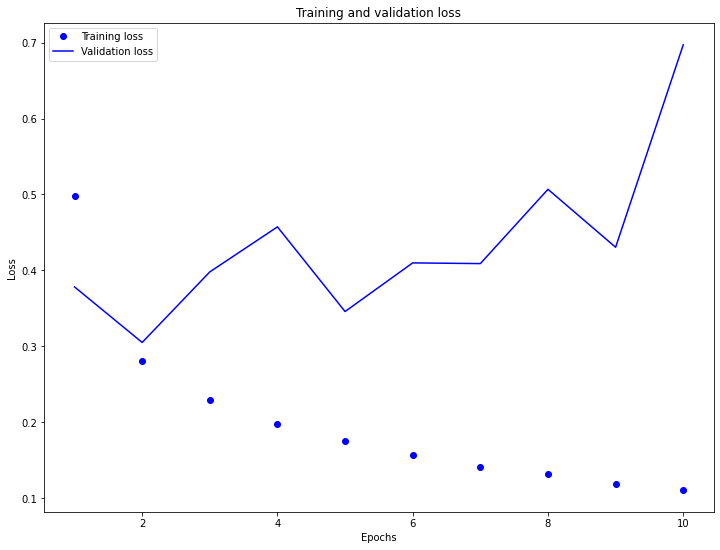

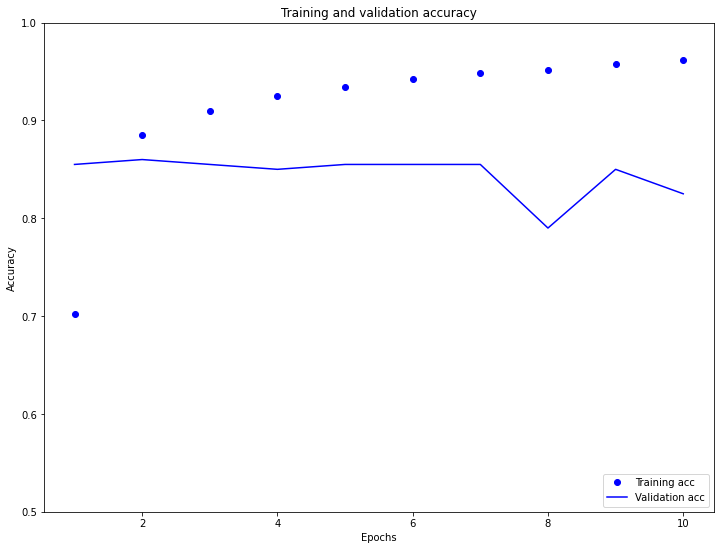

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## 检索学习的嵌入向量

接下来，我们检索在训练期间学习的单词嵌入向量。这将是一个形状为 `(vocab_size, embedding-dimension)` 的矩阵。

In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


现在，我们将权重写入磁盘。要使用 [Embedding Projector](http://projector.tensorflow.org)，我们将以制表符分隔的格式上传两个文件：一个向量文件（包含嵌入向量）和一个元数据文件（包含单词）。

In [15]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

如果您正在 [Colaboratory](https://colab.research.google.com) 中运行本教程，则可以使用以下代码段将这些文件下载到本地计算机上（或使用文件浏览器，*View -> Table of contents -> File browser*）。

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## 可视化嵌入向量

为了可视化嵌入向量，我们将它们上传到 Embedding Projector。

打开 [Embedding Projector](http://projector.tensorflow.org/)（也可以在本地 TensorBoard 实例中运行）。

- 点击“Load data”。

- 上传我们在上面创建的两个文件：`vecs.tsv` 和 `meta.tsv`。

现在将显示您已训练的嵌入向量。您可以搜索单词以查找其最邻近。例如，尝试搜索“beautiful”，您可能会看到“wonderful”等相邻单词。

注：您的结果可能会略有不同，具体取决于训练嵌入向量层之前如何随机初始化权重。

注：您可以试验性地使用更简单的模型来生成更多可解释的嵌入向量。尝试删除 `Dense(16)` 层，重新训练模型，然后再次可视化嵌入向量。

<img alt="Screenshot of the embedding projector" width="400" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1">


## 后续步骤


本教程向您展示了如何在小数据集上从头开始训练和可视化单词嵌入向量。

- 要了解循环网络，请参阅 [Keras RNN 指南](../../guide/keras/rnn.ipynb)。

- 要详细了解文本分类（包括整个工作流，以及如果您对何时使用嵌入向量还是独热编码感到好奇），我们建议您阅读这篇实用的文本分类[指南](https://developers.google.com/machine-learning/guides/text-classification/step-2-5)。